### Functions
 - [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit)
 - [SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
 - [LDA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
 - [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

### Tutorial
- [In Depth: k-Means Clustering](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)
- [Clustering US Laws using TF-IDF and K-Means](https://beckernick.github.io/law-clustering/)
- [The 5 Clustering Algorithms Data Scientists Need to Know](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)

In [239]:
import re
from string import punctuation
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AffinityPropagation, estimate_bandwidth
import nltk
import spacy
import gensim
from gensim.models.phrases import Phrases, Phraser
from nltk import word_tokenize
from nltk.corpus import stopwords

import pylab as pl
from IPython import display


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def _get_stopwords():
    stpwords = stopwords.words('portuguese') + list(punctuation)
    rms = ['um', 'não', 'mais', 'muito']
    for rm in rms:
        del stpwords[stpwords.index(rm)]
    return stpwords

def tokenizer(phrase):
    phrase = phrase.lower()
    for o, r in RM:
        phrase = re.sub(o, r, phrase, flags=re.MULTILINE)
    phrase = NLP(re.sub(r'["\'@#%\(\)]', '', phrase), disable=['parser'])
    clean_frase = []
    for palavra in phrase:
        if palavra.pos_ != 'PUNCT':
            word = palavra.text.strip()
            if not is_number(word) and word not in STOPWORDS and len(word) > 1:
#                 if palavra.pos_ in ['NOUN', 'ADJ', 'ADV']:
                clean_frase += [STEMMER.stem(palavra.text)]
#                     clean_frase += [palavra.text]
#                 else:
#                     clean_frase += [palavra.lemma_]
    return ' '.join(clean_frase)

# GLOBALS
NLP = spacy.load('pt')
# STEMMER = nltk.stem.RSLPStemmer()
STEMMER = nltk.stem.SnowballStemmer('portuguese')
STOPWORDS = _get_stopwords()
RM = [
    ('\n', '. '), ('"', ''), ('@', ''),
    ('#', ''), ('RT', ''), (r'(http[s]*?:\/\/)+.*[\r\n]*', '')
]

np.random.seed(12345)

%matplotlib inline

In [240]:
dc = NLP('soldado', disable=['parser'])
print([(w.text, w.pos_, w.lemma_) for w in dc])

[('soldado', 'NOUN', 'soldar')]


In [251]:
frases_felicidade = [
    ('Quando a tristeza bater na sua porta, abra um belo sorriso e diga: Desculpa, mas hoje a felicidade chegou primeiro!', 'FELICIDADE'),
    ('Minha meta é ser feliz, não perfeito.', 'FELICIDADE'),
    ('Que a felicidade vire rotina.', 'FELICIDADE'),
    ('Felicidade é saber aproveitar todos os momentos como se fossem os últimos.', 'FELICIDADE'),
    ('Eu não quero esperar até o final para ser feliz. Eu quero é ser feliz agora.', 'FELICIDADE'),
    ('Hoje estou muito feliz!', 'FELICIDADE'),
    ('O dia esta excelente, estou muito feliz.', 'FELICIDADE'),
    ('Abra um sorriso, que a felicidade chegou.', 'FELICIDADE'),
    ('Como estou feliz, desejo que a felicidade invade seu coração', 'FELICIDADE'),
    ('Estou sorrindo... você não percebe como estou feliz.', 'FELICIDADE'),
    ('Saber encontrar a alegria na alegria dos outros, é o segredo da felicidade.', 'FELICIDADE'),
    ('A alegria de fazer o bem é a única felicidade verdadeira.', 'FELICIDADE'),
    ('Na plenitude da felicidade, cada dia é uma vida inteira.', 'FELICIDADE'),
    ('As ideias das pessoas são pedaços da sua felicidade.', 'FELICIDADE'),
    ('O segredo da felicidade é encontrar a nossa alegria na alegria dos outros.', 'FELICIDADE'),
]

frases_tristeza = [
    ('O maior problema em acreditar nas pessoas erradas, é que um dia você acaba não acreditando em mais ninguém.', 'TRISTEZA'),
    ('Não me deixe ir, posso nunca mais voltar.', 'TRISTEZA'),
    ('Prefiro que enxerguem em mim erros com arrependimento do que uma falsa perfeição.', 'TRISTEZA'),
    ('A morte é uma pétala que se solta da flor e deixa uma eterna saudade no coração.', 'TRISTEZA'),
    ('Partiu para não mais voltar, e meu coração se partiu para não mais se recompor. Saudades de quem a morte levou para sempre.', 'TRISTEZA'),
    ('Luto é o tempo necessário para a mente entender o sentimento de perda que o coração já sente.', 'TRISTEZA'),
    ('Suas memórias são meu maior tesouro. Saudades suas, meu pai!', 'TRISTEZA'),
    ('Meu amigo se foi para sempre. No seu lugar ficaram estas saudades eternas, que eternamente serão sentidas com muita tristeza.', 'TRISTEZA'),
    ('Hoje o sol não brilhou, os pássaros não cantaram, os risos se calaram e as lágrimas rolaram em meu rosto. Meu coração sofre em silêncio.', 'TRISTEZA'),
    ('Lágrimas não doem, o que dói é o motivo que as fazem cair.', 'TRISTEZA'),
    ('A dor de perder um filho, é um sentimento muito triste e ruim.', 'TRISTEZA'),
    ('Não há solidão mais triste do que a do homem sem amizades. A falta de amigos faz com que o mundo pareça um deserto.', 'TRISTEZA'),
    ('A árvore quando está sendo cortada, observa com tristeza que o cabo do machado é de madeira.', 'TRISTEZA'),
    ('Cuidado com a tristeza. Ela é um vício.', 'TRISTEZA'),
    ('É triste pensar que a natureza fala e que o gênero humano não a ouve.', 'TRISTEZA'),
    ('A ganância insaciável é um dos tristes fenómenos que apressam a autodestruição do homem.', 'TRISTEZA'),
]

frases_amor = [
    ('Duvide do brilho das estrelas. Duvide do perfume de uma flor. Duvide de todas as verdades. Mas nunca duvide do meu amor.', 'AMOR'),
    ('Amar é cuidar um do outro mesmo quando estamos zangados.', 'AMOR'),
    ('O amor só é lindo, quando encontramos alguém que nos transforme no melhor que podemos ser.', 'AMOR'),
    ('Quando o amor é verdadeiro, a distância vira mero detalhe.', 'AMOR'),
    ('Não escolha a pessoa mais bonita do mundo. Escolha a pessoa que faz do seu mundo o mais bonito.', 'AMOR'),
    ('Pensando em você, me torno um poeta, olhando você, me torno um artista, imaginando nosso amor, me torno um sonhador', 'AMOR'),
    ('Sinto que meu amor por você cresce a cada dia.', 'AMOR'),
    ('Só o seu amor me faz cresce, te amo demais linda!', 'AMOR'),
    ('A amizade é um amor que nunca morre.', 'AMOR'),
    ('Lutar pelo amor é bom, mas alcançá-lo sem luta é melhor.', 'AMOR'),
    ('Aquilo que se faz por amor está sempre além do bem e do mal.', 'AMOR'),
    ('As mais lindas palavras de amor são ditas no silêncio de um olhar.', 'AMOR'),
    ('O verdadeiro amor nunca se desgasta. Quanto mais se dá mais se tem.', 'AMOR'),
    ('Se o amor é fantasia, eu me encontro ultimamente em pleno carnaval.', 'AMOR'),
    ('Amai, porque nada melhor para a saúde que um amor correspondido.', 'AMOR'),
    ('O amor não se vê com os olhos mas com o coração.', 'AMOR'),
    ('A medida do amor é amar sem medida.', 'AMOR'),
    ('Como são sábios aqueles que se entregam às loucuras do amor!', 'AMOR'),
]

In [252]:
frases_felicidade_parsed = []
frases_tristeza_parsed = []
frases_amor_parsed = []
frases_felicidade_sentimento = []
frases_tristeza_sentimento = []
frases_amor_sentimento = []

# dc = NLP('é que um dia você acaba não acreditando em mais ninguém', disable=['parser'])
# print([(w.text, w.pos_, w.lemma_) for w in dc])

for frase, sentimento in frases_felicidade:
    frases_felicidade_parsed.append(tokenizer(frase))
    frases_felicidade_sentimento.append(sentimento)

for frase, sentimento in frases_tristeza:
    frases_tristeza_parsed.append(tokenizer(frase))
    frases_tristeza_sentimento.append(sentimento)

for frase, sentimento in frases_amor:
    frases_amor_parsed.append(tokenizer(frase))
    frases_amor_sentimento.append(sentimento)

print(frases_felicidade_parsed)
print(frases_tristeza_parsed)
print(frases_amor_parsed)

frases = frases_felicidade_parsed + frases_tristeza_parsed + frases_amor_parsed
ldocs = [f'D{i}' for i in range(len(frases))]

['tristez bat port abra um bel sorris dig desculp hoj felic cheg primeir', 'met ser feliz nã perfeit', 'felic vir rotin', 'felic sab aproveit tod moment últim', 'nã quer esper final ser feliz quer ser feliz agor', 'hoj muit feliz', 'dia excelent muit feliz', 'abra um sorris felic cheg', 'feliz desej felic invad coraçã', 'sorr nã perceb feliz', 'sab encontr alegr alegr outr segred felic', 'alegr faz bem únic felic verdadeir', 'plenitud felic cad dia vid inteir', 'ide pesso pedac felic', 'segred felic encontr alegr alegr outr']
['maior problem acredit pesso errad um dia acab nã acredit mais ninguém', 'nã deix ir poss nunc mais volt', 'prefir enxergu mim erros arrepend fals perfeiçã', 'mort pétal solt flor deix etern saudad coraçã', 'part nã mais volt coraçã part nã mais recompor saudad mort lev sempr', 'lut temp necessári ment entend sentiment perd coraçã sent', 'memór maior tesour saudad pai', 'amig sempr lug fic saudad etern etern sent muit tristez', 'hoj sol nã brilh pássar nã cant ri

In [253]:
vec_tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_tfidf = vec_tfidf.fit_transform(frases)

N_features = X_tfidf.shape[1]

frases_w2v = []
for frase in frases:
    bigram = []
    p_frase = word_tokenize(frase)
    for m, palavra in enumerate(p_frase):
        next_p = None
        try:
            next_p = p_frase[m+1]
        except:
            pass
        bigram += [f'{palavra}']
#         if next_p:
#             bigram += [f'{palavra} {next_p}']
    frases_w2v += [bigram]

model = gensim.models.Word2Vec(
    frases_w2v,
    sg=1,
    size=N_features,
    window=50,
    min_count=1,
    workers=10)
model.train(frases_w2v, total_examples=len(frases_w2v), epochs=1500)

vec_count = CountVectorizer(ngram_range=(1, 1))
X_count = vec_count.fit_transform(frases)
weights_count = pd.DataFrame(np.round(X_count.toarray().T, 5), index=vec_count.get_feature_names(), columns=ldocs)

print(X_tfidf.shape)
print(X_count.shape)
print(model.wv.vectors.shape)

# X_tfidf = X_tfidf + X_count
# X_tfidf = np.asarray(np.dot(X_tfidf.toarray(), model.wv.vectors))
# X_tfidf = np.asarray(np.dot(X_tfidf.toarray(), model.wv.vectors))
X_tfidf = X_count.toarray()

print("   Actual number of tfidf features: %d" % N_features)
weights_tfidf = pd.DataFrame(np.round(X_tfidf.T, 5), index=vec_tfidf.get_feature_names(), columns=ldocs)
# display(weights_tfidf.head(15))
print(weights_tfidf.head(15))

(49, 195)
(49, 195)
(195, 195)
   Actual number of tfidf features: 195
         D0  D1  D2  D3  D4  D5  D6  D7  D8  D9 ...   D39  D40  D41  D42  D43  \
abra      1   0   0   0   0   0   0   1   0   0 ...     0    0    0    0    0   
acab      0   0   0   0   0   0   0   0   0   0 ...     0    0    0    0    0   
acredit   0   0   0   0   0   0   0   0   0   0 ...     0    0    0    0    0   
agor      0   0   0   0   1   0   0   0   0   0 ...     0    0    0    0    0   
alcanc    0   0   0   0   0   0   0   0   0   0 ...     0    1    0    0    0   
alegr     0   0   0   0   0   0   0   0   0   0 ...     0    0    0    0    0   
alguém    0   0   0   0   0   0   0   0   0   0 ...     0    0    0    0    0   
além      0   0   0   0   0   0   0   0   0   0 ...     0    0    1    0    0   
ama       0   0   0   0   0   0   0   0   0   0 ...     0    0    0    0    0   
amar      0   0   0   0   0   0   0   0   0   0 ...     0    0    0    0    0   
amig      0   0   0   0   0   0   0   

In [254]:
alegria = ['feliz', 'felicidade', 'sorriso', 
           'perfeito', 'belo', 'excelente', 'perfeição', 
           'amor', 'verdadeiro', 'verdade', 'cuidar', 'lindo', 'tesouro']
alegria += ['abundante', 'acalmar', 'aceitável', 'aceitação', 'aclamar', 'aconchego', 'adesão', 'admirar', 'adorar', 'adoração', 'afeição', 'afeto', 'afetividade', 'afortunado', 'afável', 'agradar', 'ajeitar', 'altivez', 'altivo', 'alívio', 'amabilidade', 'amado', 'amar', 'amenizar', 'ameno', 'amigável', 'amistoso', 'amizade', 'amor', 'amável', 'animação', 'anseio', 'ansioso', 'apaixonado', 'apaziguar', 'aplausos', 'apoiar', 'aprazer', 'apreciar', 'aprovação', 'aproveitar', 'ardor', 'armirar', 'arrumar', 'atraente', 'atrair', 'atração', 'avidamente', 'avidez', 'belo', 'beleza', 'bem-estar', 'beneficiador', 'beneficência', 'benefício', 'benevocência', 'benignamente', 'benéfico', 'benígno', 'boa-intenção', 'bom', 'bom-humor', 'bondade', 'bondoso', 'bonito', 'bravura', 'brilhante', 'brilhantismo', 'brincadeira', 'brio', 'calma', 'calor', 'caridade', 'caridoso', 'carinho', 'cativar', 'charme', 'cheery', 'clamar', 'cofortar', 'coleguismo', 'comover', 'compaixão', 'companheirismo', 'compatibilidade', 'compatível', 'complacência', 'completar', 'compreensão', 'comédia', 'conclusão', 'concretização', 'condescendência', 'confiança', 'confortante', 'congratulação', 'conquistar', 'consentir', 'considerar', 'consideração', 'consolação', 'consolo', 'contentamento', 'contente', 'coragem', 'cordial', 'cuidadoso', 'cumplicidade', 'cômico', 'dedicação', 'deleitado', 'delicadamente', 'delicadeza', 'delicado', 'desejar', 'despreocupação', 'devoto', 'devoção', 'dignidade', 'diversão', 'divertido', 'elogiado', 'emocionante', 'emotivo', 'emoção', 'empatia', 'empolgação', 'empático', 'enamorar', 'encantado', 'encantar', 'encorajado', 'enfeitar', 'engraçado', 'entendimento', 'entusiasmadamente', 'entusiástico', 'esperança', 'esplendor', 'estima', 'estimar', 'estimulante', 'euforia', 'euforizante', 'eufórico', 'exaltar', 'excelente', 'excitar', 'expansivo', 'extasiar', 'exuberante', 'exultar', 'facilitar', 'familiaridade', 'fascinação', 'fascínio', 'favor', 'favorecer', 'favorito', 'felicidade', 'feliz', 'festa', 'festejar', 'festivo', 'fidelidade', 'fiel', 'filantropia', 'filantrópico', 'fraterno', 'fã', 'ganhar', 'generosidade', 'generoso', 'gentil', 'glorificar', 'glória', 'gostar', 'gostoso', 'gozar', 'gratidão', 'gratificante', 'gratificação', 'grato', 'hilariante', 'honra', 'humor', 'impressionar', 'incentivar', 'incentivo', 'inclinação', 'incrível', 'inspirar', 'interessar', 'interesse', 'irmandade', 'jovial', 'jovialidade', 'jubilante', 'júbilo', 'lealdade', 'legítimo', 'leveza', 'louvar', 'louvavelmente', 'louvável', 'lucrativo', 'lucro', 'majestoso', 'maravilhoso', 'melhor', 'namoro', 'nobre', 'obter', 'obteve', 'ode', 'orgulho', 'orgulhoso', 'paixão', 'parabenizar', 'paz', 'piedoso', 'positivo', 'prazenteiro', 'prazer', 'predileção', 'preencher', 'preferido', 'preferência', 'promissor', 'prosperidade', 'proteger', 'protetor', 'proteção', 'proveito', 'provilégio', 'querer', 'radiante', 'realizar', 'recomendável', 'recompensa', 'reconhecer', 'recrear', 'recreativo', 'recreação', 'regozijar', 'respeitar', 'ressuscitar', 'revigorar', 'risada', 'risonho', 'romantismo', 'romântico', 'saciar', 'saciável', 'satisfatoriamente', 'satisfatório', 'satisfazer', 'satisfação', 'satisfeito', 'seduzir', 'sedução', 'sereno', 'simpaticamente', 'simpático', 'sobreviver', 'sobrevivência', 'sorte', 'sortudo', 'sucesso', 'surpreender', 'tenro', 'ternura', 'torcer', 'tranquilo', 'triunfal', 'triunfante', 'triunfo', 'vanglória', 'vantagem', 'vantajoso', 'vencedor', 'veneração', 'ventura', 'vida', 'vigor', 'virtude', 'virtuoso', 'vitorioso', 'vitória', 'viver', 'vivo', 'zelo', 'zeloso', 'ávido', 'ânimo', 'ânsia', 'tesouro']
alegria = list(set(alegria))
tristeza = ['tristeza', 'problema', 'arrependimento', 'errar', 
            'não', 'falsa', 'morte', 'saudade', 'luto', 'distância', 
            'perda', 'memórias', 'dúvida', 'dói', 'lágrimas']
tristeza += ['abandonado', 'abandonar', 'abater', 'abatido', 'abatimento', 'abominável', 'aborrecer', 'aborrecimento', 'abortar', 'aceitação', 'adversidade', 'adverso', 'afastamento', 'afligir', 'aflito', 'aflição', 'agoniado', 'agoniar', 'amargo', 'amargor', 'amargura', 'amargurado', 'angustiado', 'angústia', 'ansiedade', 'apartado', 'arrepender', 'arrependidamente', 'arrependido', 'arrependimento', 'atormentado', 'atrito', 'azar', 'cabisbaixo', 'carrancudo', 'castigar', 'castigo', 'chorar', 'choro', 'choroso', 'chorão', 'circunspecção', 'circunspeção', 'coitado', 'compassivo', 'compungido', 'compunção', 'consternado', 'consternação', 'contristador', 'contrito', 'contrição', 'culpa', 'defeituoso', 'degradante', 'deplorável', 'deposição', 'depravado', 'depressivo', 'depressão', 'deprimente', 'deprimido', 'deprimir', 'derrota', 'derrubar', 'desalentar', 'desalento', 'desamparado', 'desamparo', 'desanimado', 'desanimar', 'desapontar', 'desconsolo', 'descontente', 'desculpas', 'desencorajar', 'desentusiasmar', 'desesperar', 'desespero', 'desestimular', 'desgaste', 'desgosto', 'desgraça', 'desiludir', 'desincentivar', 'desistir', 'desistência', 'deslocado', 'desmoralizar', 'desmotivar', 'desolado', 'desolar', 'desonra', 'despojado', 'desprazer', 'desprezo', 'desumano', 'desânimo', 'discriminar', 'disforia', 'disfórico', 'dissuadir', 'divórcio', 'doloroso', 'dor', 'dó', 'encobrir', 'enegrecer', 'enfadado', 'enlutar', 'entediado', 'entristecedor', 'entristecer', 'envergonhar', 'errante', 'erro', 'errôneo', 'escaldado', 'escurecer', 'escuridão', 'escuro', 'esmorecer', 'esquecido', 'estragado', 'estranho', 'execrável', 'extirpar', 'falsidade', 'falso', 'falta', 'flagelar', 'flagelo', 'fraco', 'fraqueza', 'fricção', 'frieza', 'frio', 'funesto', 'fúnebre', 'gelar', 'grave', 'horror', 'humilhar', 'importuno', 'inconsolável', 'indefeso', 'infelicidade', 'infeliz', 'infortúnio', 'inveja', 'isolado', 'isolamento', 'isolar', 'lacrimejante', 'lacrimoso', 'lamentar', 'lastimoso', 'luto', 'lutoso', 'lágrima', 'lástima', 'lúgubre', 'magoado', 'magoar', 'martirizar', 'martírio', 'mau', 'melancolia', 'melancólico', 'menosprezar', 'miseravelmente', 'misterioso', 'mistério', 'miséria', 'morre', 'morte', 'mortificado', 'mortificante', 'mortificação', 'mágoa', 'negligentemente', 'nocivo', 'nostalgia', 'nublar', 'obscuro', 'ofuscar', 'opressivo', 'opressão', 'oprimir', 'partida', 'pena', 'penalizar', 'penitencial', 'penitente', 'penitência', 'penoso', 'pensativo', 'penumbra', 'perder', 'perturbado', 'perverso', 'pervertar', 'pesar', 'pesaroso', 'pessimamente', 'piedade', 'pobre', 'porcamente', 'prejudicado', 'prejudicial', 'prejuízo', 'pressionar', 'pressão', 'prostração', 'quebrar', 'queda', 'queixoso', 'rechaçar', 'remorso', 'repressivo', 'repressão', 'reprimir', 'retidão', 'retitude', 'ruim', 'saudade', 'secreto', 'segregação', 'sentido', 'separação', 'seriedade', 'servil', 'sisudez', 'sisudeza', 'sobrecarga', 'sobrecarregado', 'sofrer', 'sofrimento', 'solidão', 'solitário', 'sombrio', 'soturno', 'sozinho', 'sucumbir', 'sujo', 'suplicar', 'suplício', 'só', 'timidez', 'tormento', 'torturado', 'torturar', 'trevas', 'triste', 'tristemente', 'tristonho', 'tédio', 'tímido', 'vazio',]
tristeza = list(set(tristeza))

alegria = [tokenizer(word) for word in alegria]
tristeza = [tokenizer(word) for word in tristeza]

def retorn_palavras(palavras, size):
    r_words = {}
    for i, word in enumerate(palavras):
        if len(word) <= 0: continue
        for index, word2 in enumerate(weights_tfidf.index):
            if re.search(r'\b(%s)\b' % word, word2):
                r_words[word2] = weights_tfidf.iloc[index].values
    return r_words # np.asarray(list(r_words.values())).T

r_words_1 = retorn_palavras(alegria, len(frases))
r_words_2 = retorn_palavras(tristeza, len(frases))
r_words = {**r_words_1, **r_words_2}

lwor = list(r_words.keys())
X = np.asarray(list(r_words.values()))
# X = TruncatedSVD(n_components=len(frases), random_state=0).fit_transform(X)
# X = LatentDirichletAllocation(n_components=len(frases), random_state=0).fit_transform(X)
weights = pd.DataFrame(X, index=lwor)
print(weights)
X = X.T
# display(weights.head(15))

# n = len(model.wv.vectors[1])
# X = TruncatedSVD(n_components=29, random_state=0).fit_transform(X)
# print(X.shape)
# X = LatentDirichletAllocation(n_components=n, random_state=0).fit_transform(softmax(X))

           0   1   2   3   4   5   6   7   8   9  ...  39  40  41  42  43  44  \
perfeit     0   1   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   
feliz       0   1   0   0   2   1   1   0   1   1 ...   0   0   0   0   0   0   
melhor      0   0   0   0   0   0   0   0   0   0 ...   0   1   0   0   0   0   
sorris      1   0   0   0   0   0   0   1   0   0 ...   0   0   0   0   0   0   
verdadeir   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   0   
perfeiçã    0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   
amor        0   0   0   0   0   0   0   0   0   0 ...   1   1   1   1   1   1   
bom         0   0   0   0   0   0   0   0   0   0 ...   0   1   0   0   0   0   
cuid        0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   
bonit       0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   
verdad      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   
ris         0   0   0   0   

In [255]:
# k = 3
# kmeans = KMeans(n_clusters=k, n_init=150, max_iter=1500, random_state=0, n_jobs=5)
# J = kmeans.fit_transform(X)

# kmeans = DBSCAN(eps=.05, min_samples=3)
# kmeans.fit(X)
# k = len(set(kmeans.labels_))

kmeans = AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)
kmeans.fit(X)
# kmeans = MeanShift(
#     bandwidth=estimate_bandwidth(X, quantile=.5, n_samples=len(X)-1, random_state=0),
#     cluster_all=True, n_jobs=5)
# kmeans.fit(X)
k = len(set(kmeans.labels_))
print('labels:', kmeans.labels_)
labels_unique = np.unique(kmeans.labels_)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

labels: [ 2  3  2  2  0  1  1  2  1  3  2  2  2  2  2  3  3  4  1  5  6  9  9  3
  3  7  8  9  9  3  1 12  1 12 12 10 12 12 12 12 11 12 12 12 12 12  3 12
 12]
number of estimated clusters : 13


In [256]:
cluster_assignments_dict = {}

for i in set(kmeans.labels_):
    current_cluster = [frases[x] for x in np.where(kmeans.labels_ == i)[0]]
    cluster_assignments_dict[i] = current_cluster

for n in range(k):
    print('-- Cluster {0}'.format(n))
    for frase in cluster_assignments_dict[n]:
        if frase in frases_felicidade_parsed:
            print('FELICIDADE', frase)
        elif frase in frases_tristeza_parsed:
            print('TRISTEZA', frase)
        elif frase in frases_amor_parsed:
            print('AMOR', frase)

-- Cluster 0
FELICIDADE nã quer esper final ser feliz quer ser feliz agor
-- Cluster 1
FELICIDADE hoj muit feliz
FELICIDADE dia excelent muit feliz
FELICIDADE feliz desej felic invad coraçã
TRISTEZA mort pétal solt flor deix etern saudad coraçã
TRISTEZA ganânc insac um trist fenómen apress autodestruiçã hom
AMOR amar cuid um outr zang
-- Cluster 2
FELICIDADE tristez bat port abra um bel sorris dig desculp hoj felic cheg primeir
FELICIDADE felic vir rotin
FELICIDADE felic sab aproveit tod moment últim
FELICIDADE abra um sorris felic cheg
FELICIDADE sab encontr alegr alegr outr segred felic
FELICIDADE alegr faz bem únic felic verdadeir
FELICIDADE plenitud felic cad dia vid inteir
FELICIDADE ide pesso pedac felic
FELICIDADE segred felic encontr alegr alegr outr
-- Cluster 3
FELICIDADE met ser feliz nã perfeit
FELICIDADE sorr nã perceb feliz
TRISTEZA maior problem acredit pesso errad um dia acab nã acredit mais ninguém
TRISTEZA nã deix ir poss nunc mais volt
TRISTEZA hoj sol nã brilh pássa

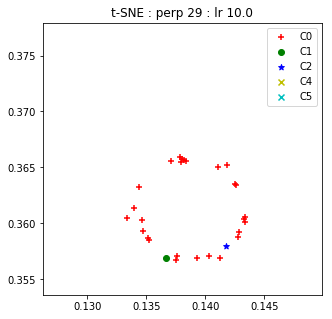

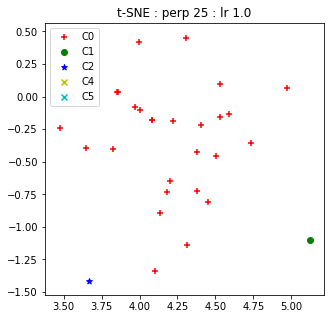

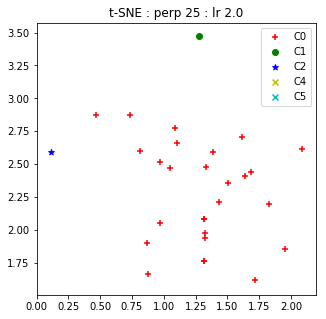

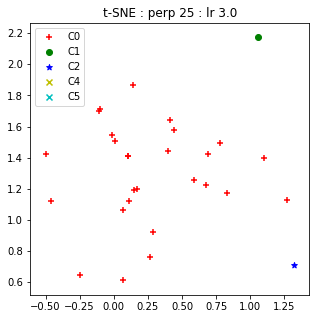

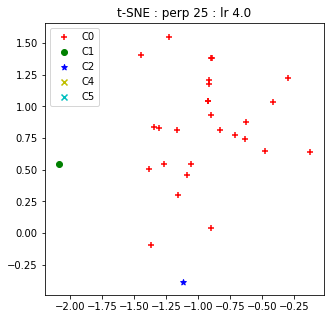

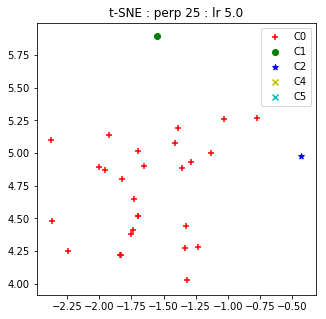

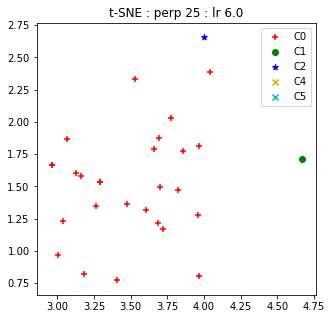

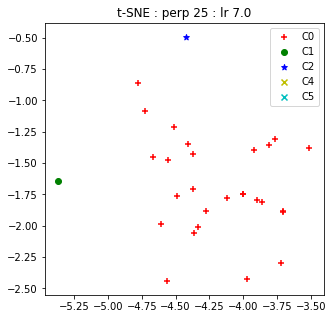

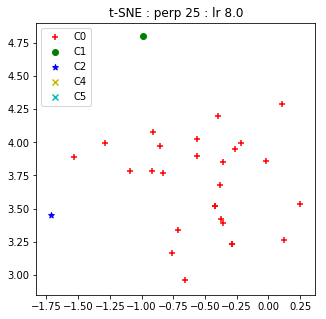

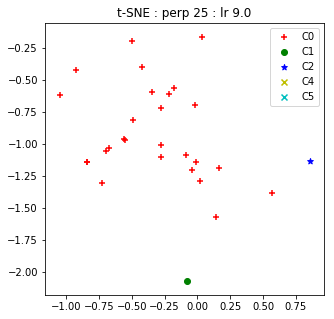

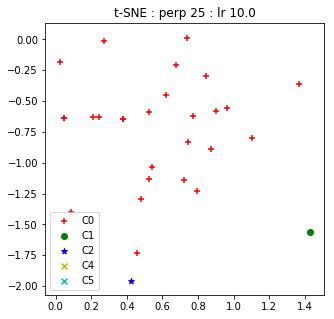

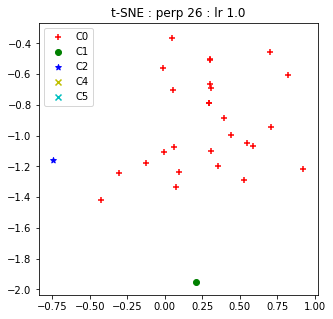

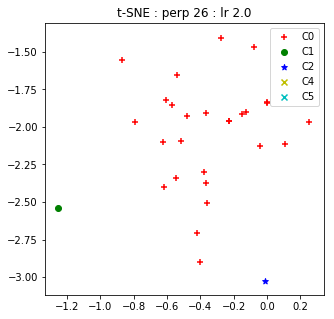

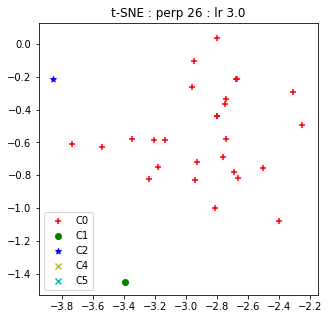

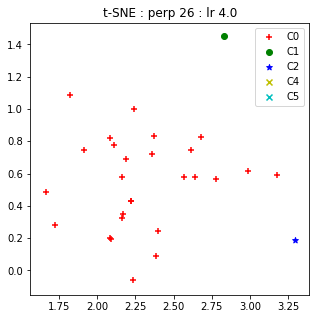

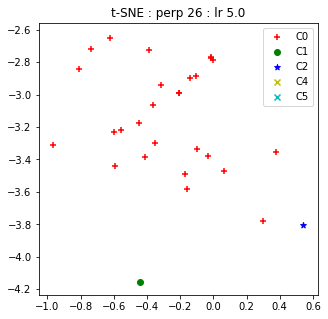

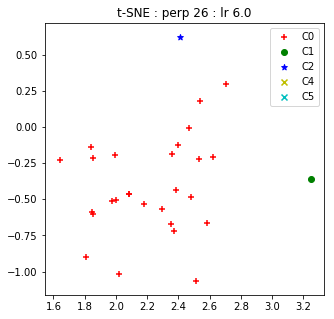

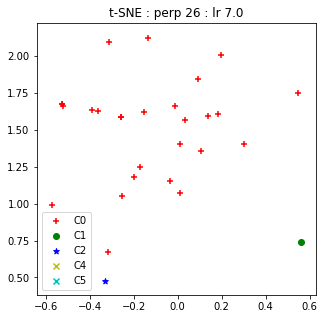

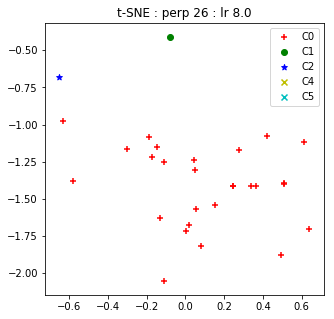

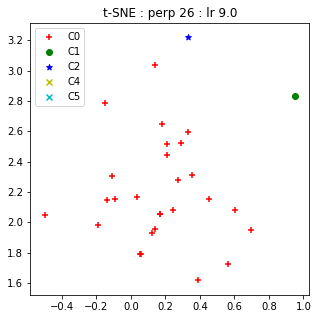

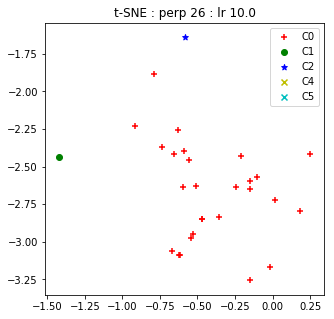

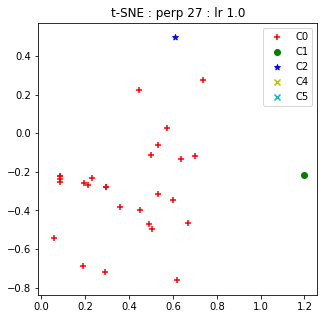

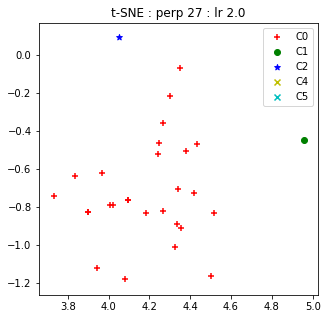

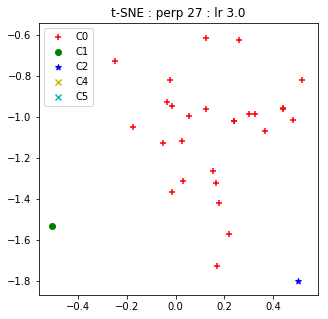

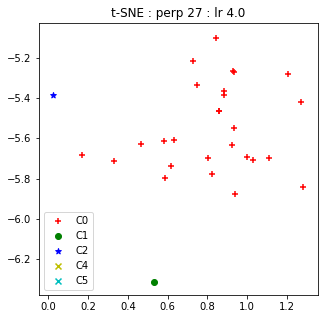

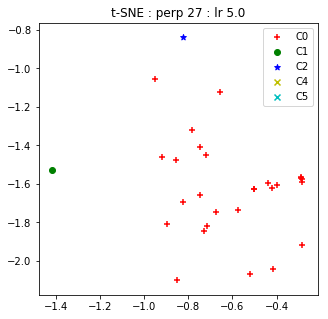

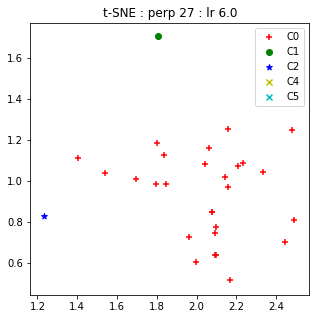

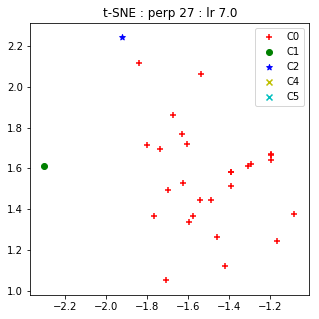

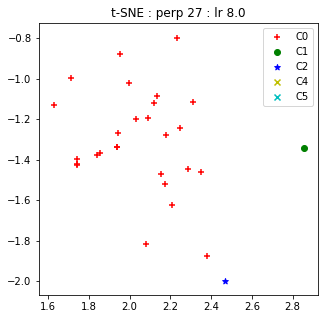

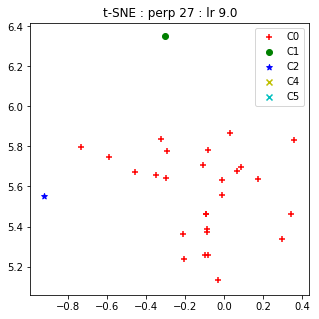

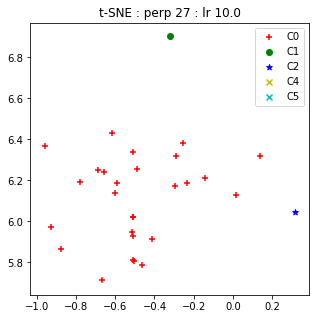

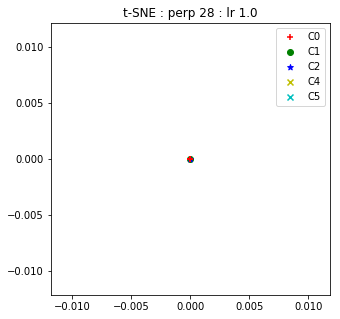

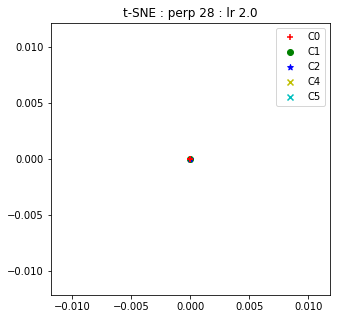

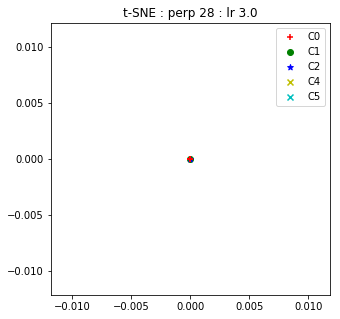

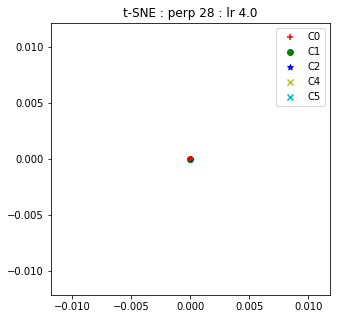

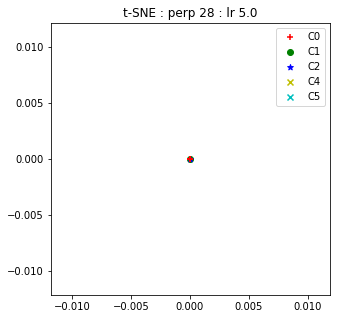

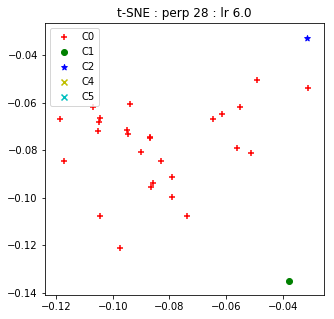

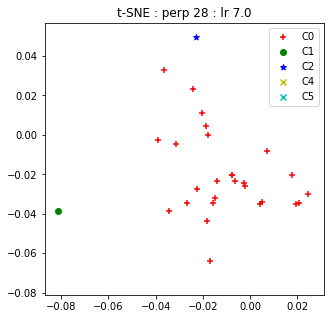

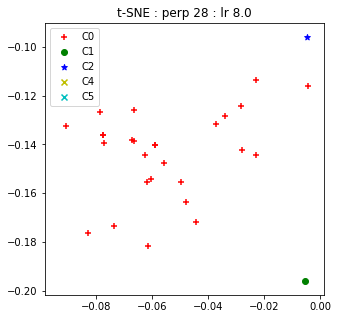

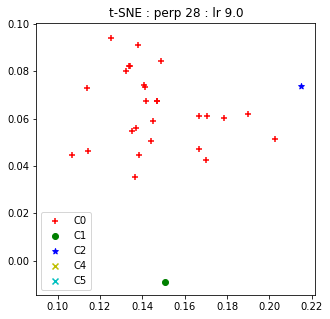

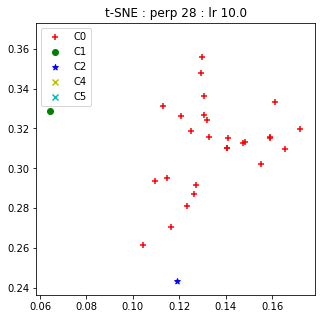

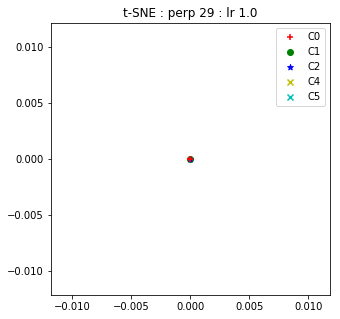

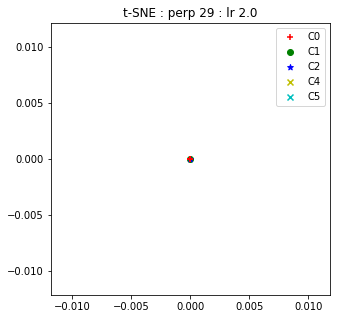

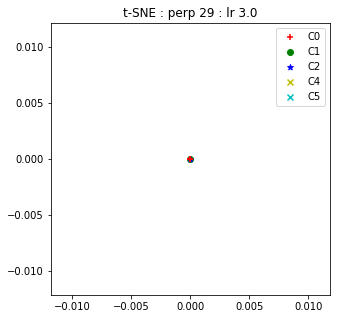

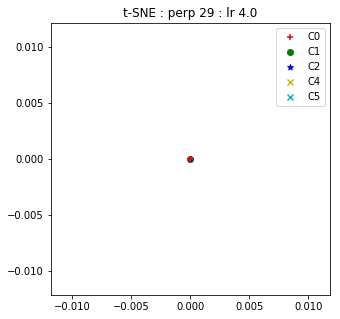

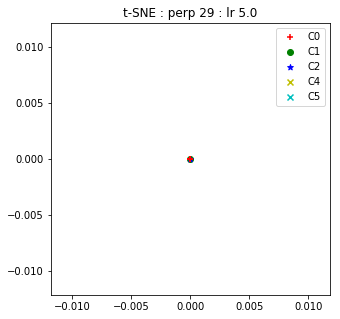

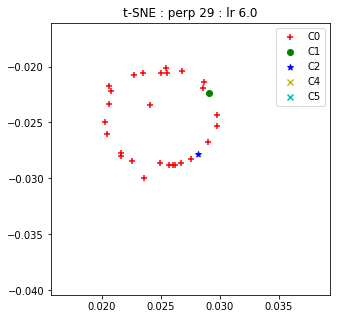

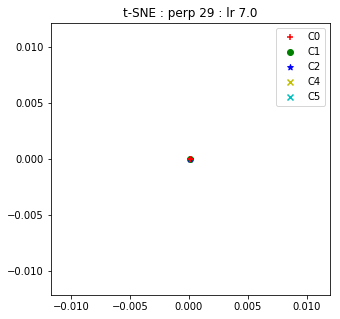

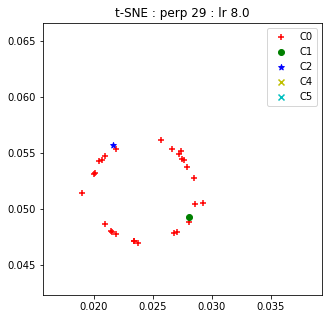

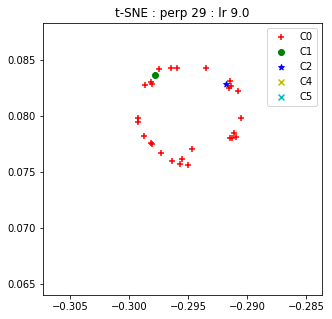

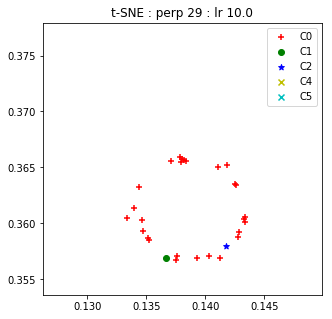

In [196]:
import time
for perp in range(25, 30):
    for lr in np.linspace(1, 10, 10):
        J = TSNE(n_components=2, perplexity=perp, learning_rate=lr, random_state=0).fit_transform(X)

        fig = plt.figure(figsize = (5, 5))
        for i in range(J.shape[0]):
            if kmeans.labels_[i] == 0:
                c1 = plt.scatter((J[i, 0]), (J[i, 1]), c='r', marker='+')
            elif kmeans.labels_[i] == 1:
                c2 = plt.scatter((J[i, 0]), (J[i, 1]), c='g', marker='o')
            elif kmeans.labels_[i] == 2:
                c3 = plt.scatter((J[i, 0]), (J[i, 1]), c='b', marker='*')
            elif kmeans.labels_[i] == 3:
                c4 = plt.scatter((J[i, 0]), (J[i, 1]), c='y', marker='x')
            elif kmeans.labels_[i] == 4:
                c5 = plt.scatter((J[i, 0]), (J[i, 1]), c='c', marker='x')
        plt.title(f't-SNE : perp {perp} : lr {lr}')
        plt.legend([c1, c2, c3, c4, c5], ['C0', 'C1', 'C2', 'C4', 'C5'])
        # plt.show()
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(.3)

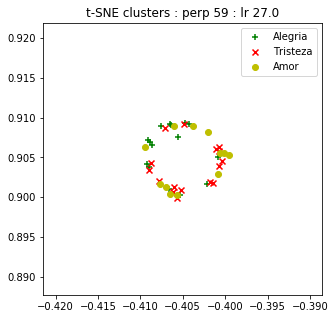

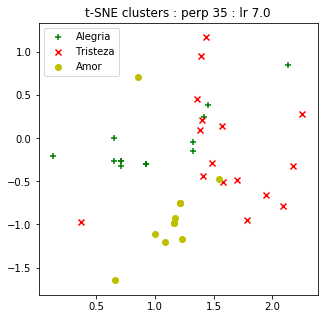

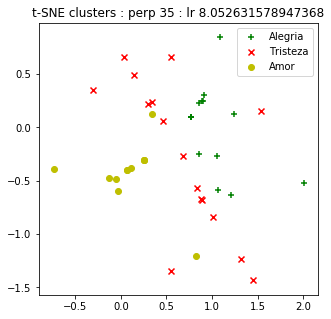

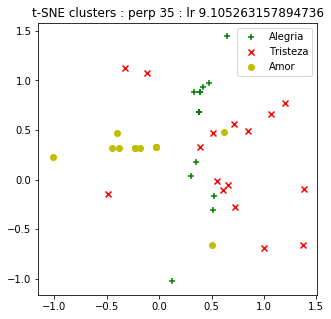

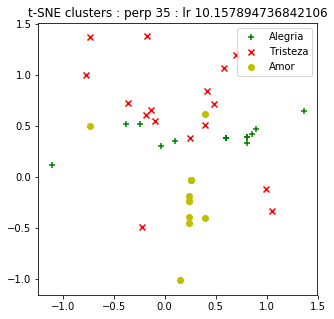

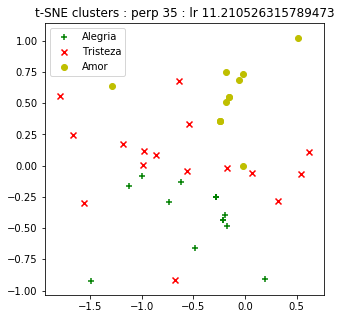

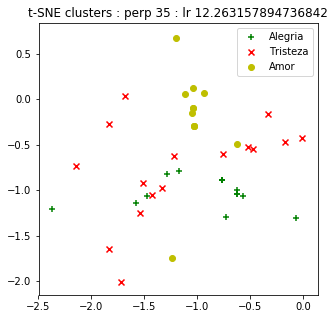

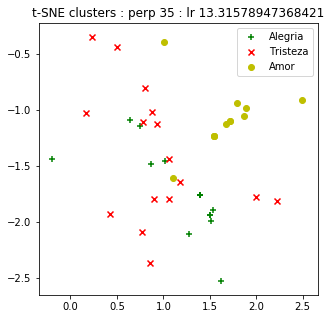

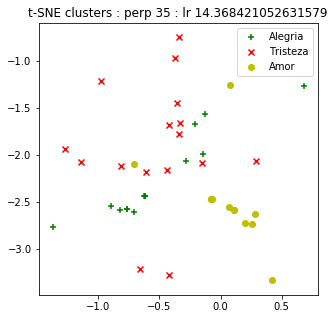

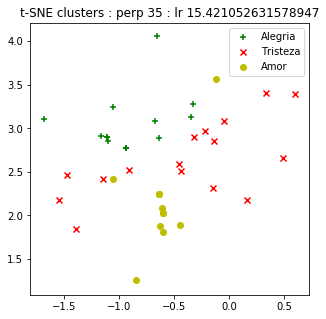

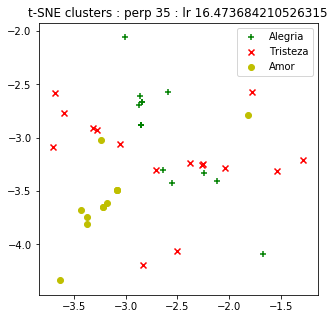

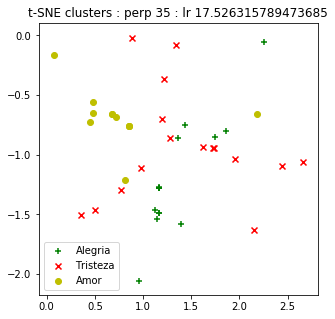

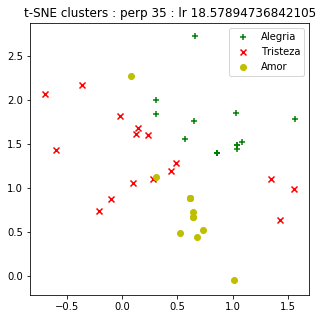

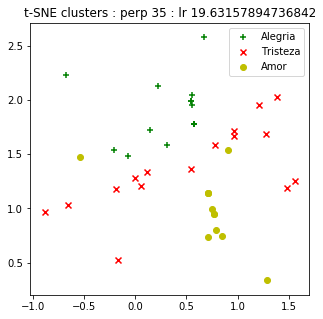

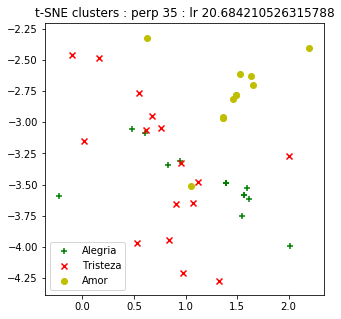

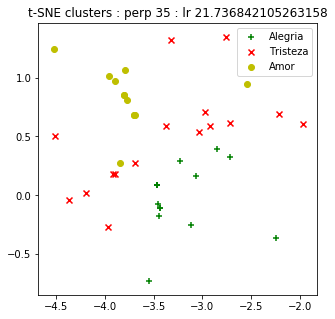

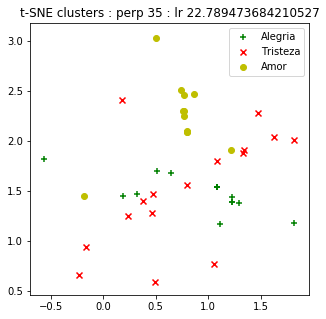

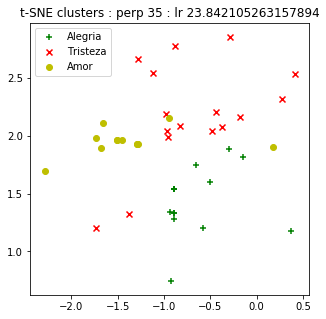

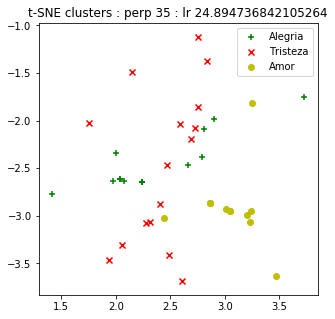

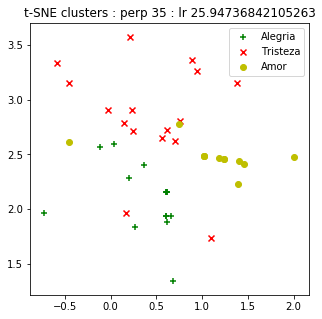

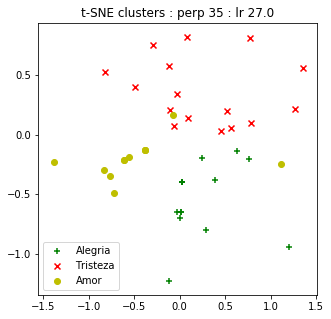

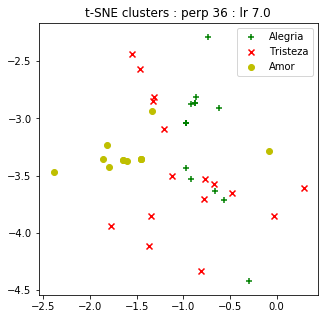

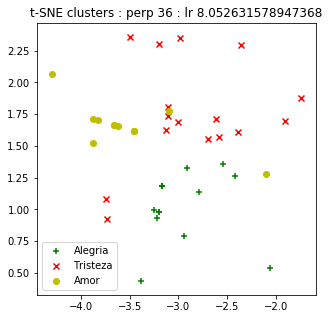

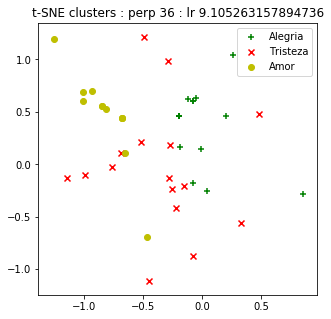

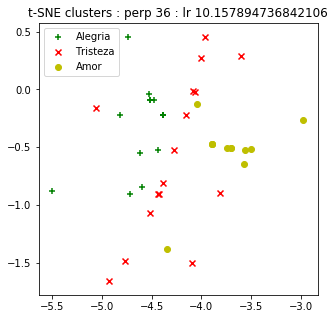

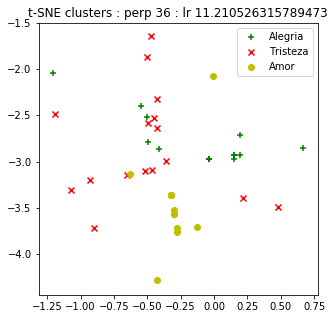

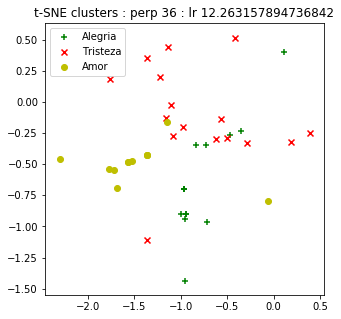

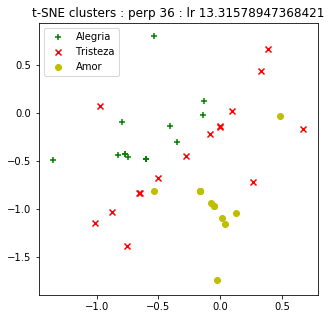

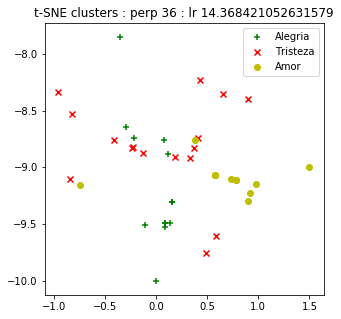

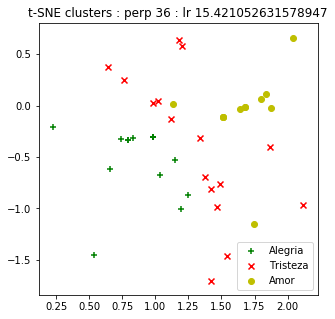

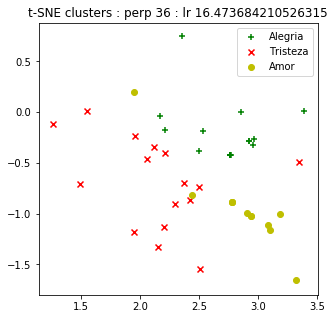

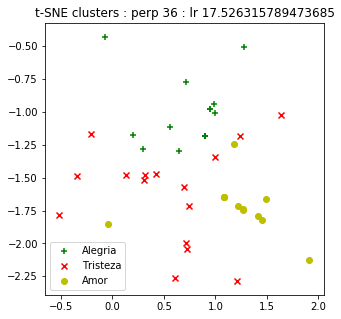

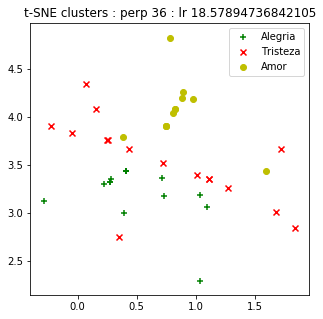

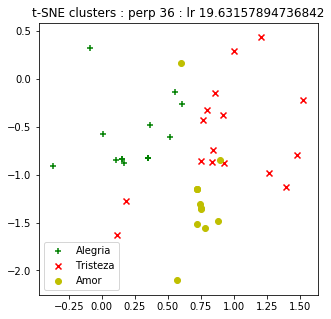

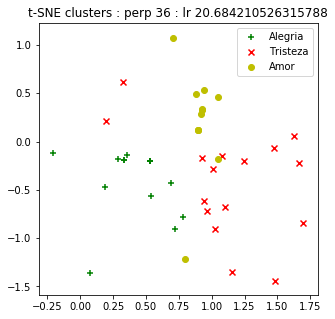

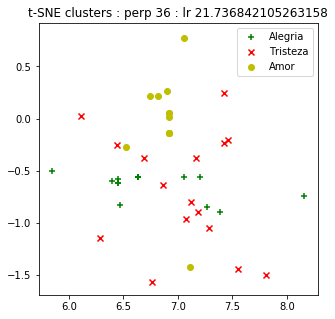

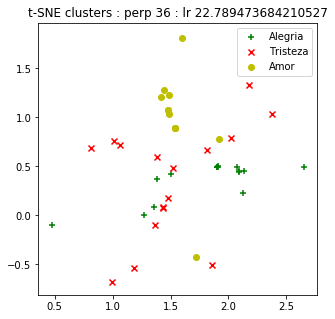

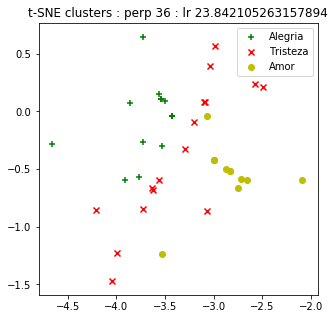

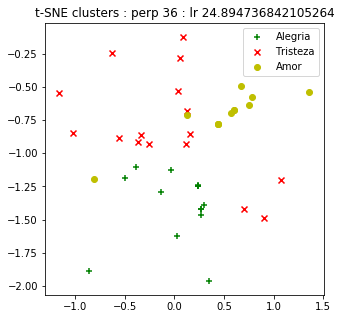

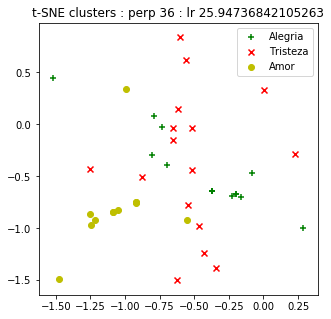

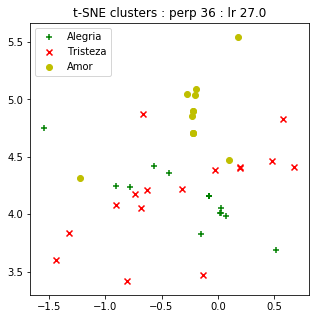

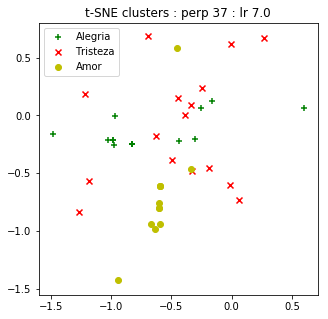

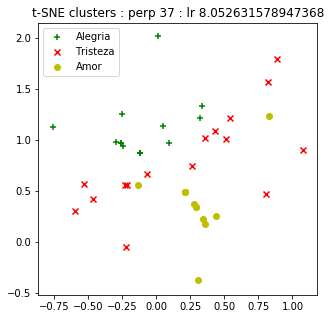

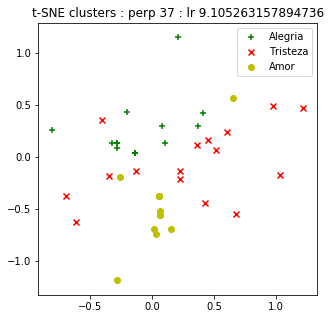

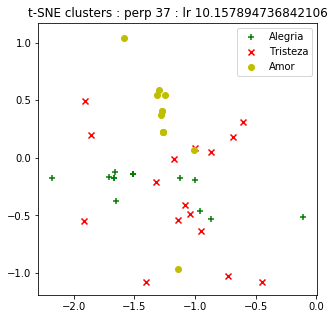

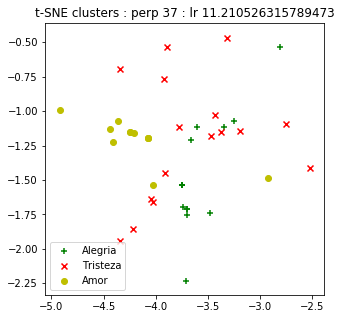

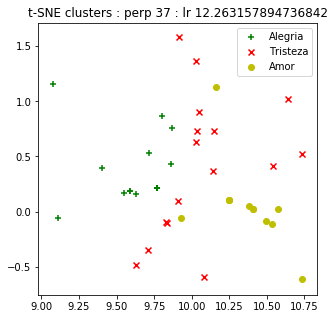

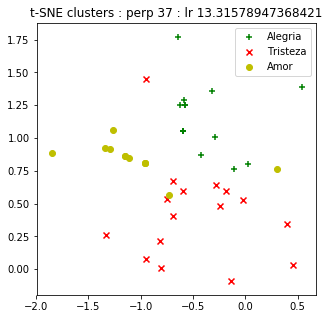

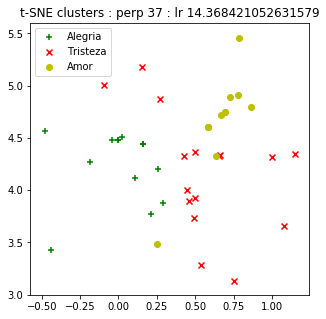

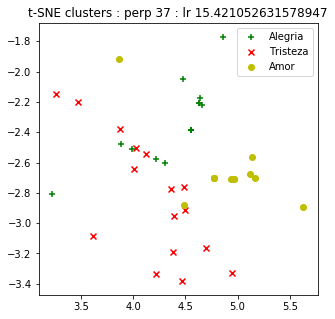

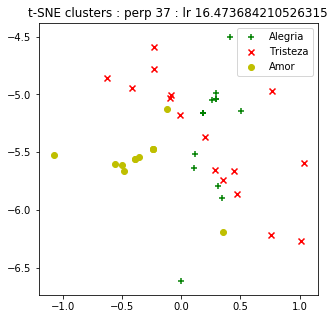

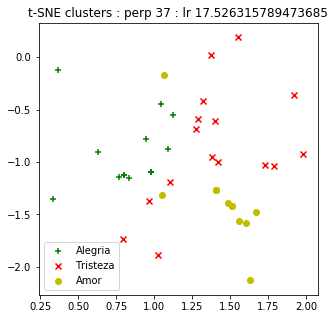

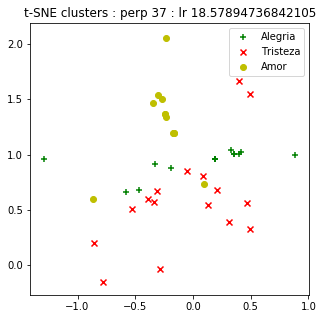

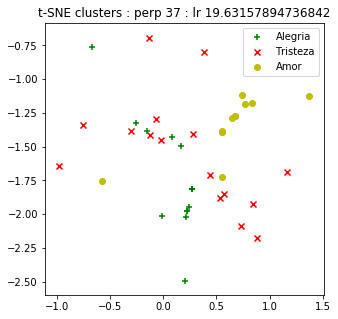

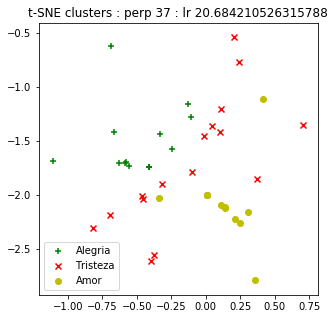

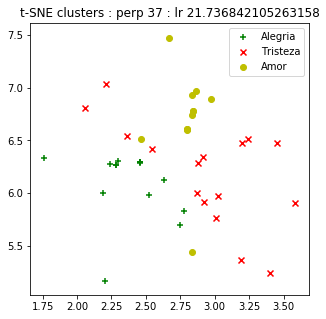

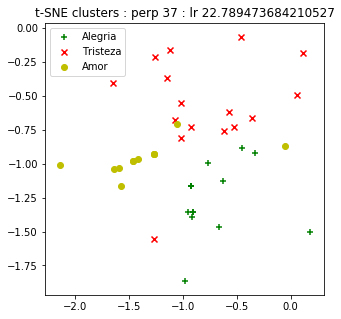

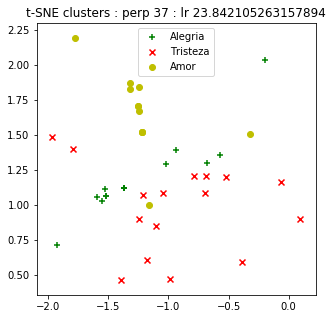

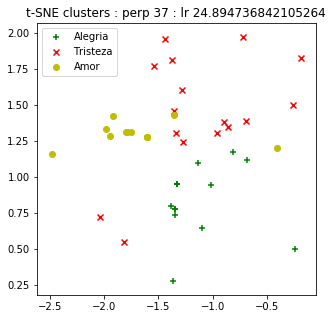

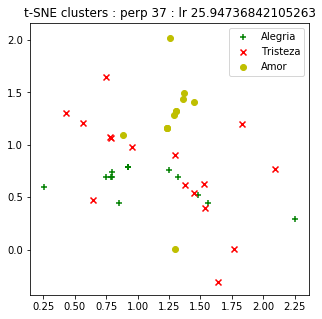

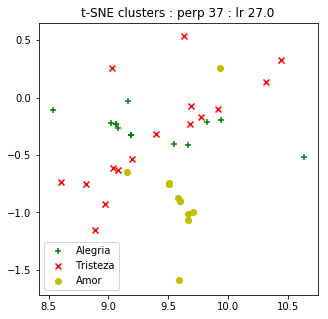

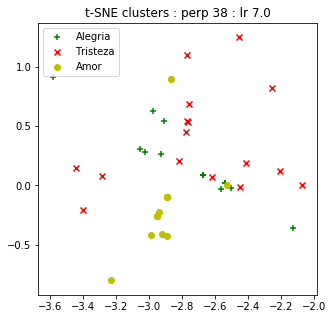

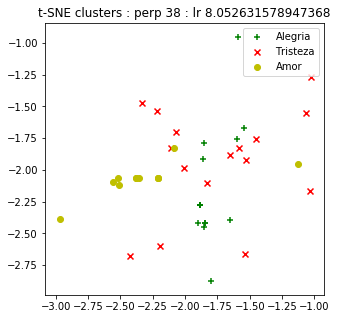

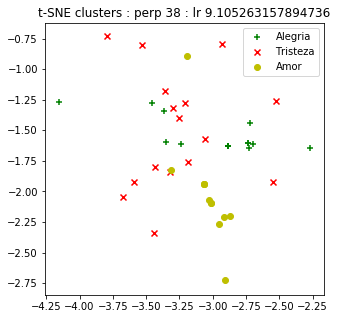

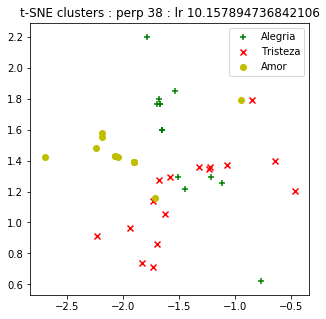

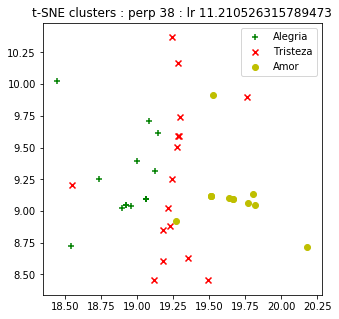

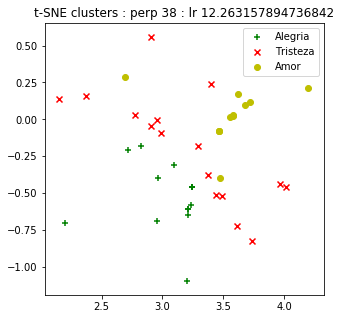

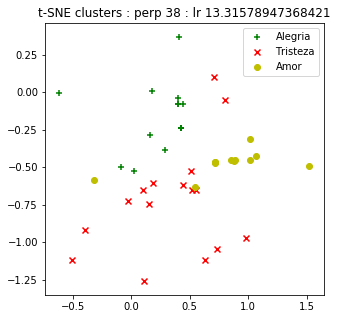

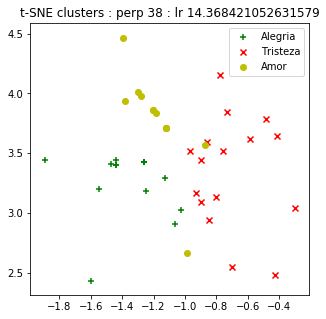

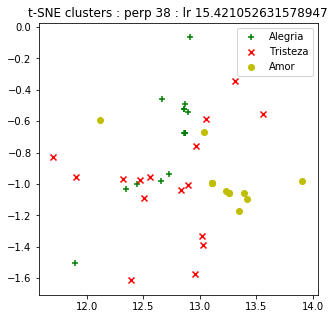

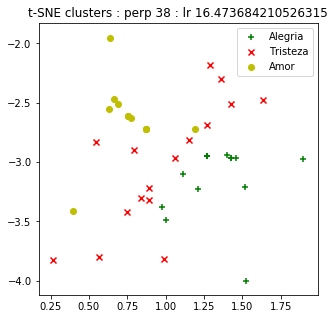

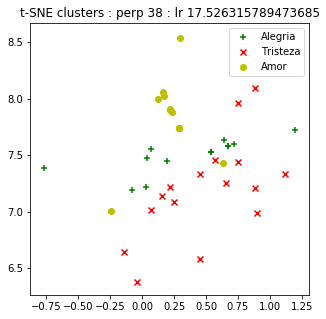

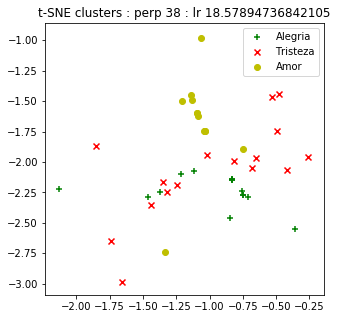

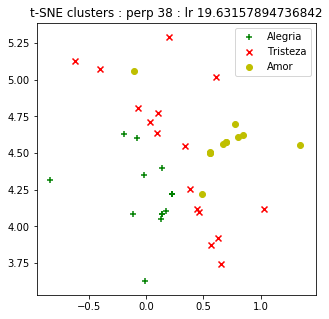

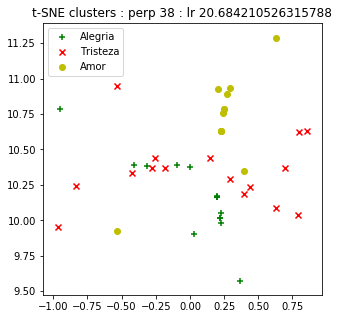

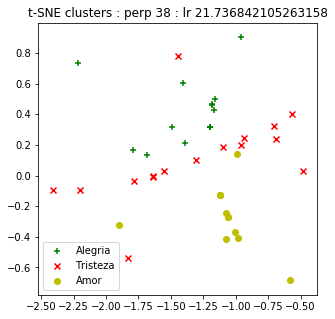

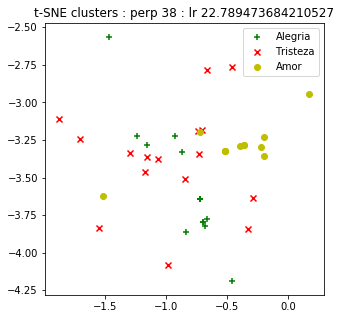

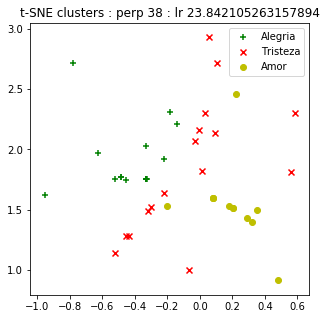

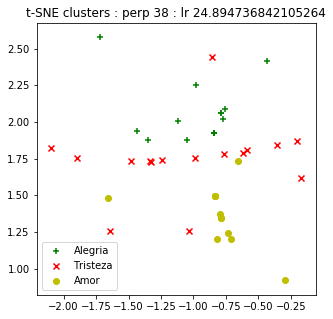

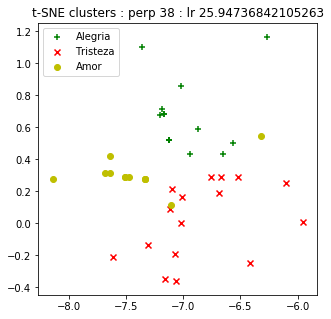

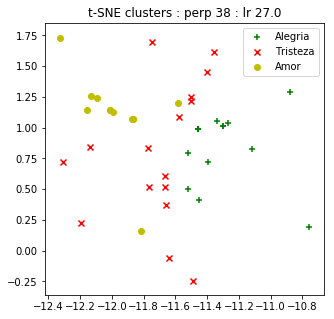

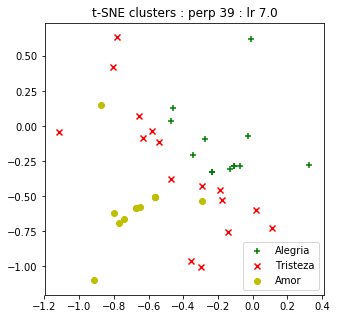

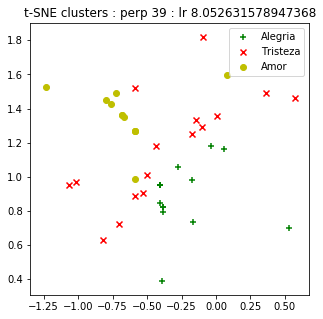

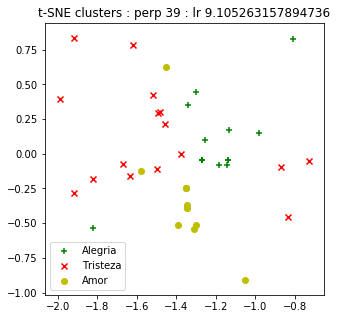

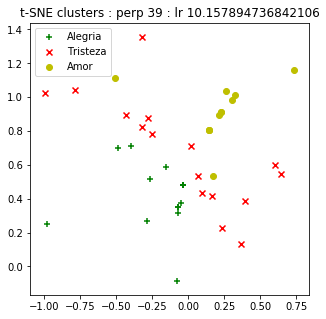

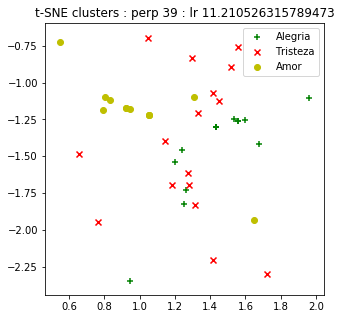

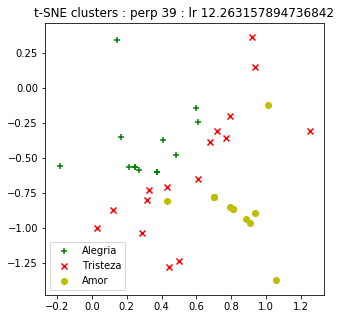

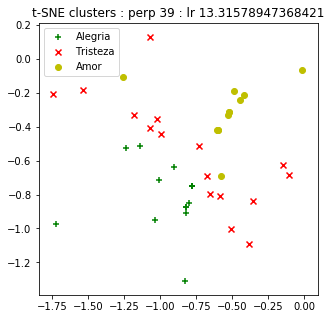

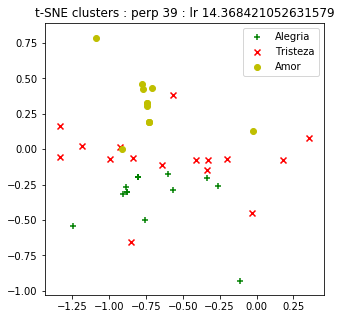

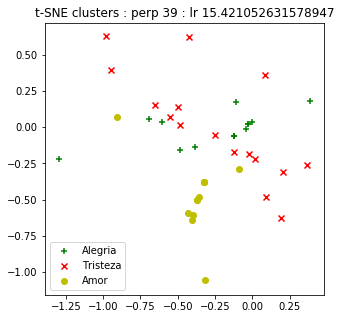

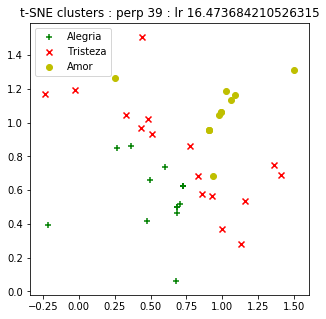

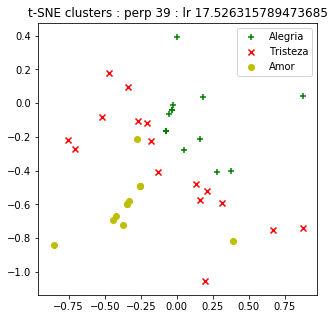

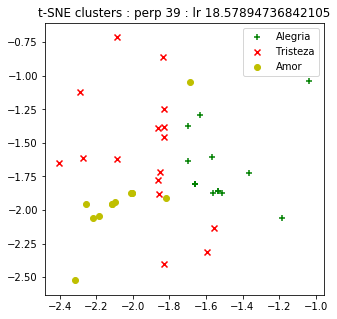

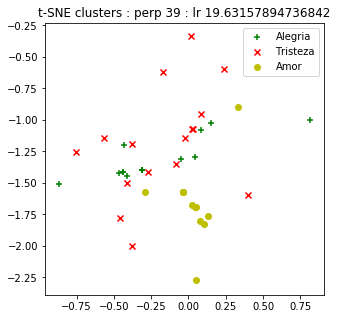

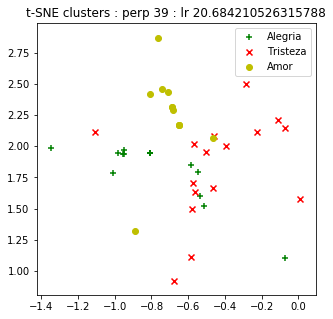

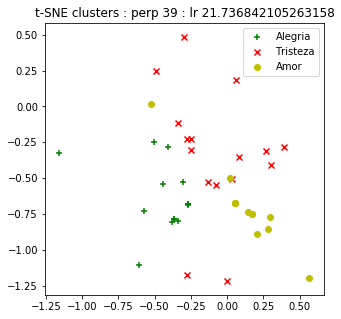

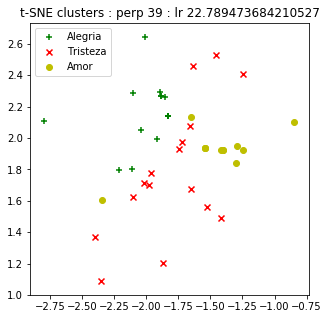

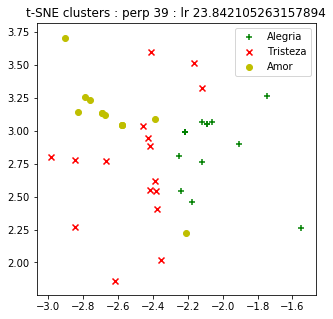

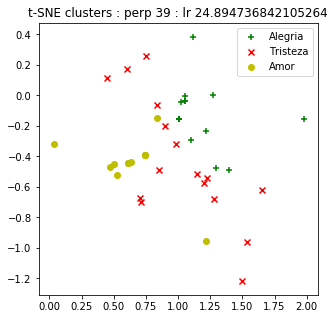

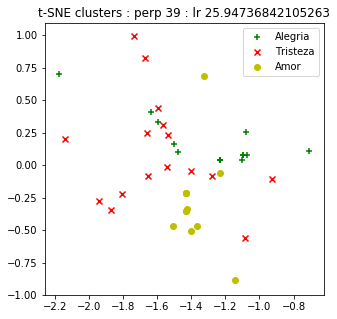

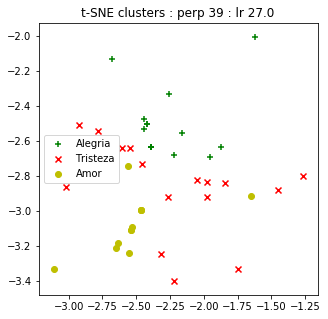

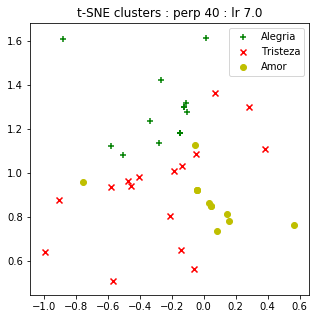

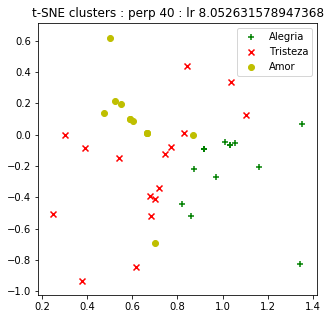

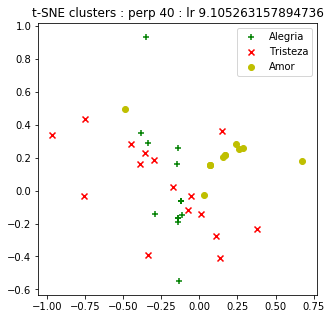

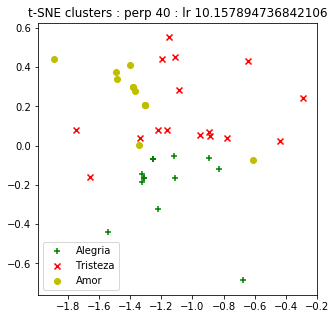

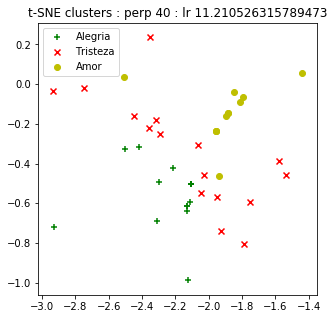

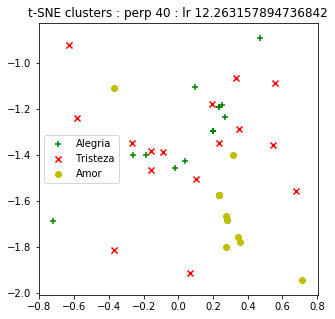

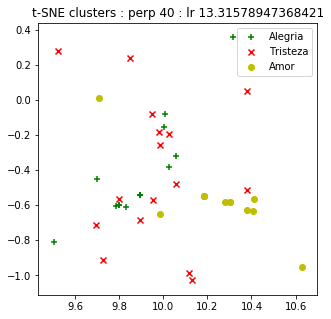

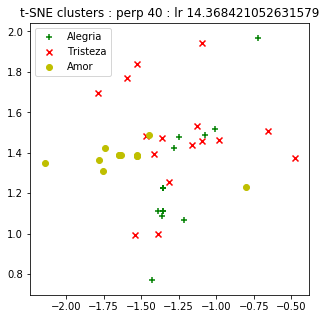

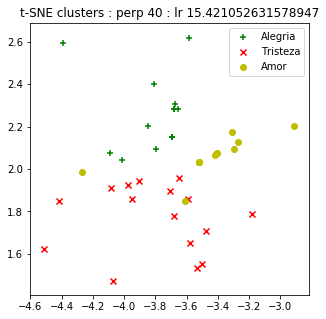

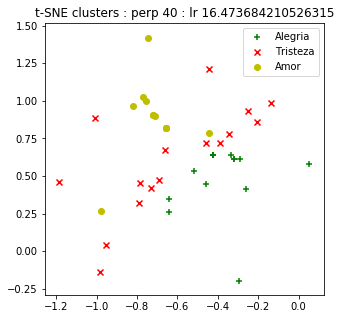

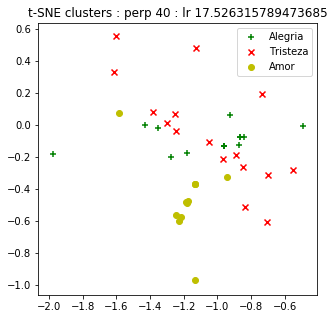

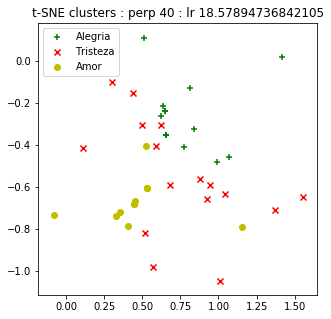

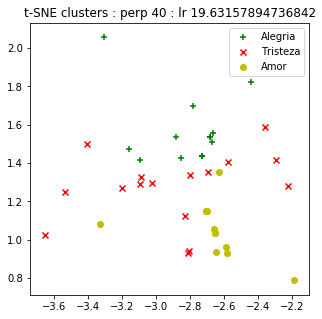

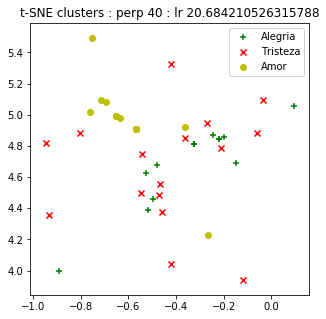

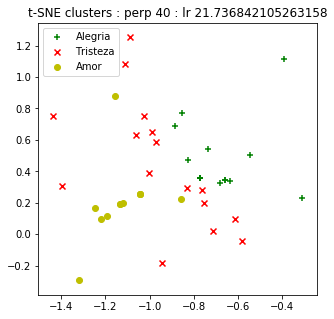

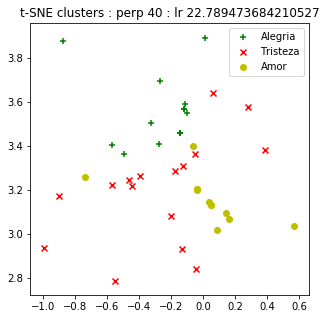

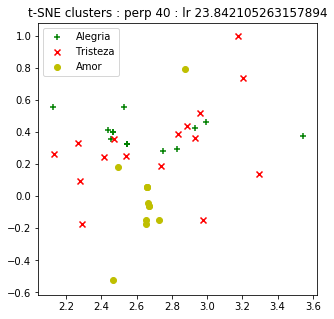

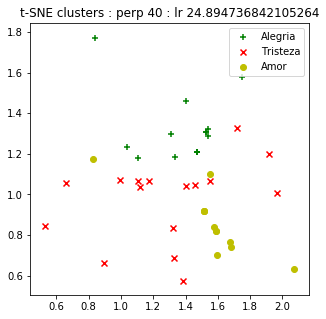

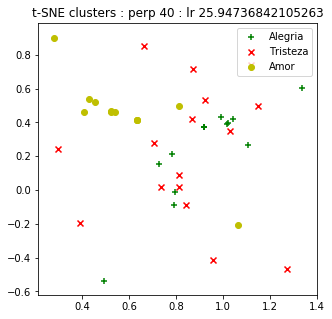

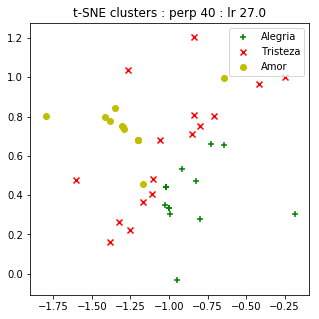

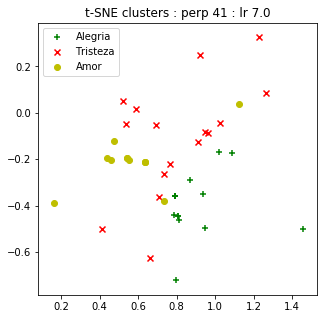

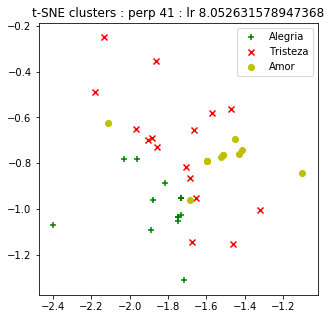

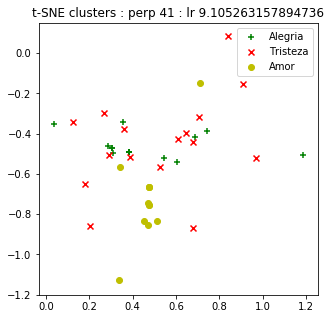

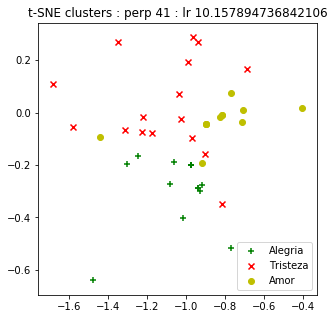

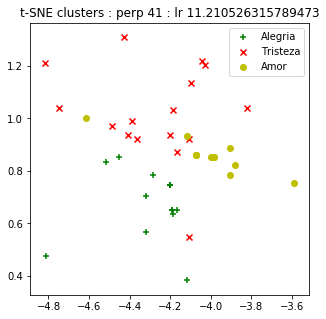

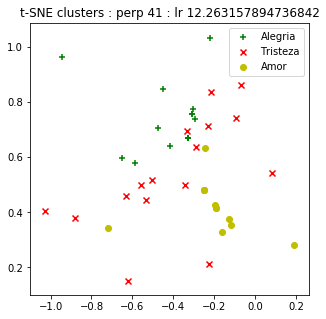

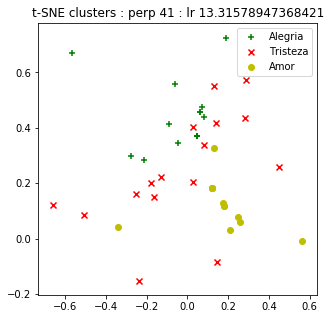

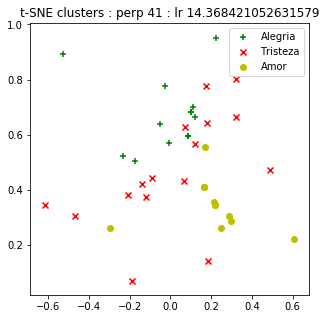

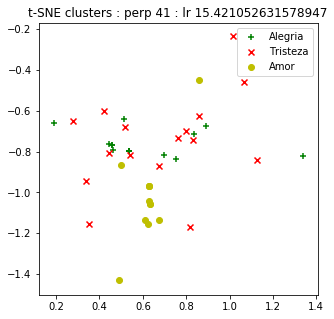

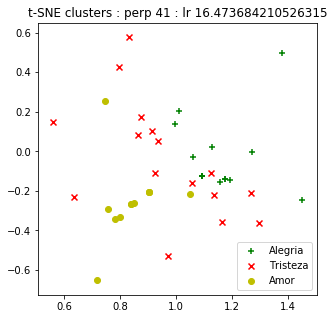

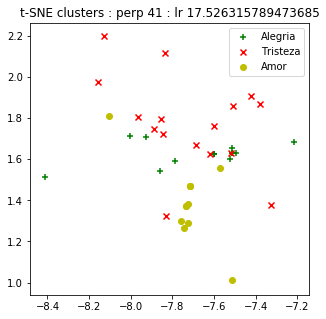

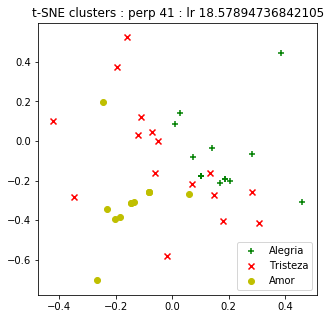

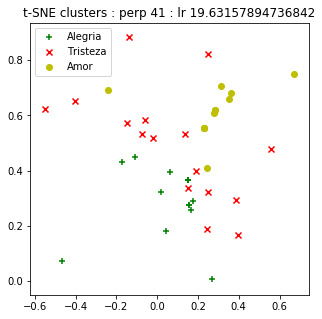

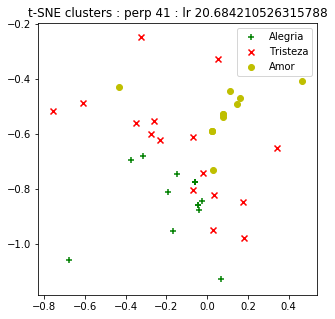

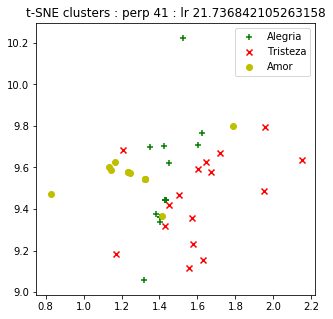

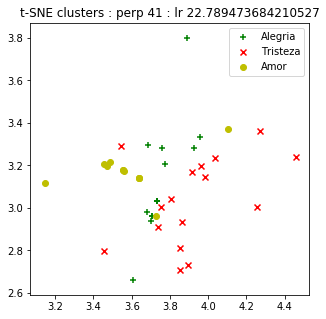

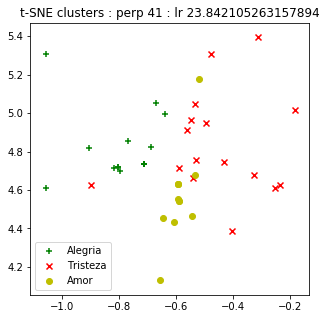

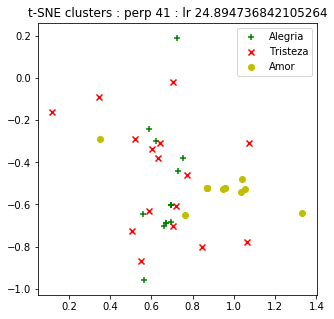

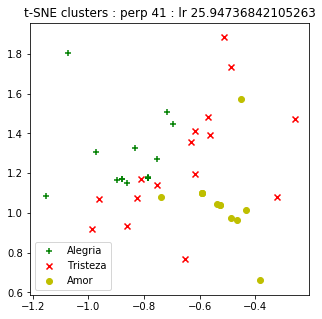

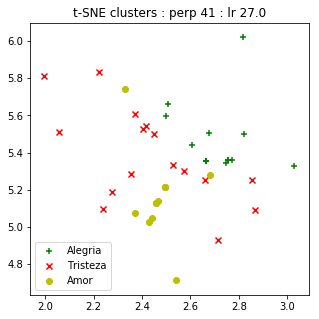

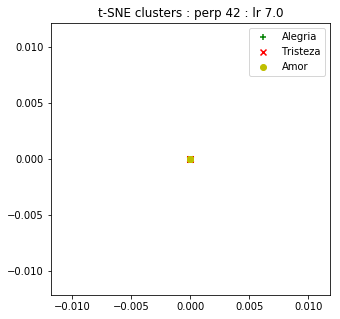

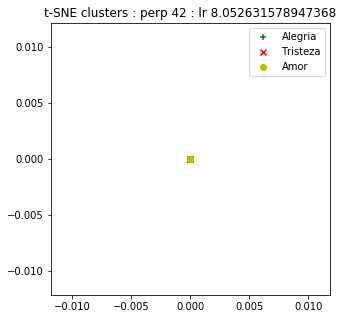

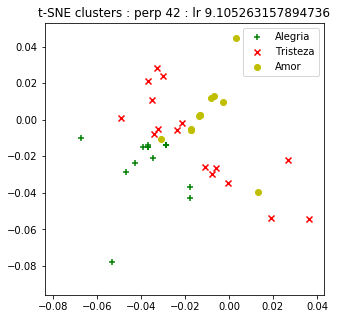

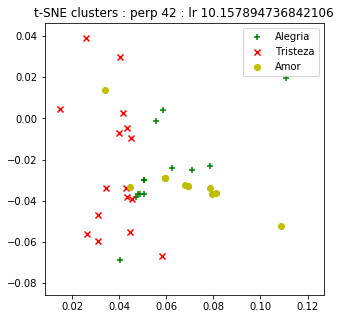

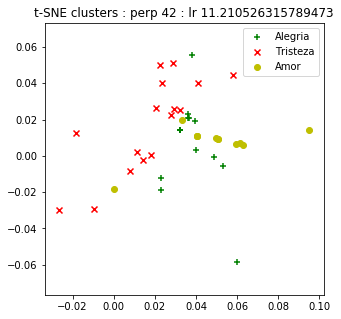

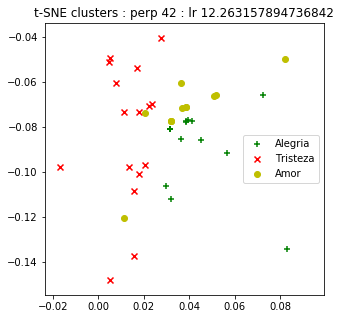

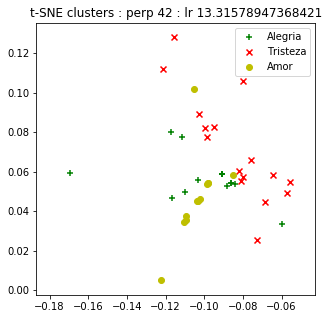

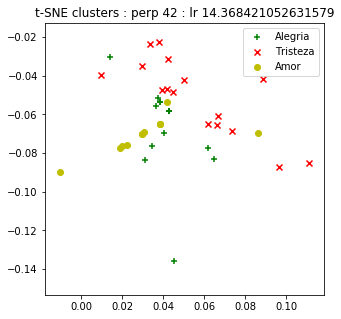

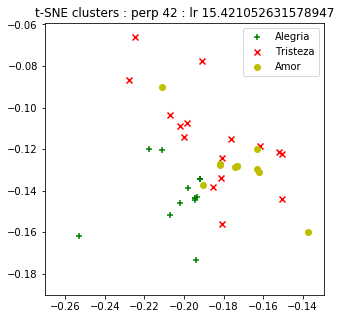

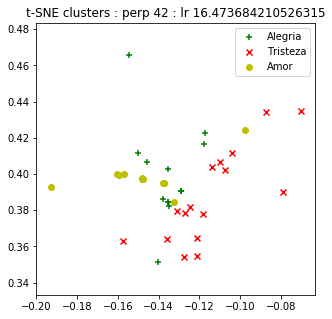

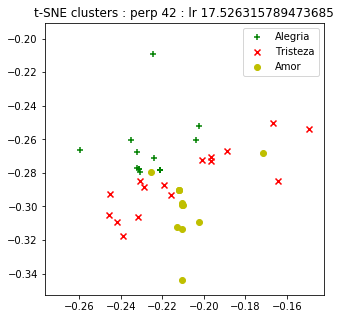

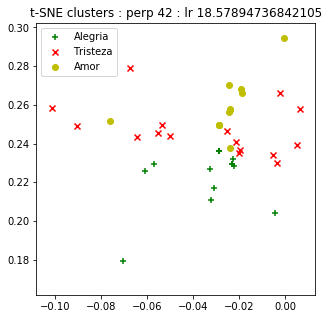

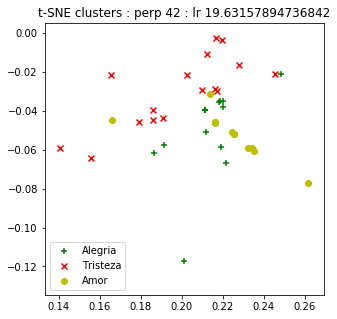

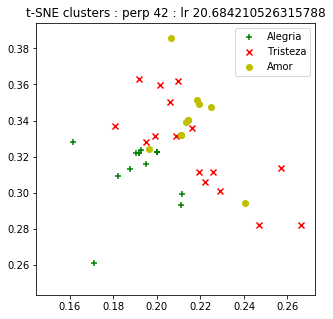

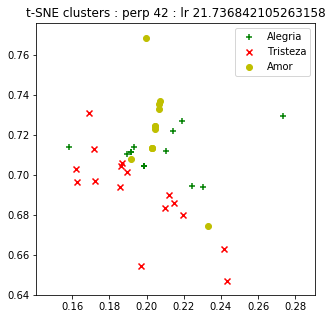

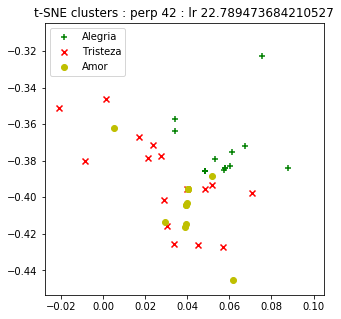

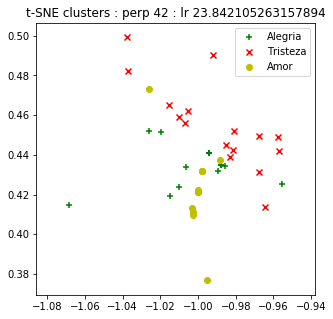

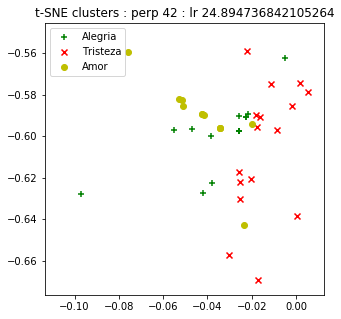

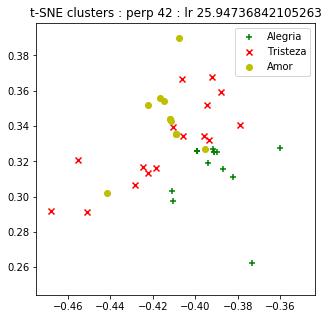

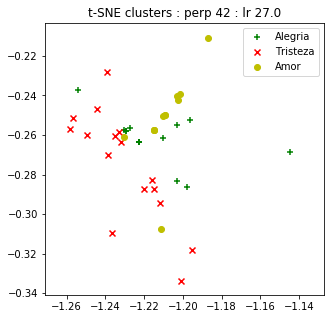

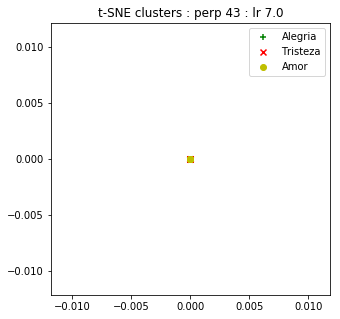

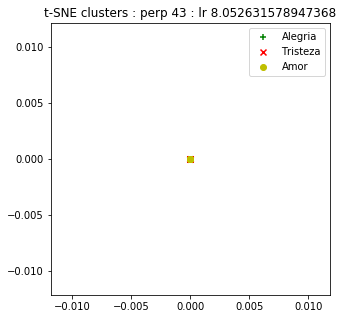

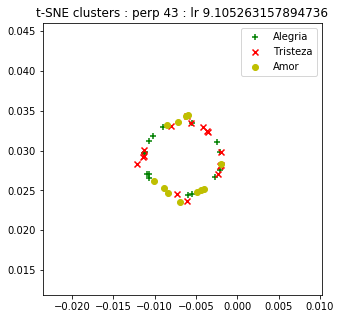

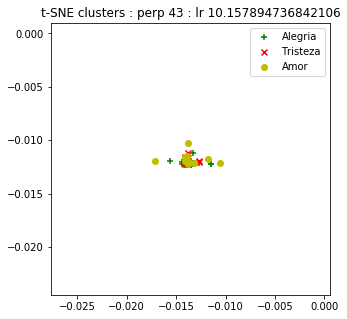

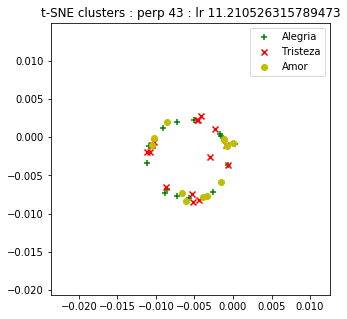

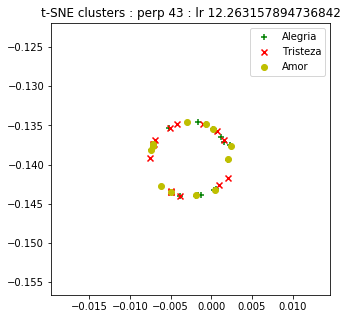

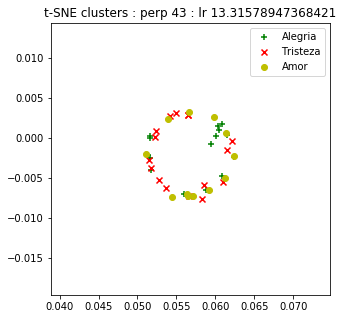

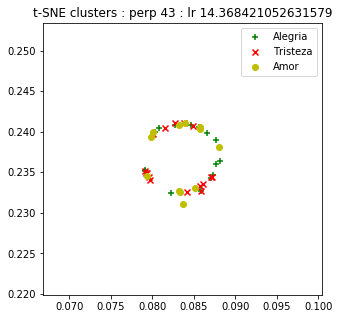

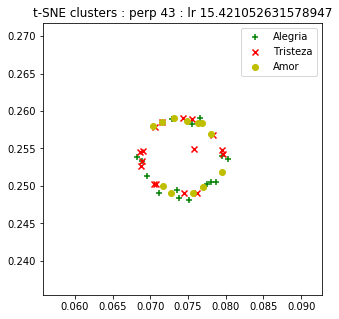

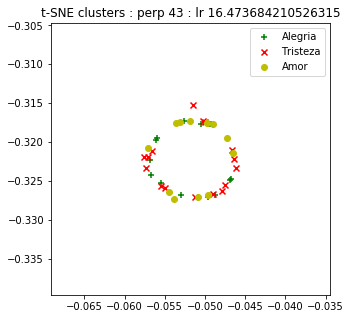

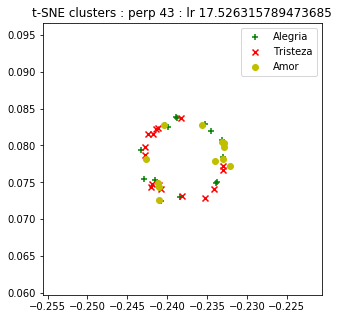

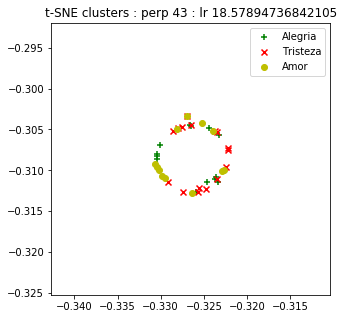

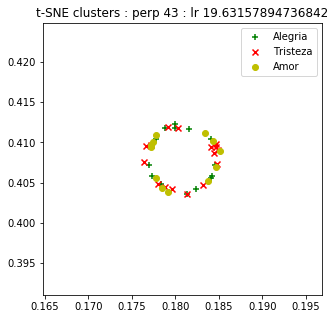

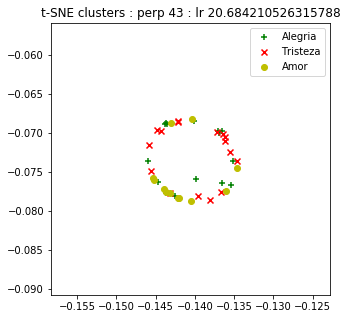

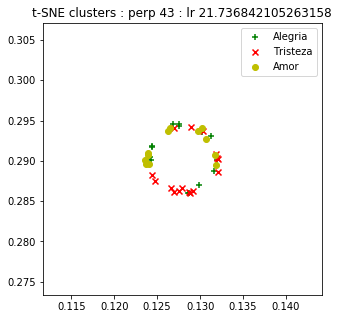

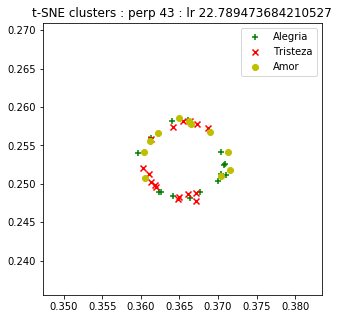

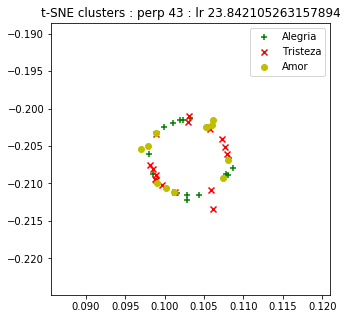

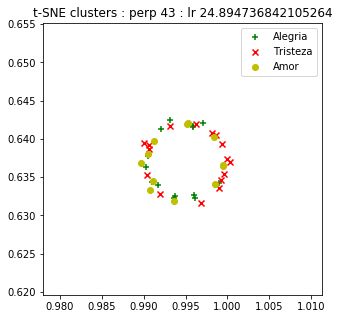

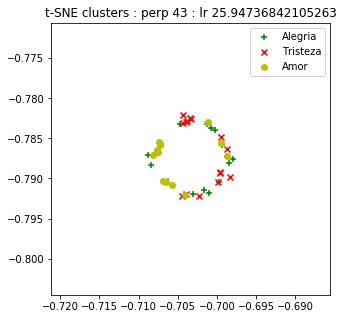

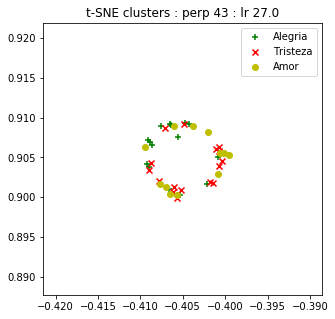

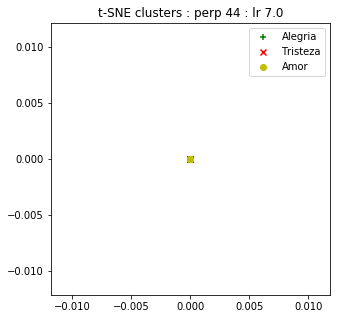

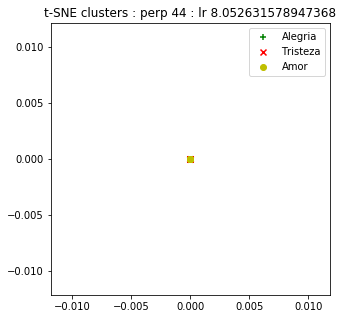

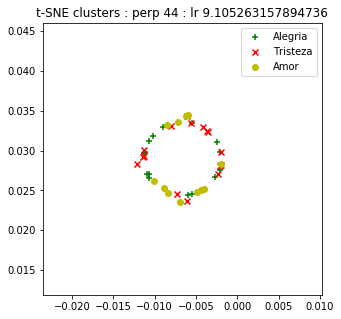

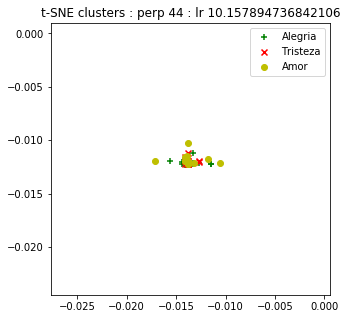

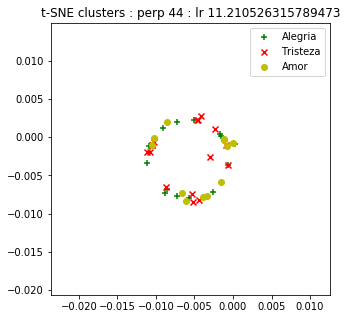

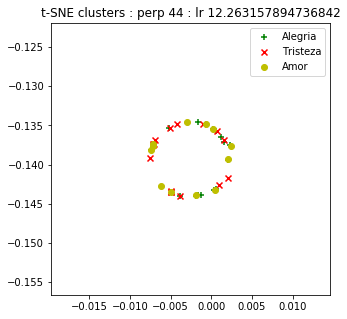

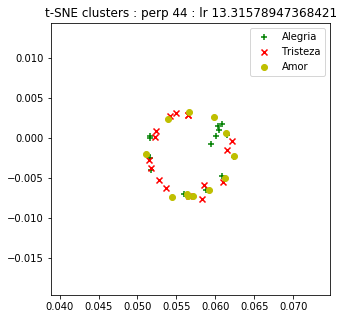

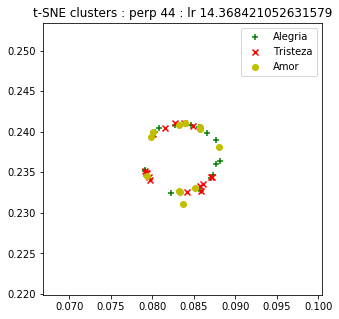

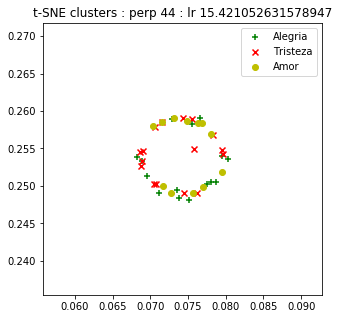

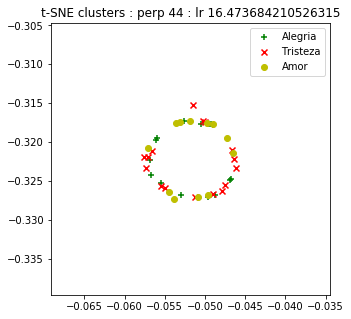

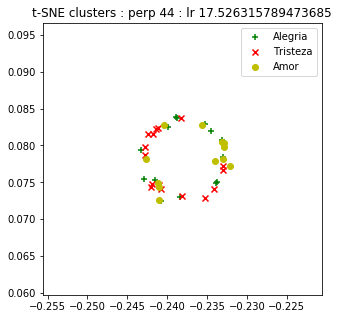

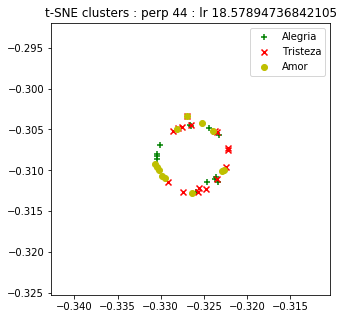

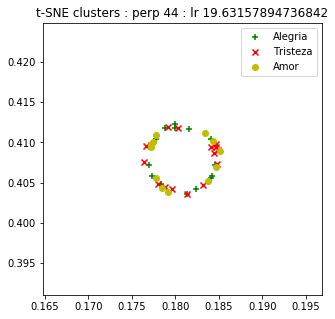

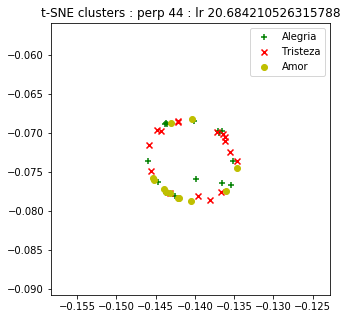

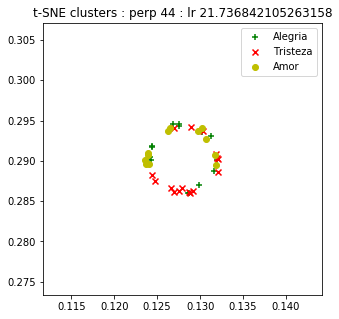

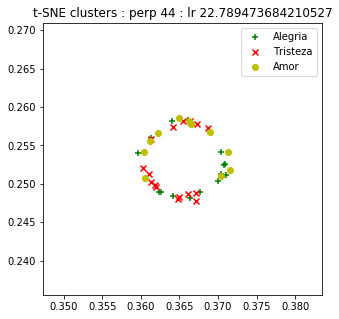

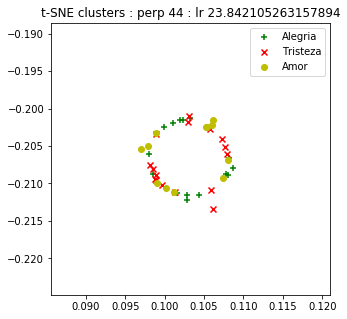

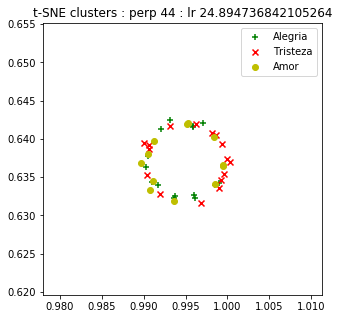

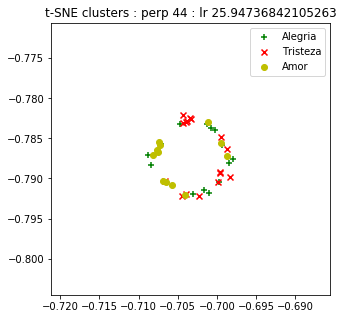

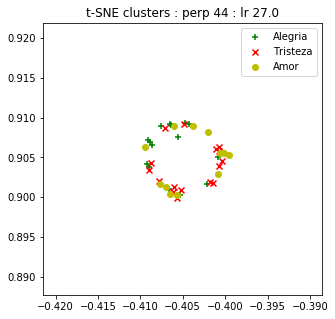

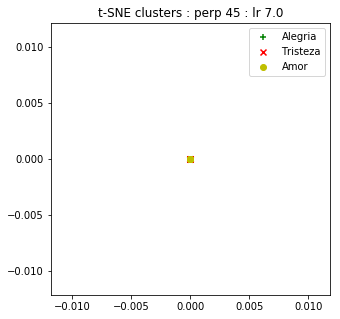

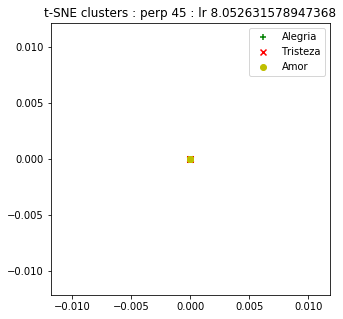

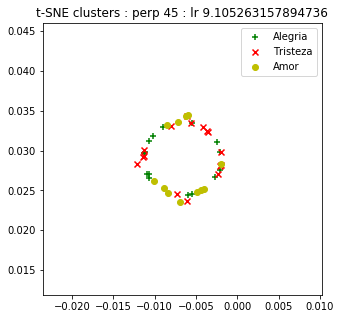

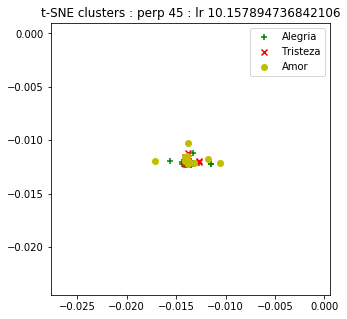

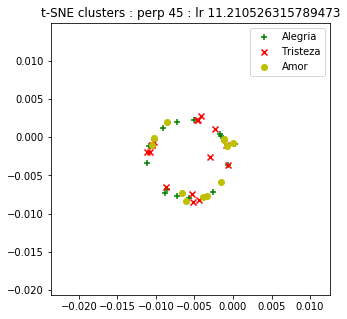

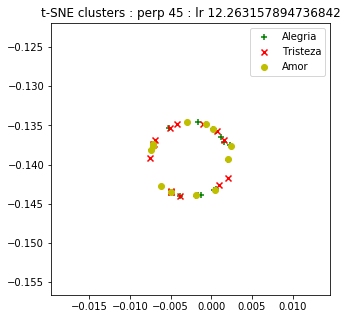

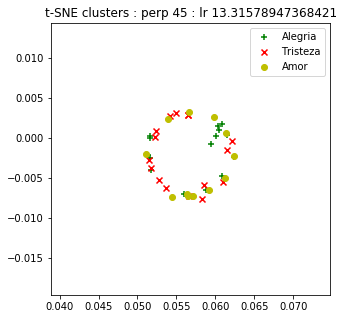

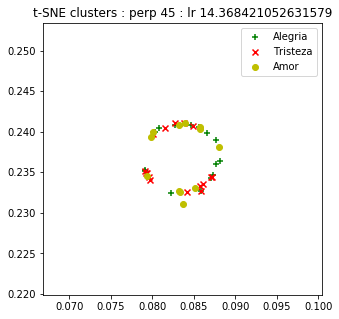

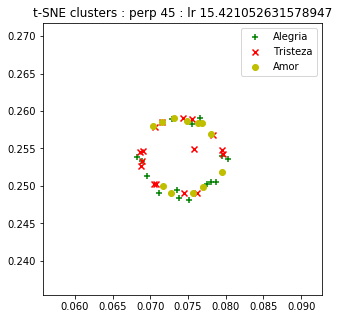

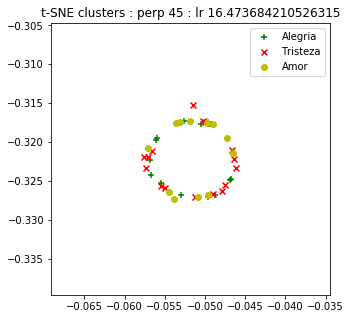

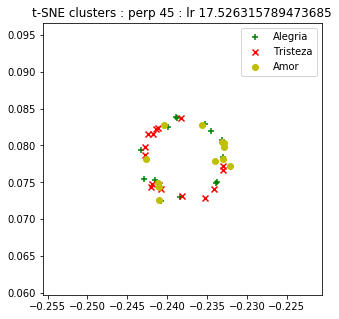

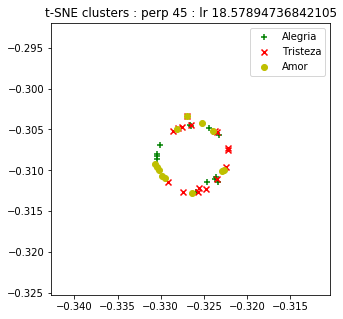

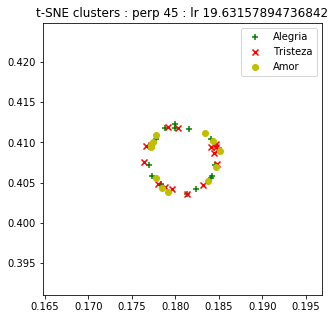

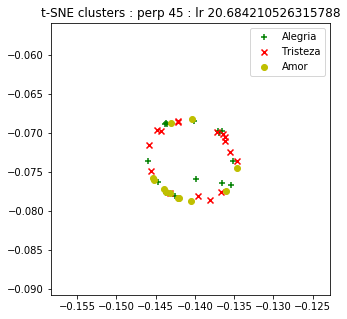

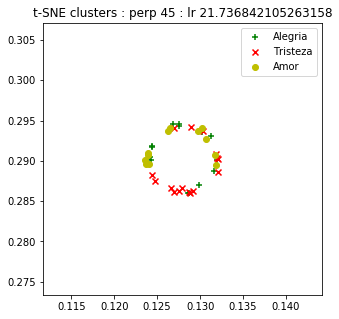

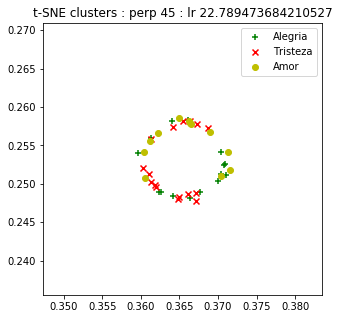

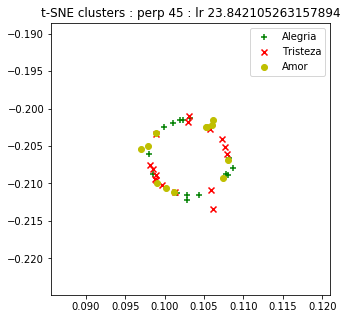

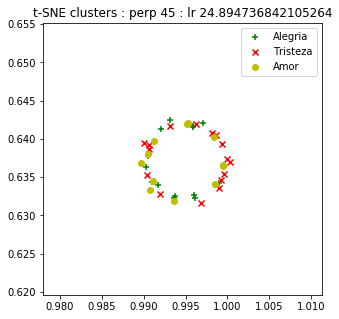

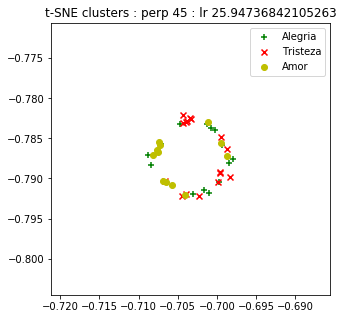

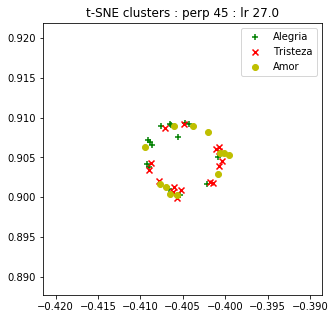

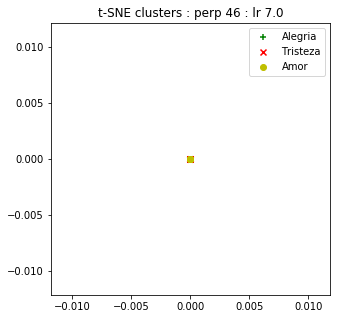

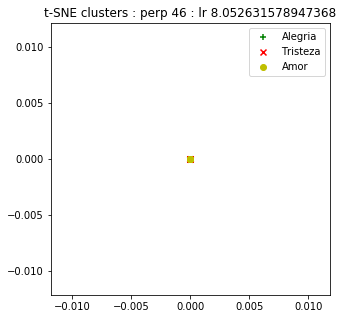

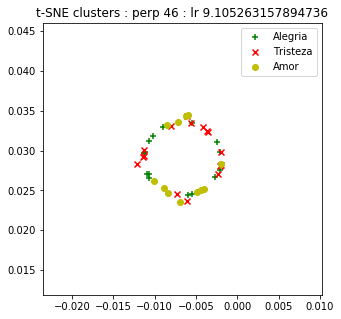

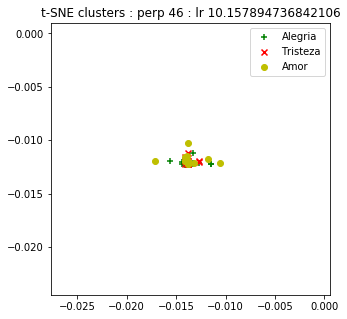

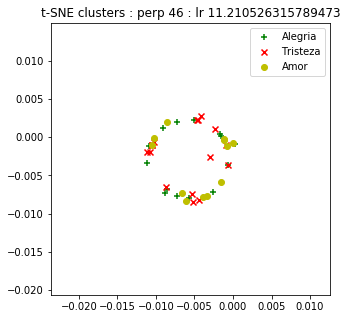

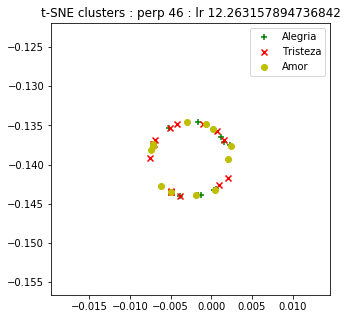

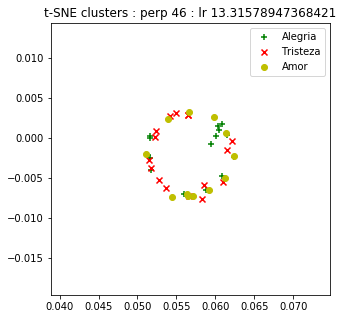

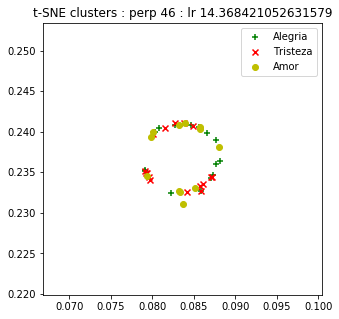

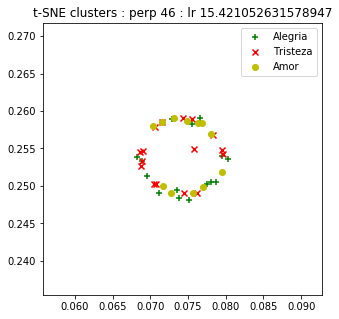

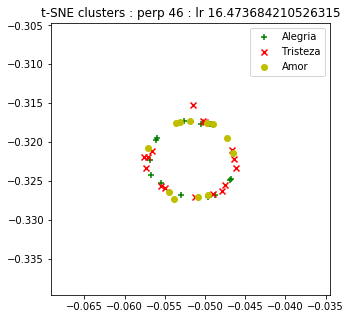

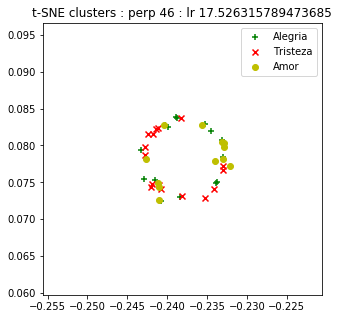

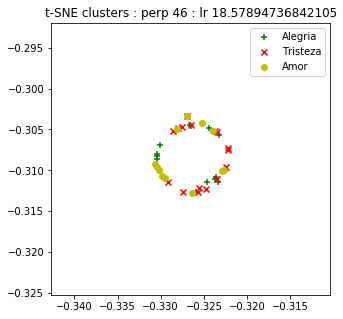

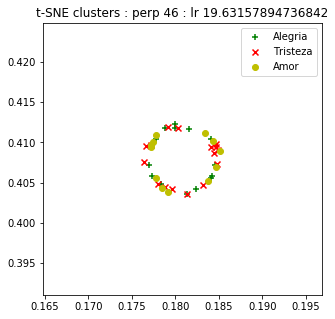

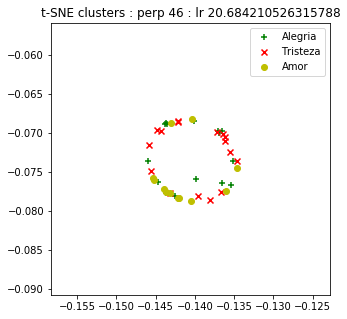

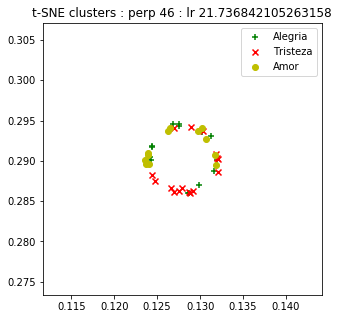

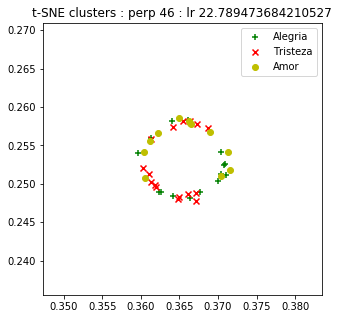

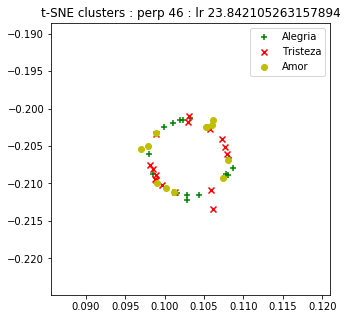

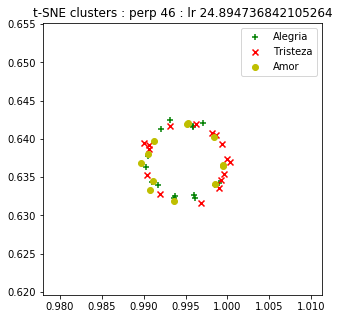

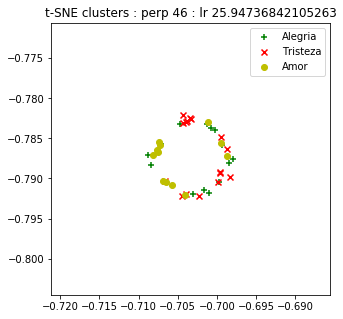

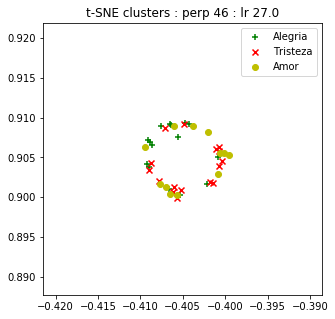

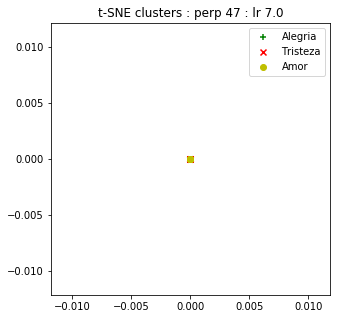

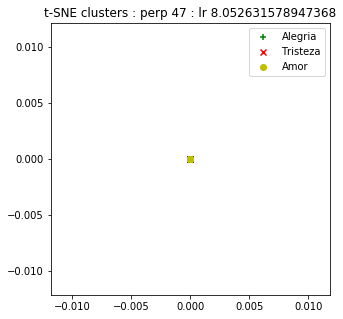

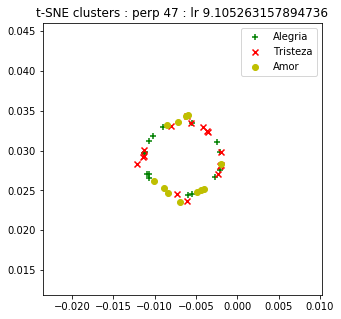

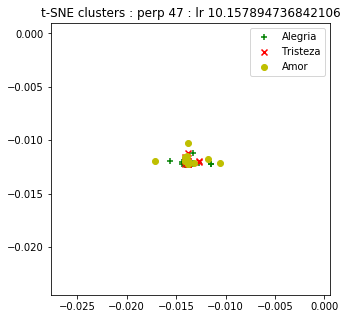

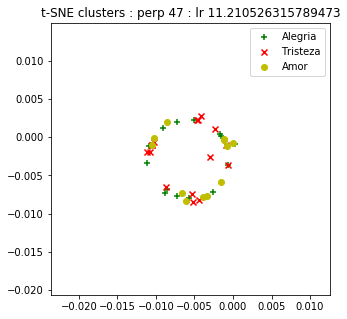

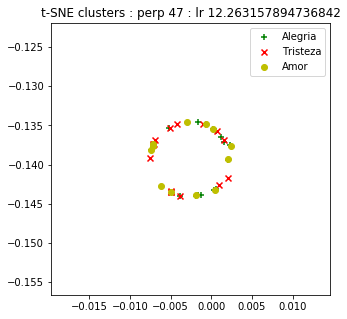

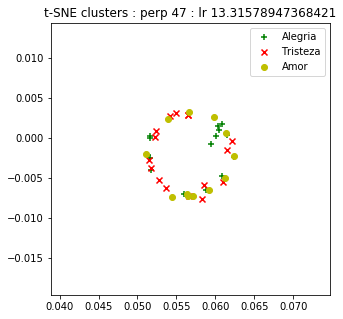

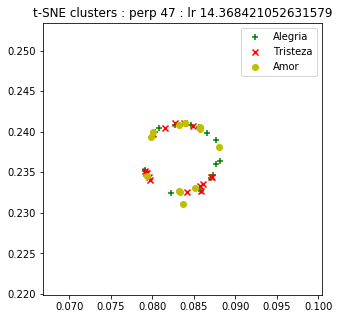

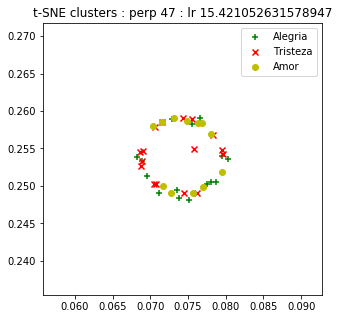

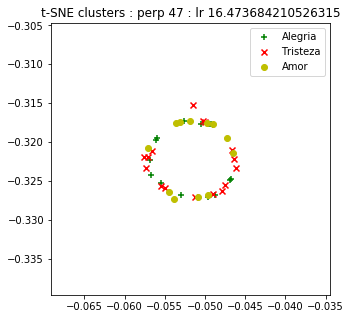

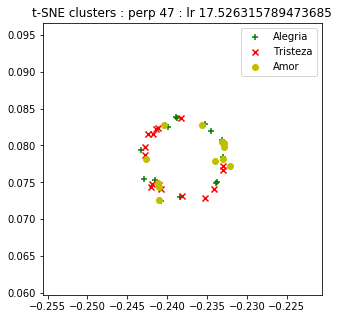

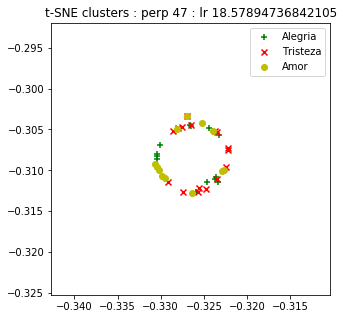

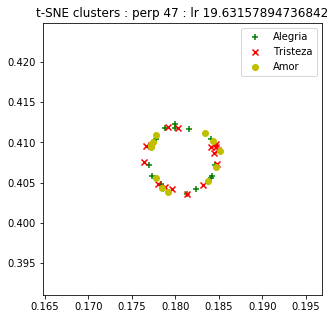

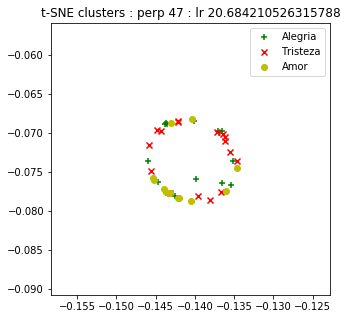

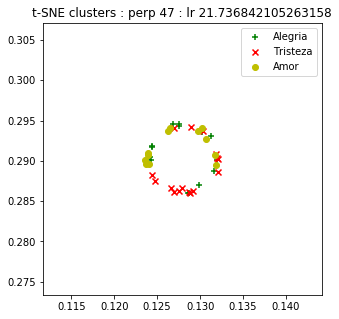

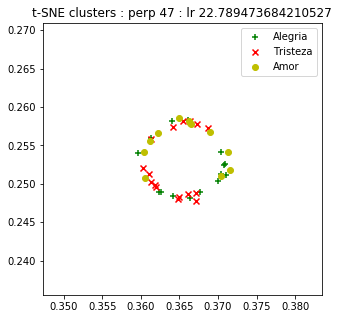

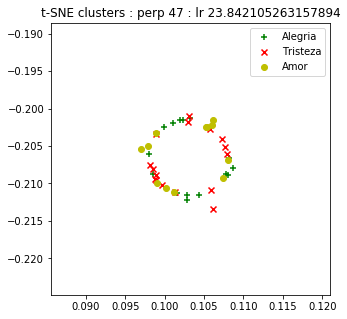

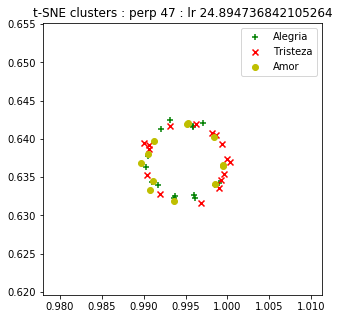

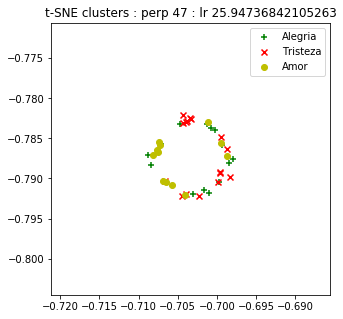

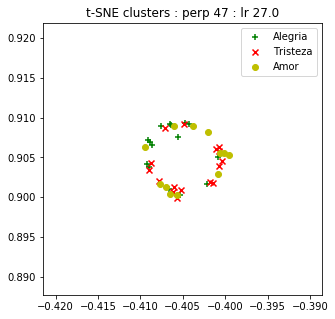

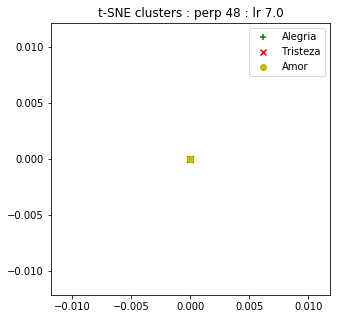

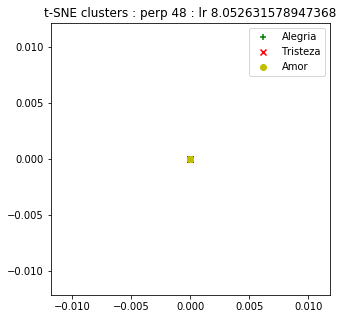

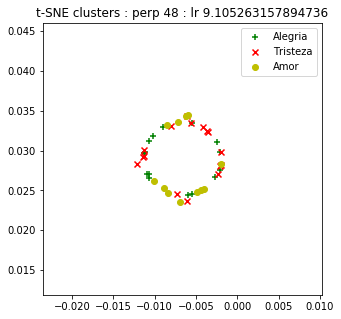

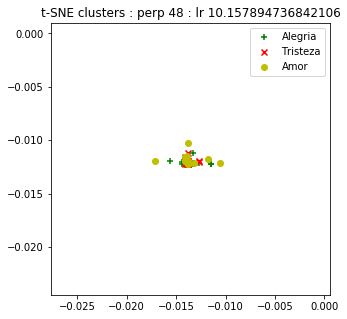

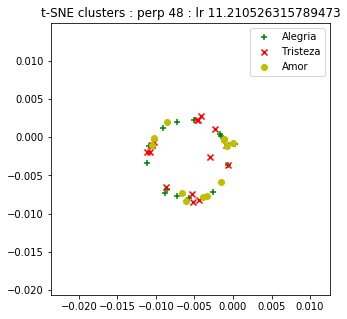

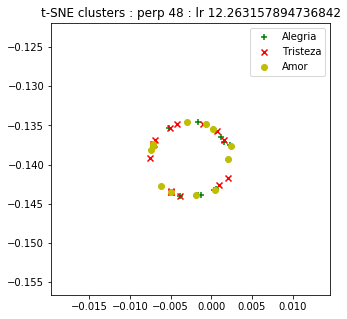

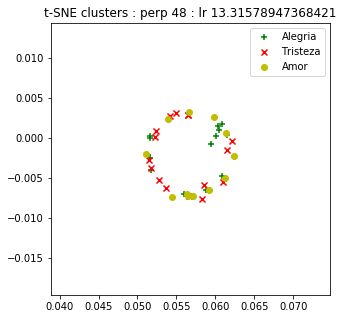

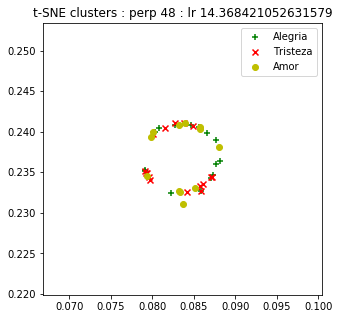

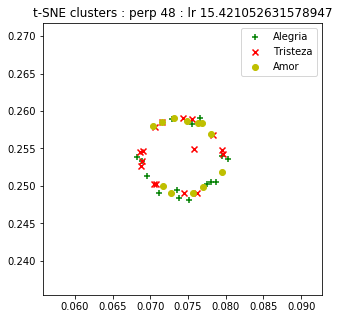

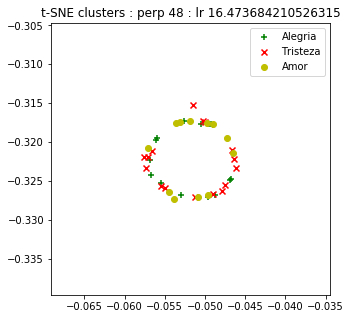

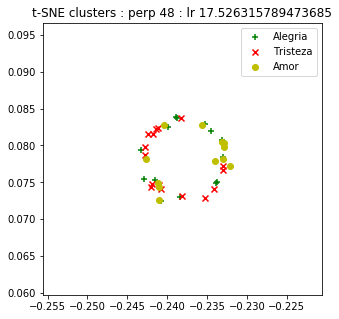

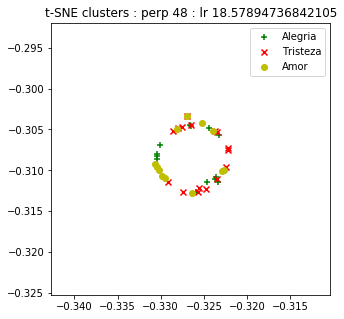

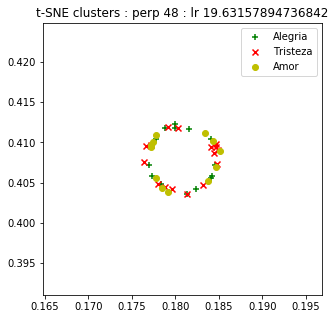

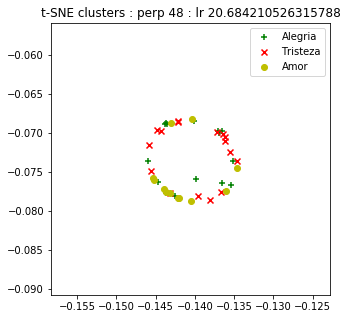

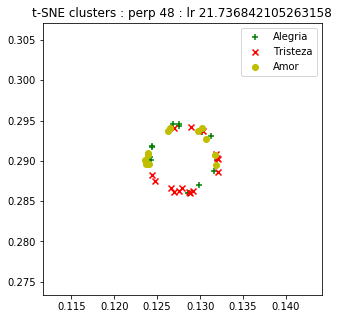

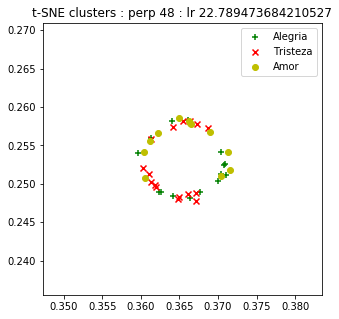

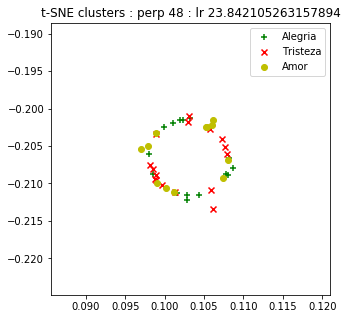

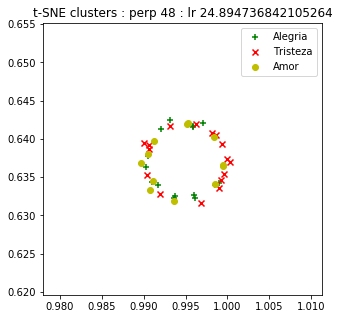

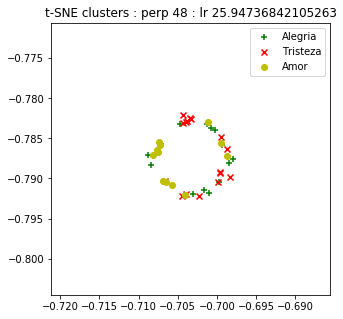

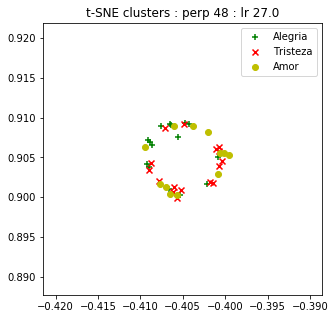

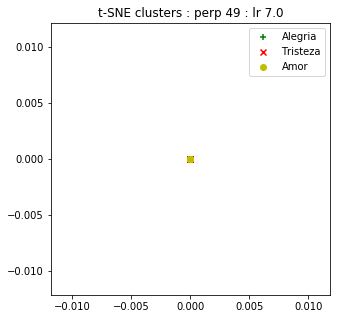

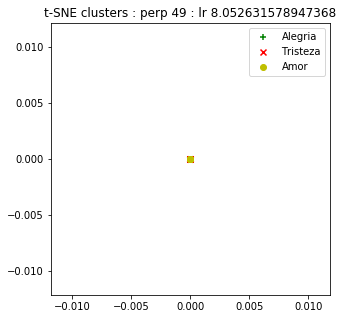

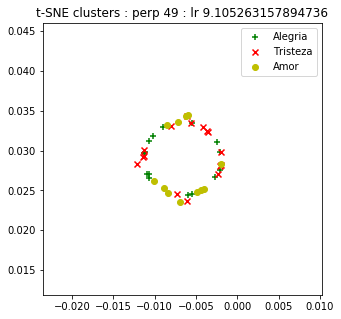

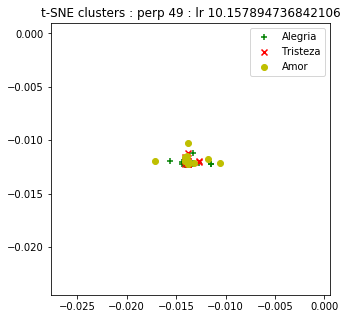

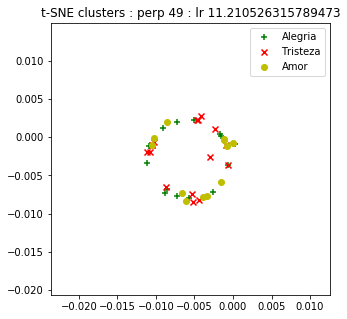

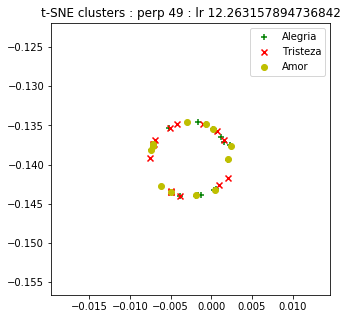

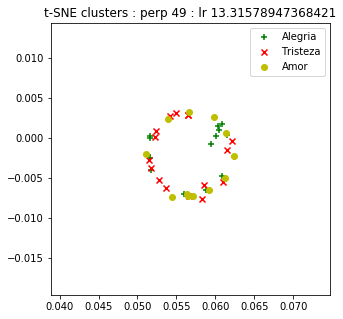

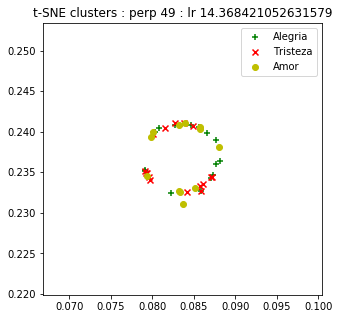

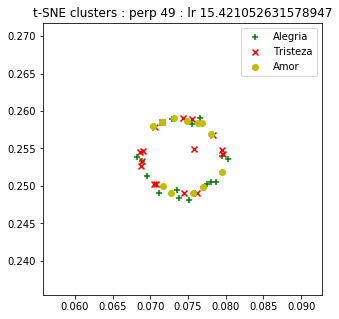

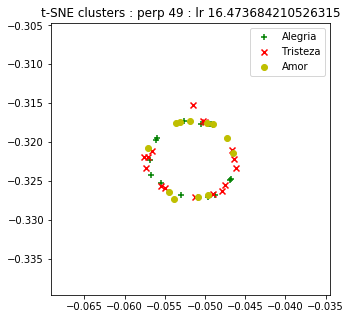

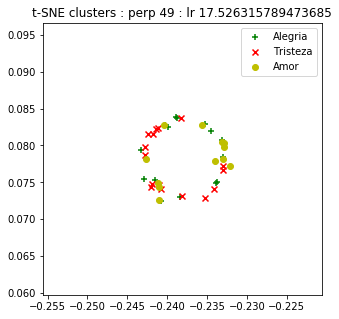

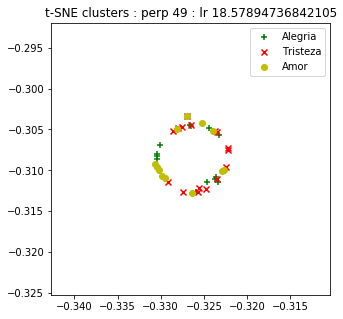

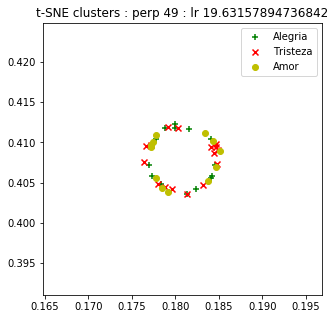

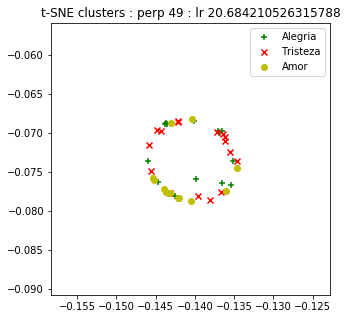

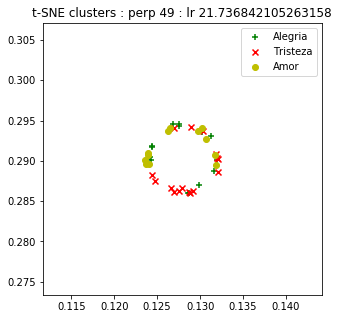

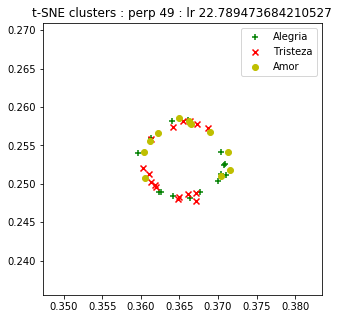

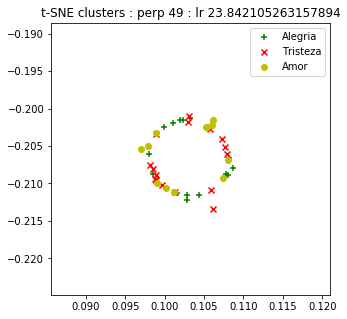

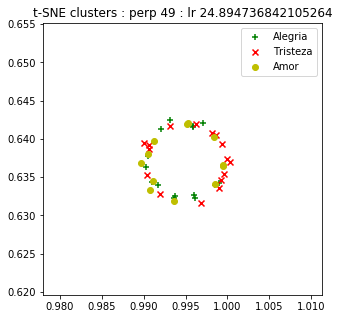

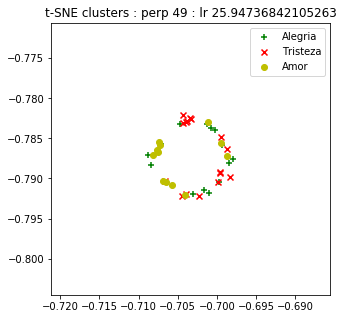

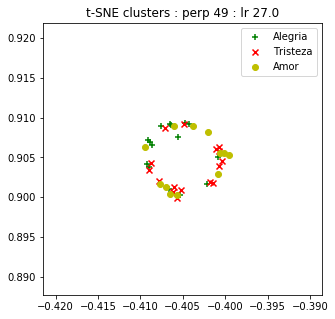

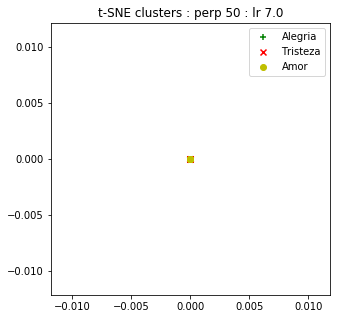

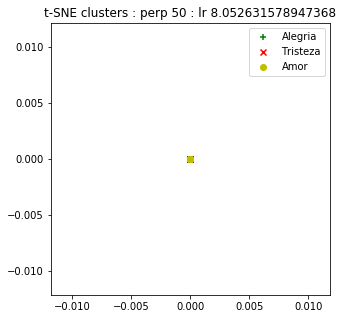

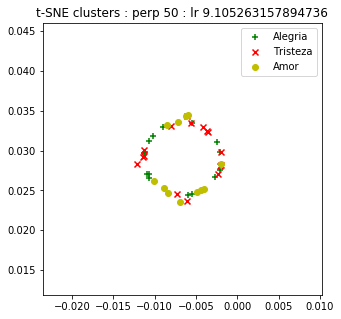

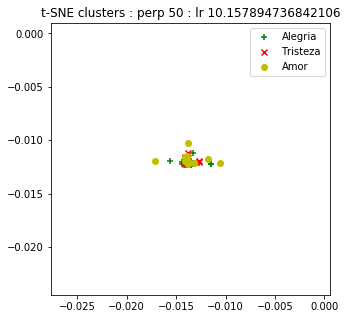

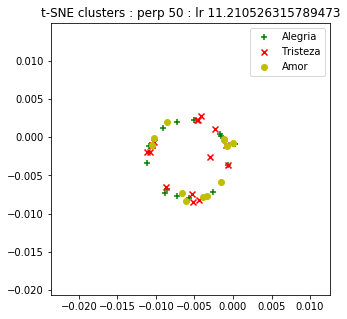

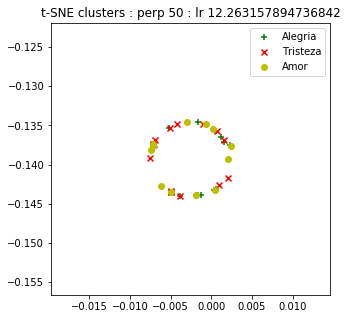

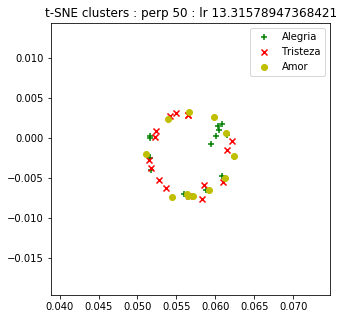

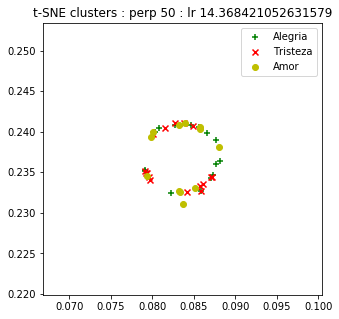

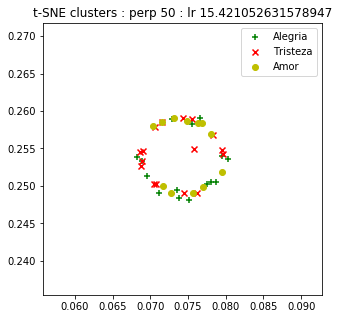

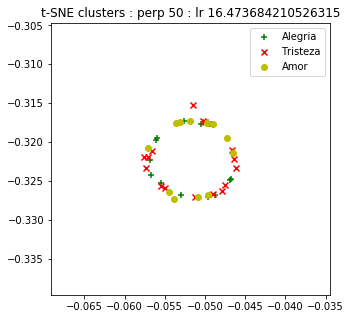

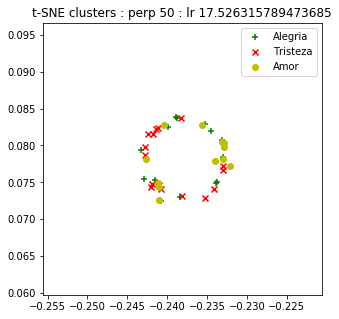

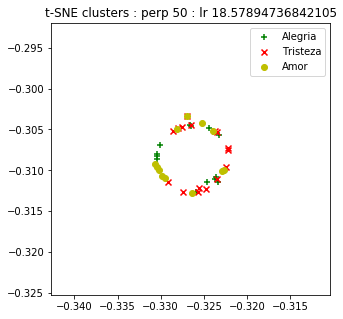

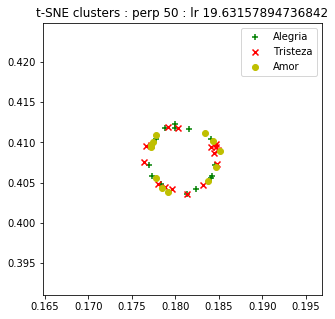

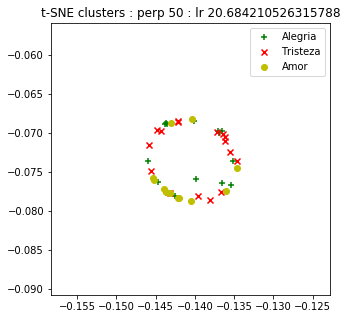

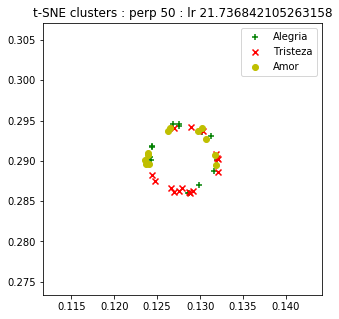

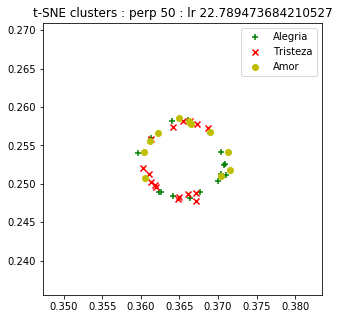

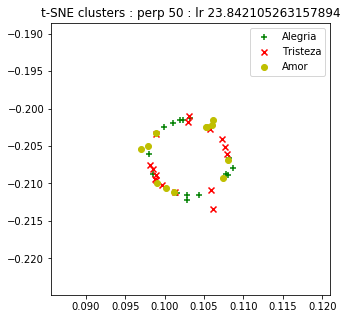

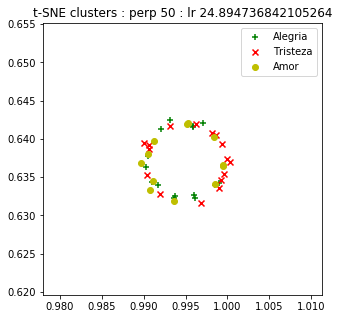

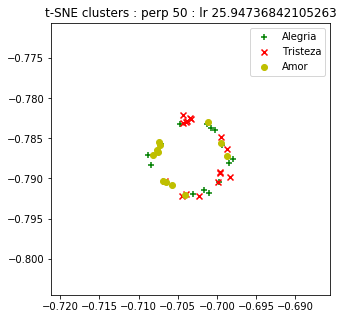

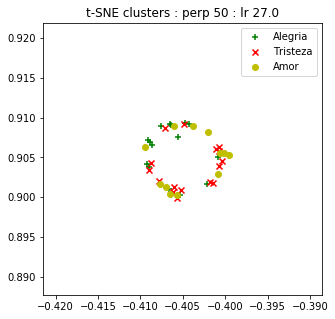

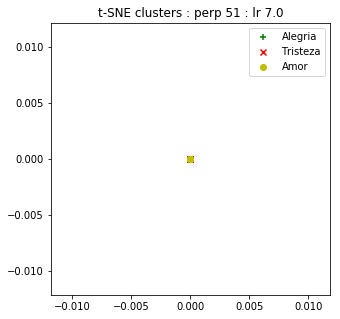

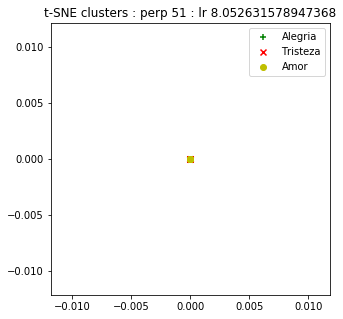

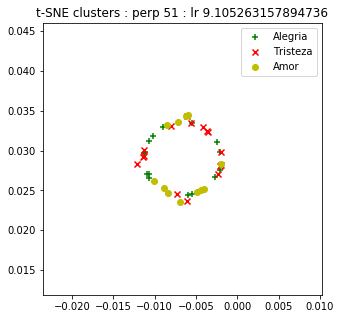

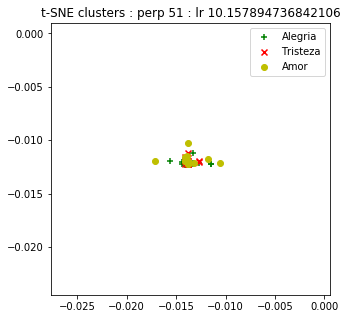

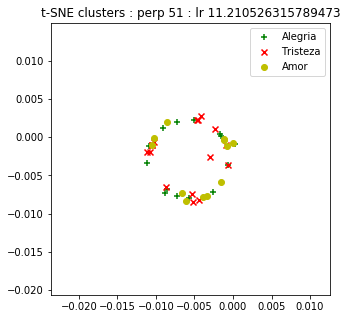

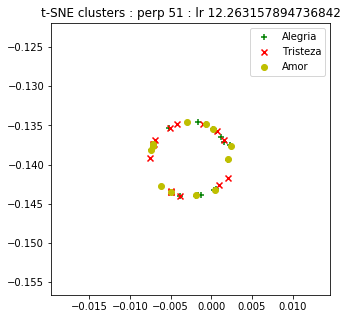

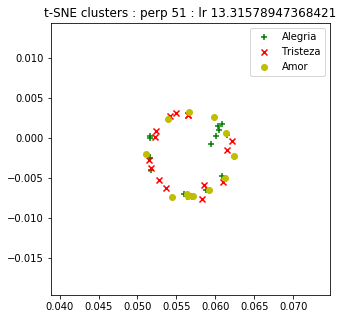

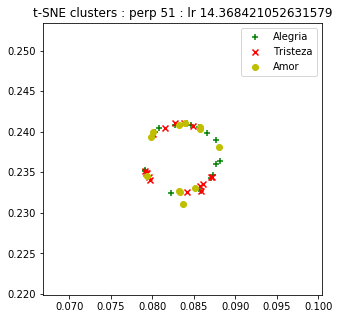

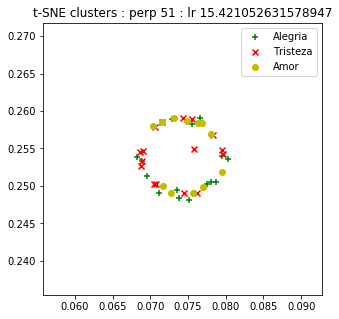

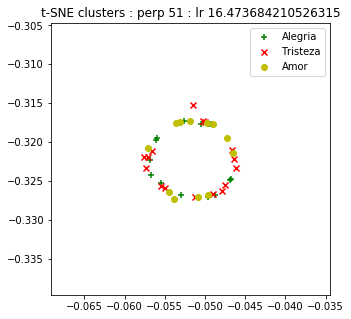

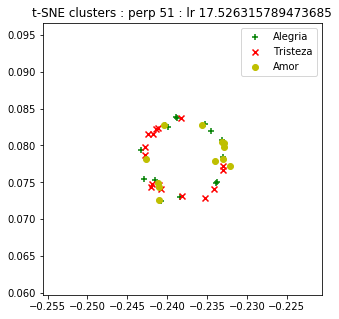

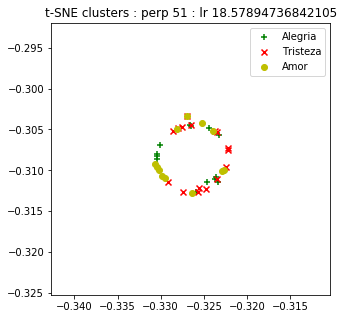

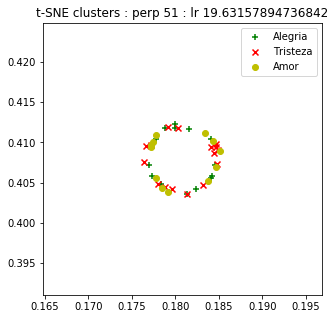

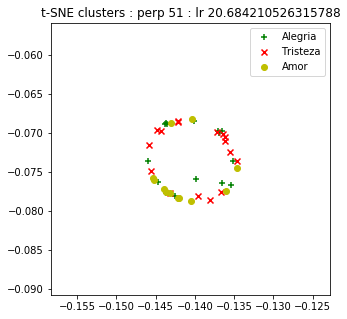

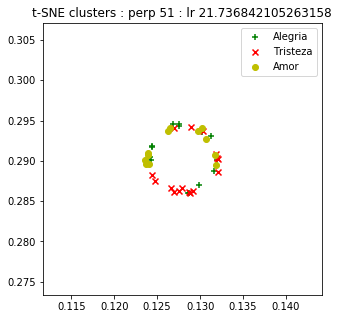

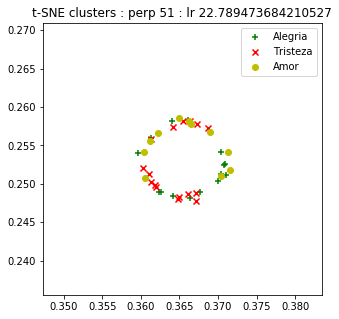

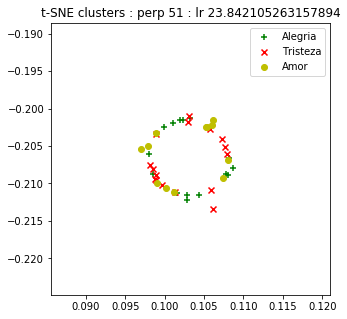

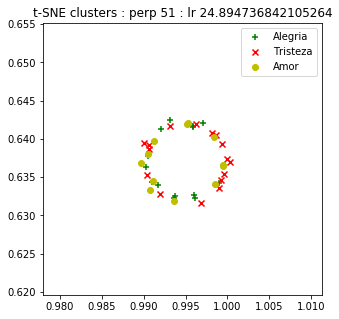

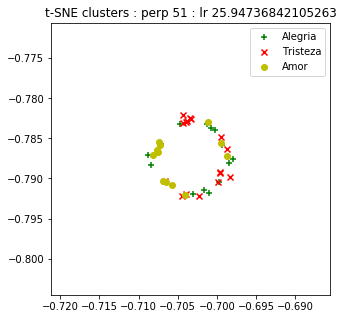

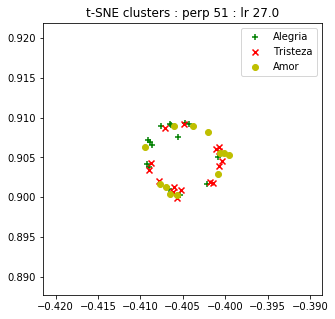

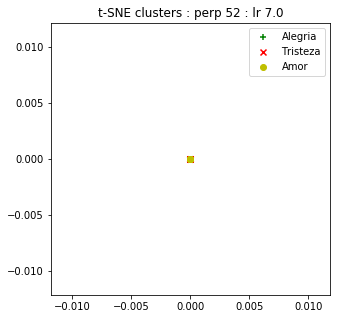

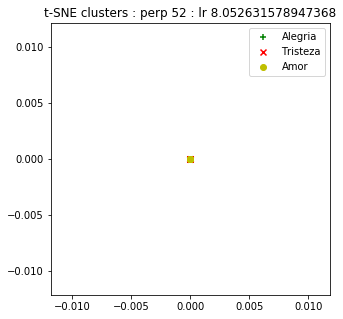

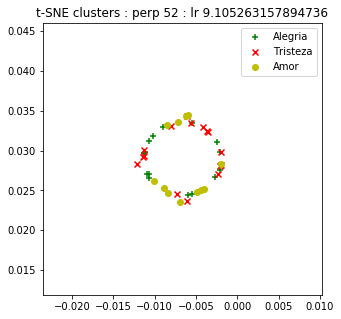

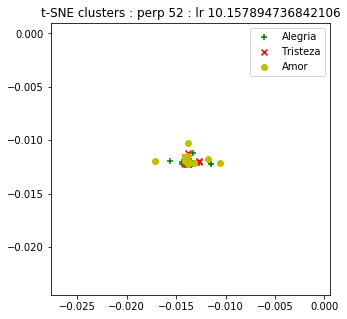

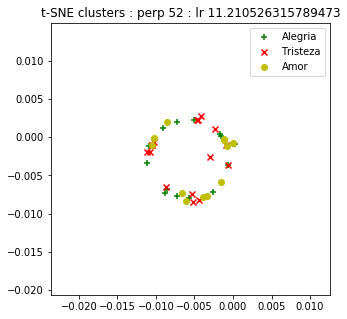

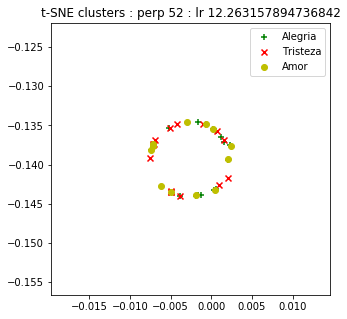

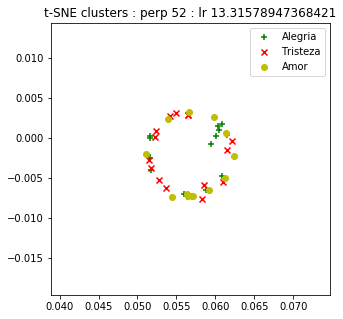

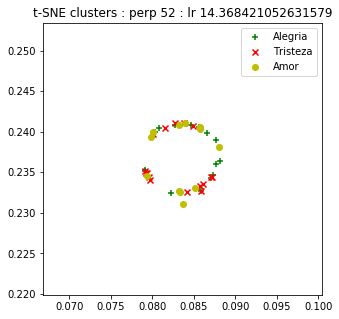

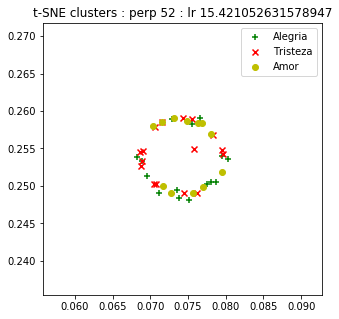

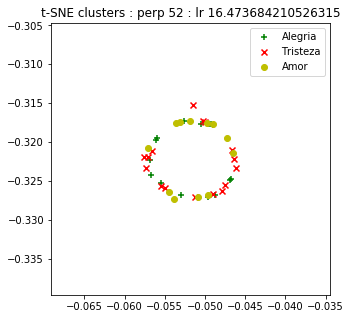

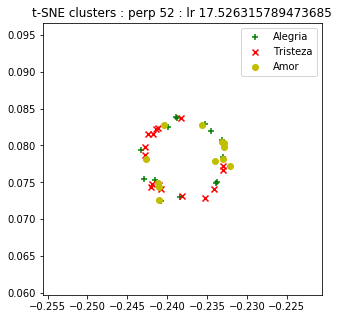

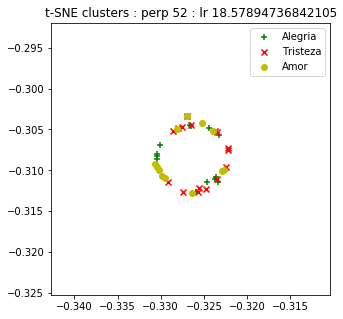

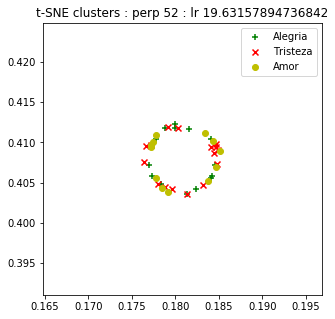

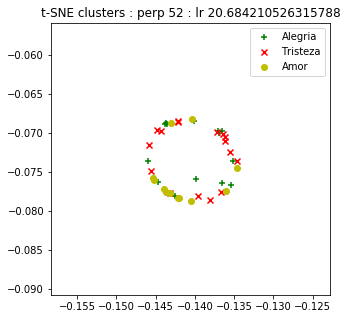

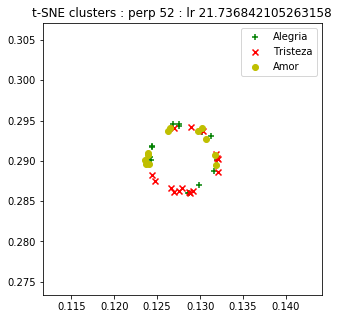

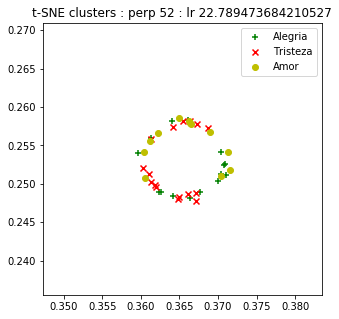

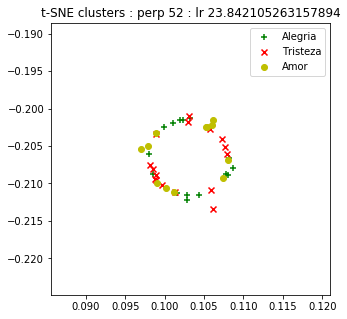

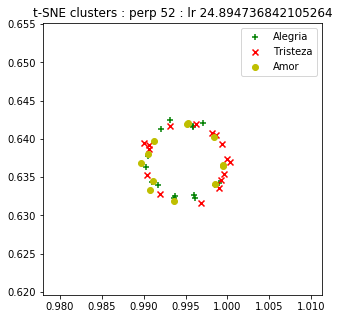

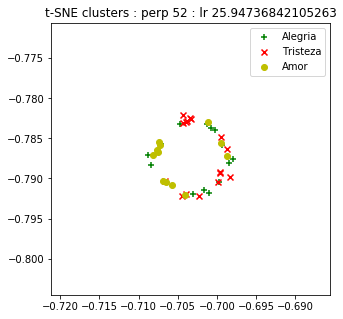

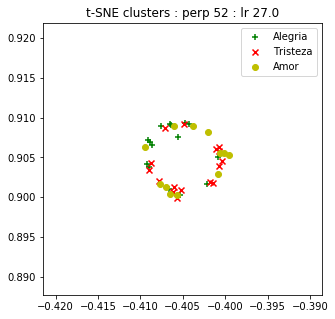

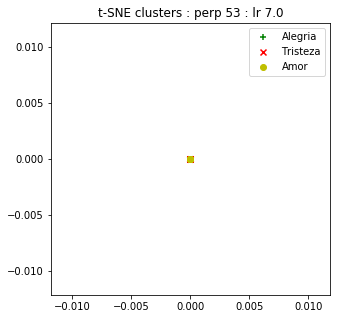

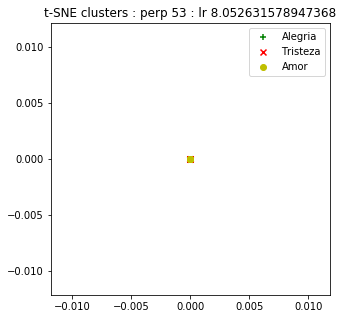

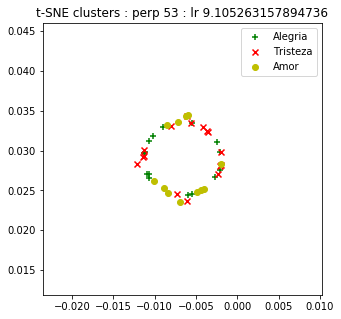

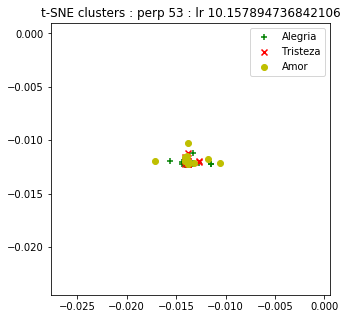

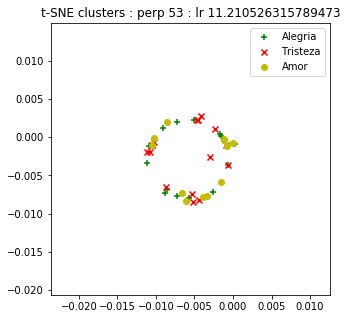

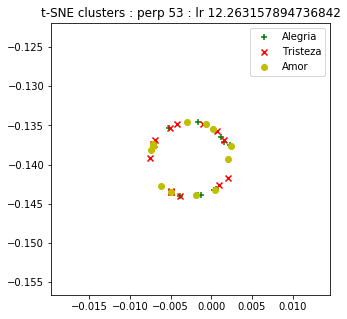

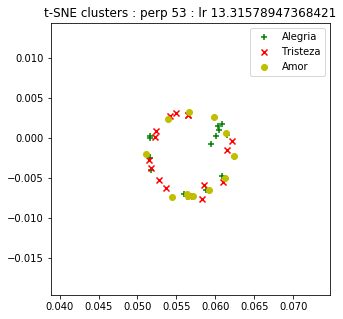

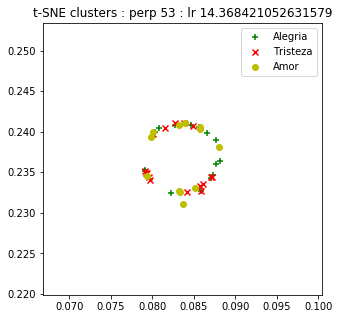

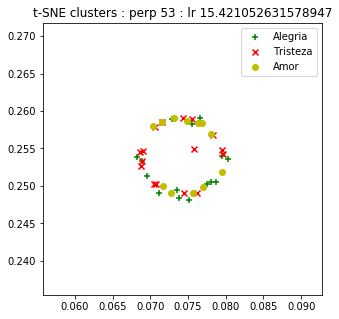

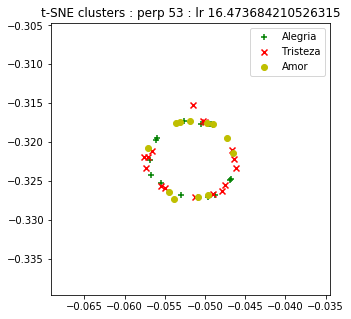

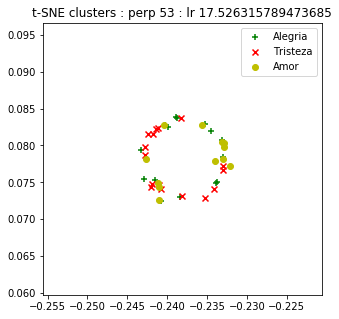

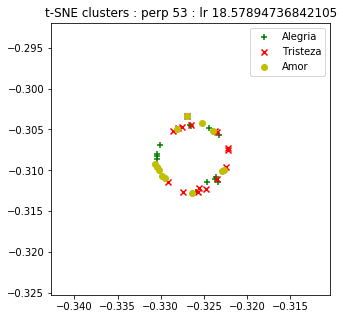

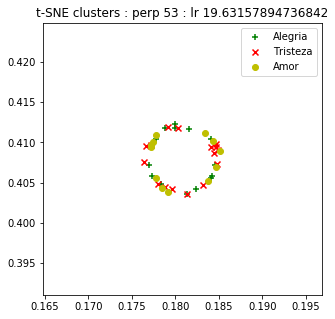

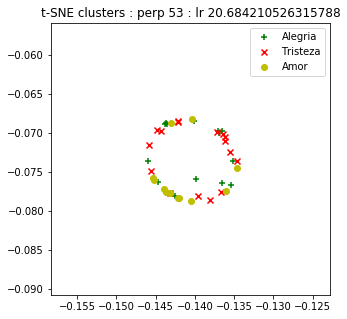

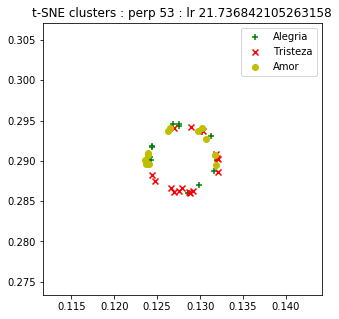

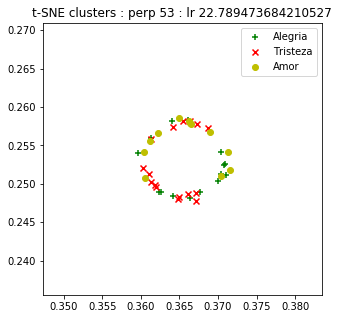

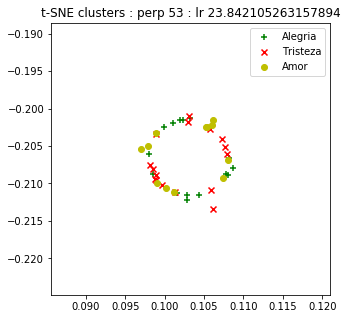

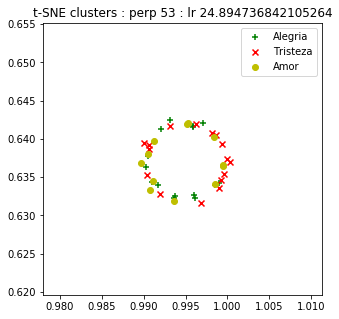

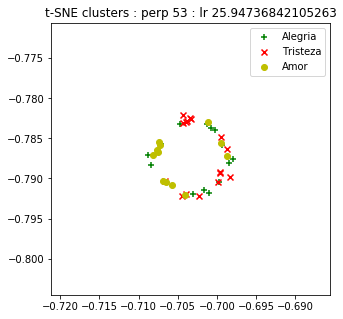

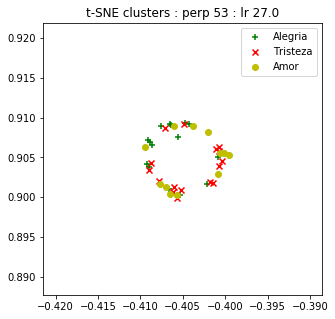

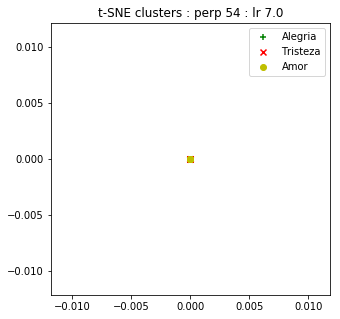

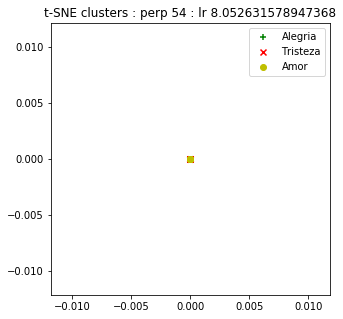

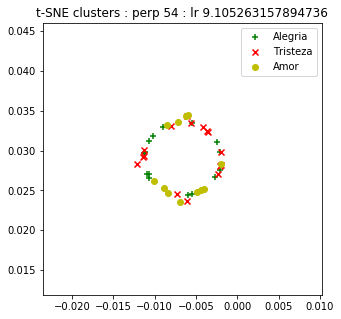

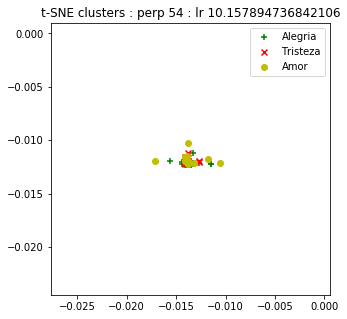

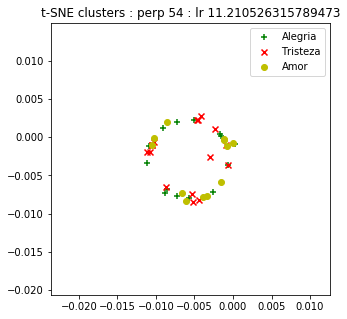

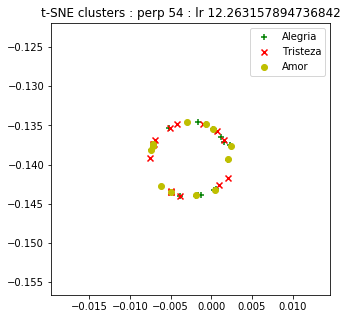

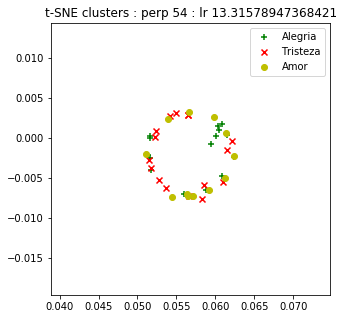

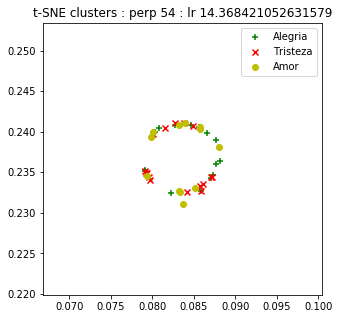

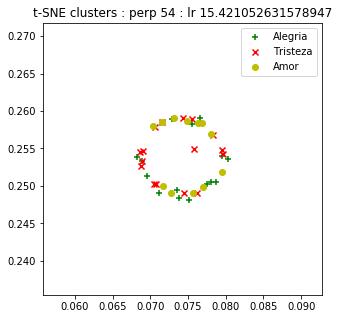

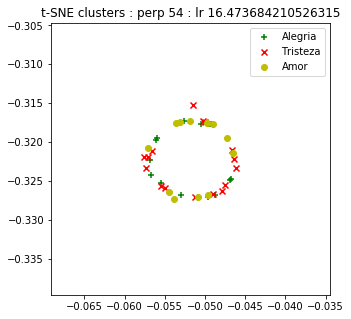

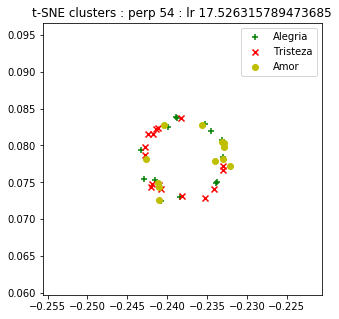

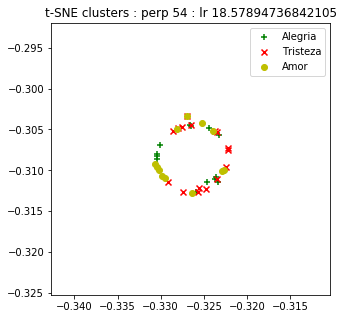

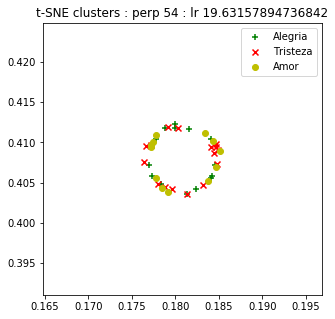

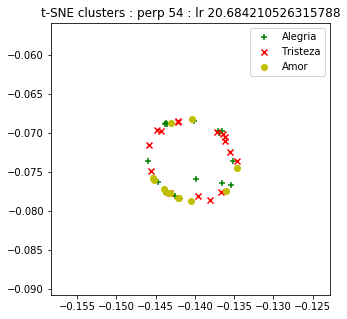

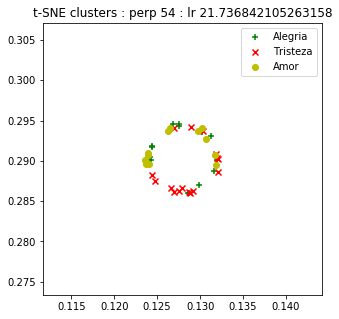

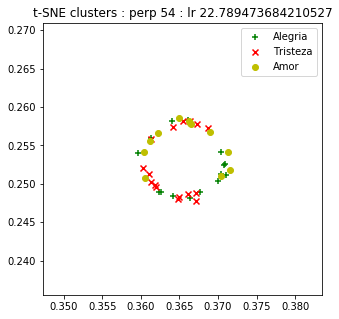

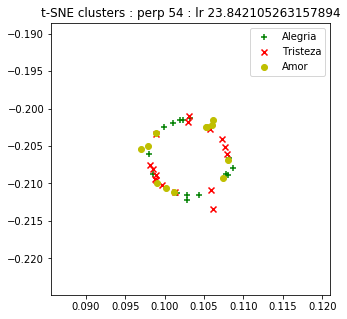

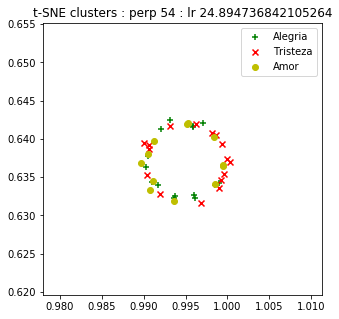

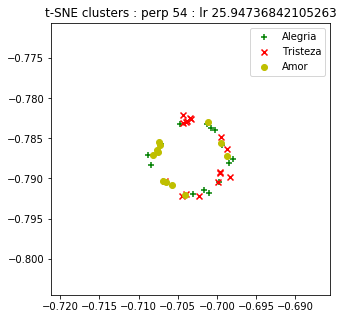

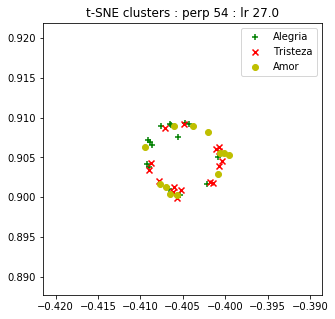

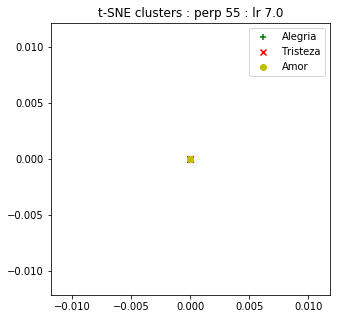

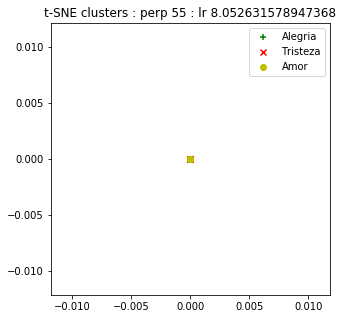

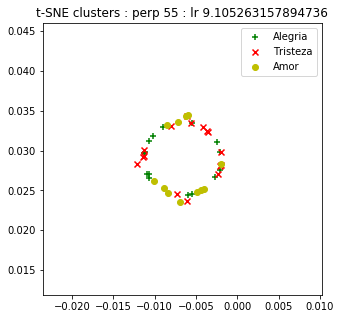

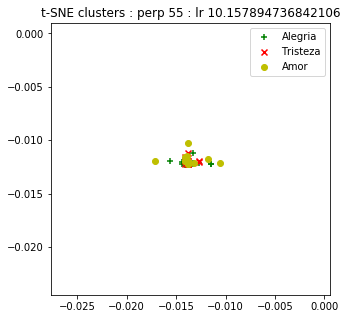

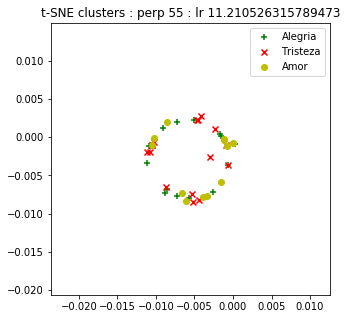

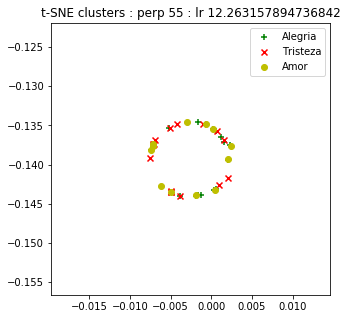

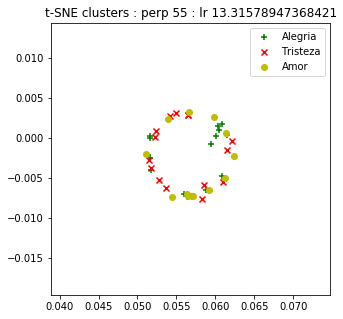

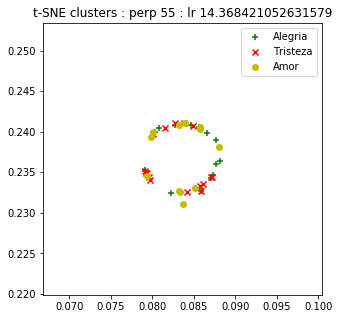

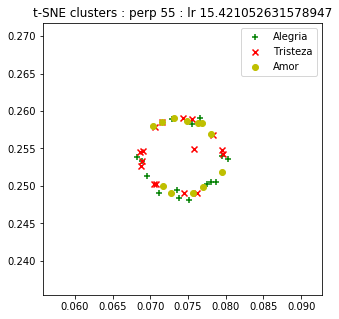

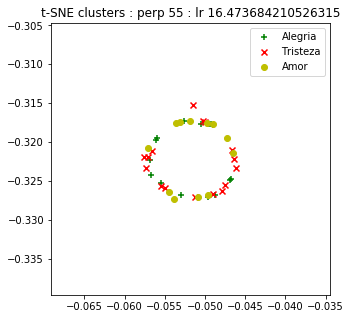

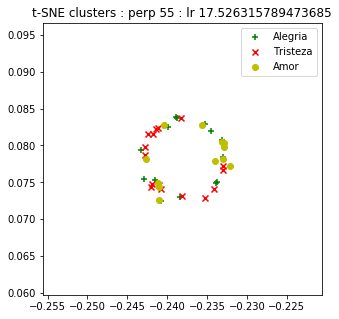

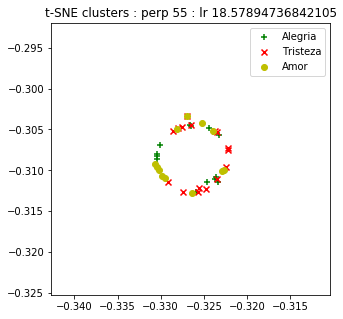

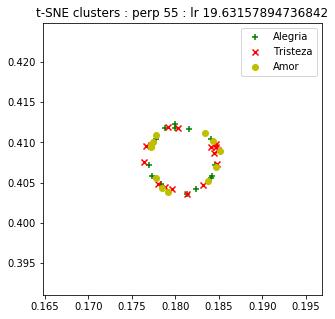

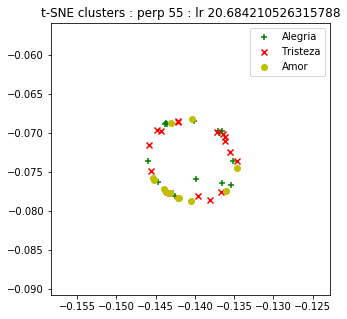

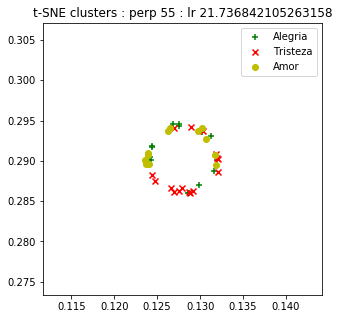

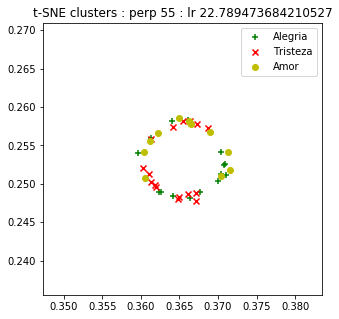

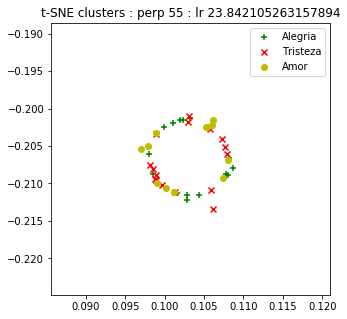

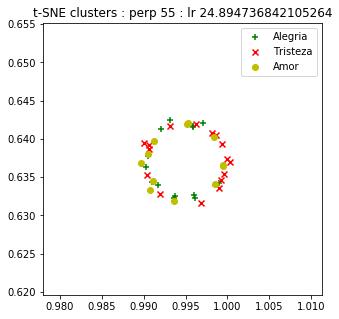

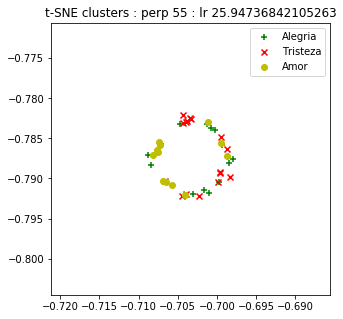

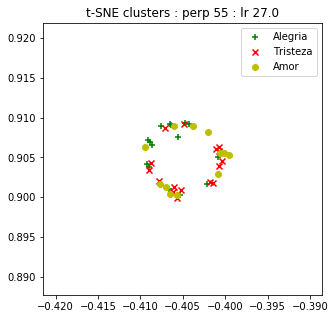

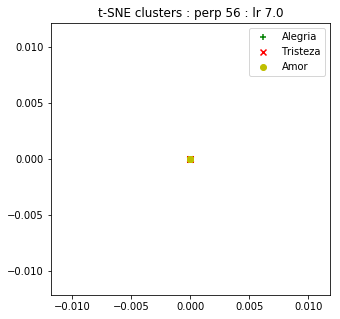

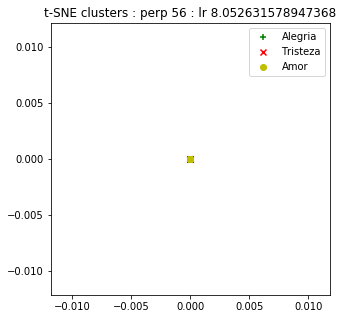

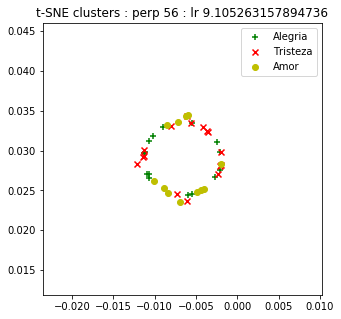

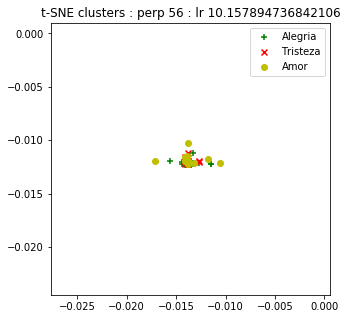

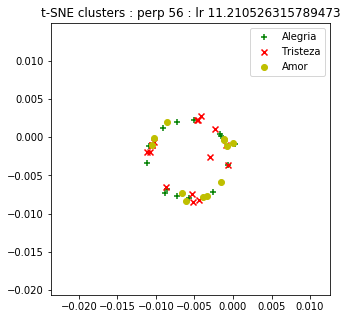

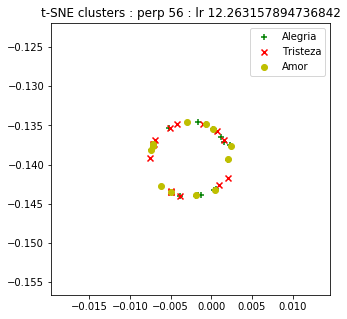

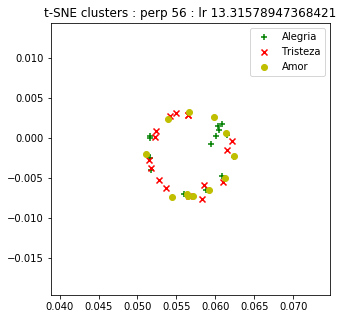

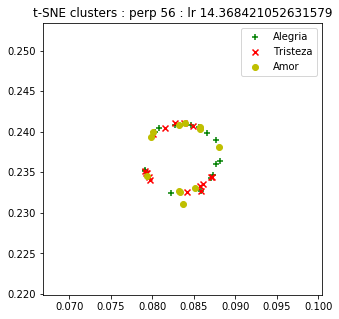

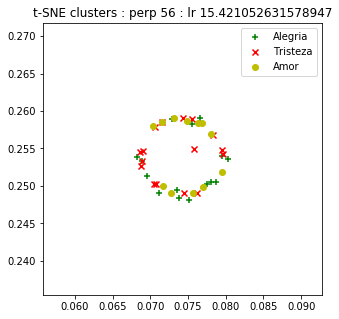

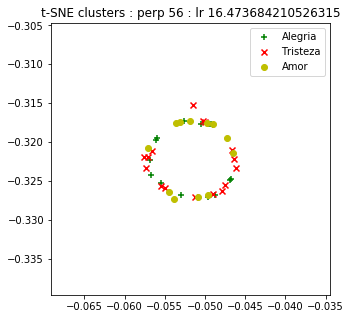

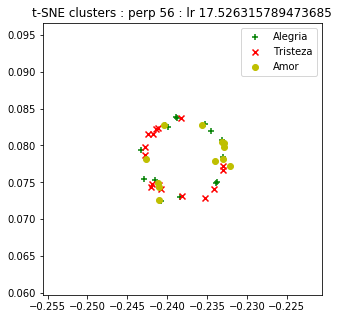

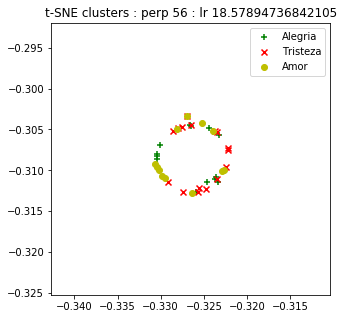

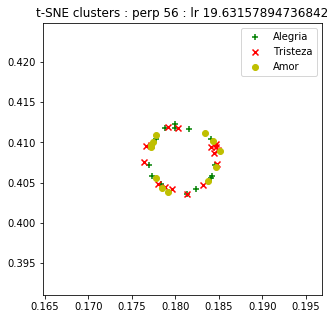

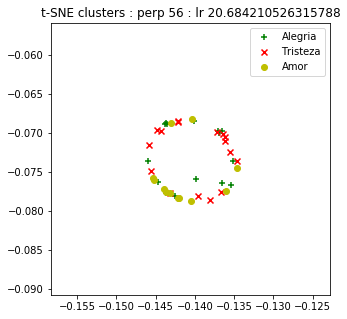

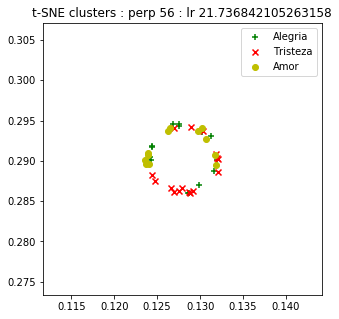

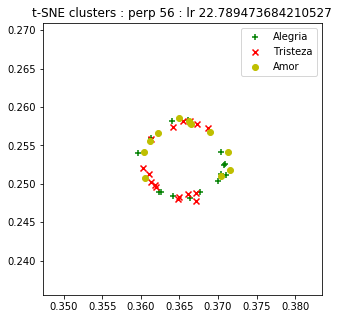

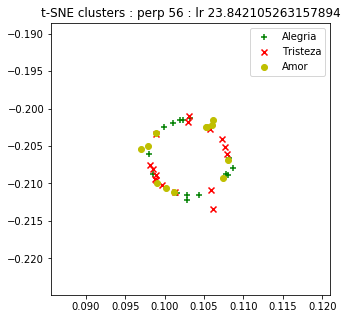

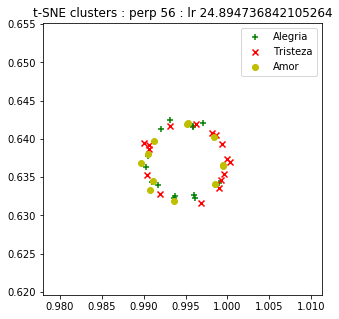

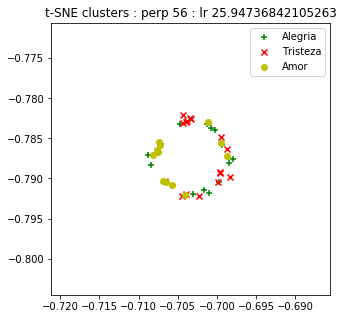

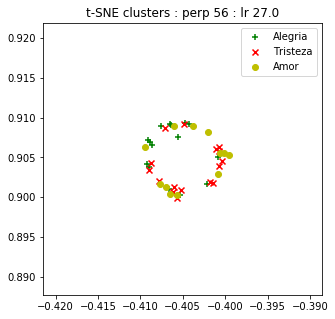

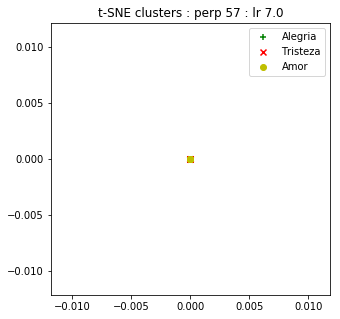

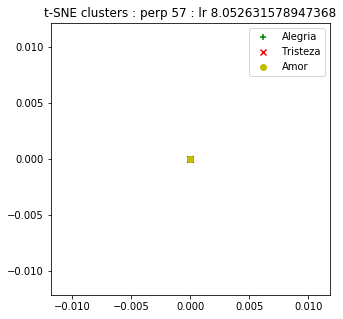

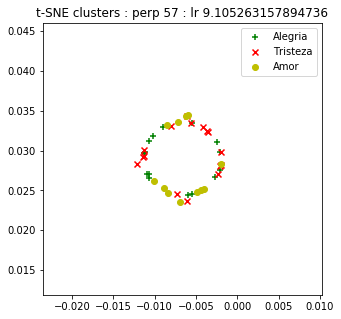

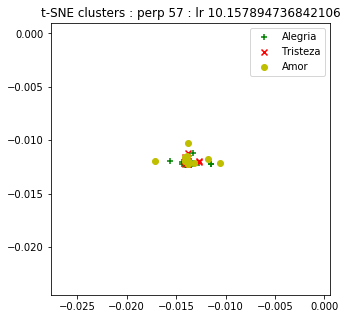

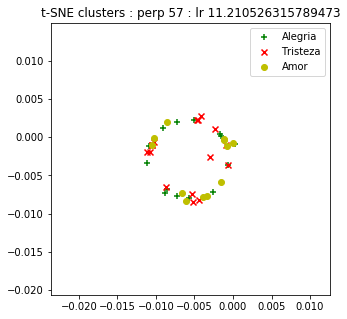

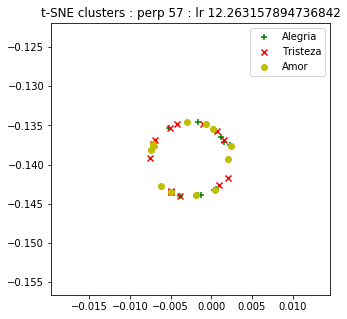

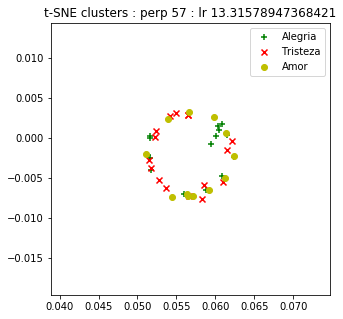

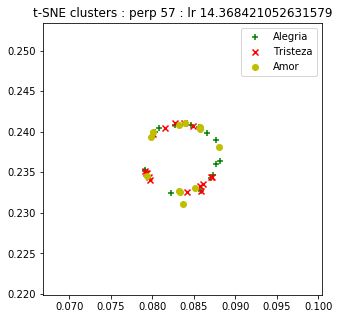

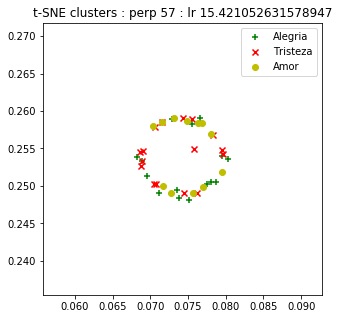

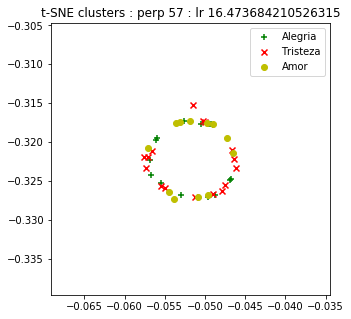

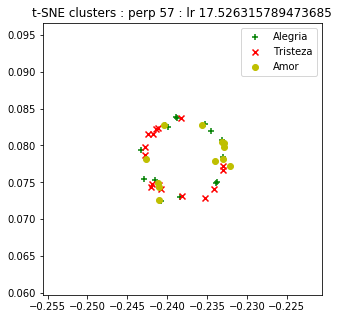

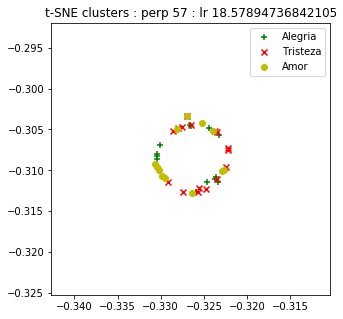

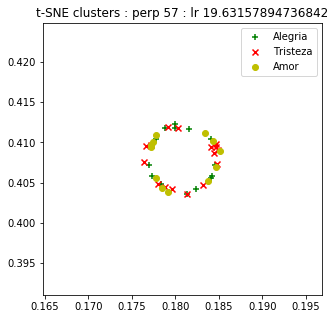

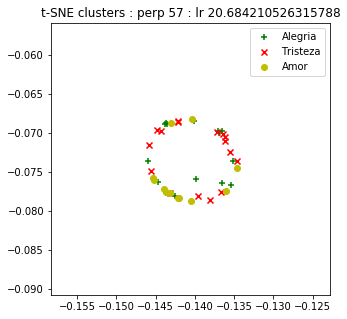

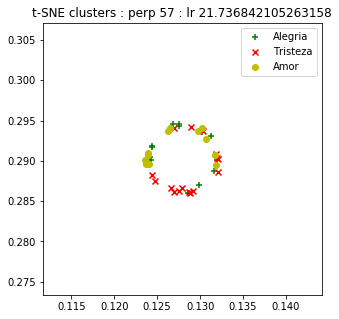

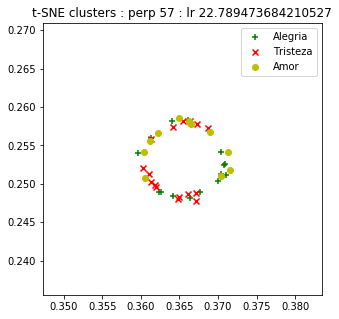

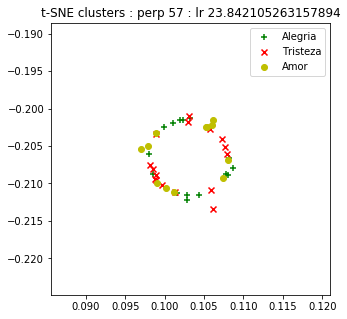

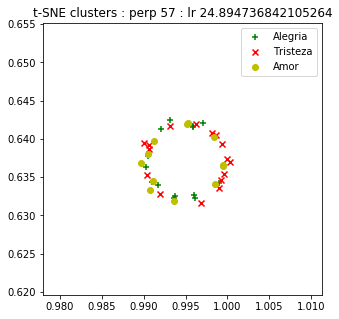

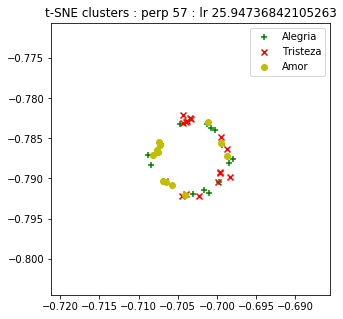

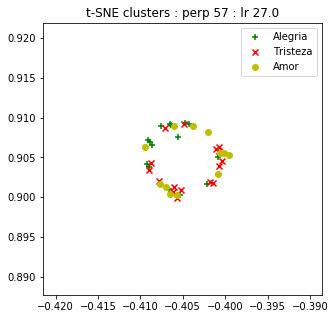

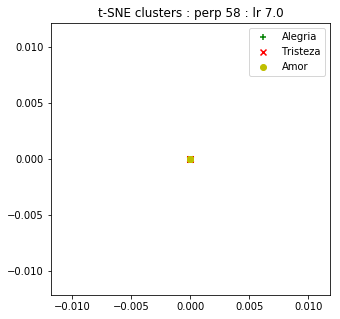

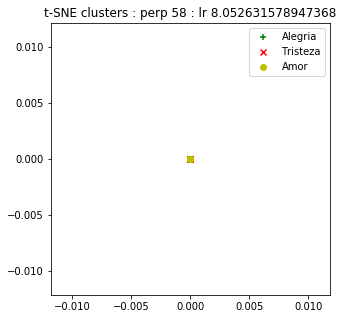

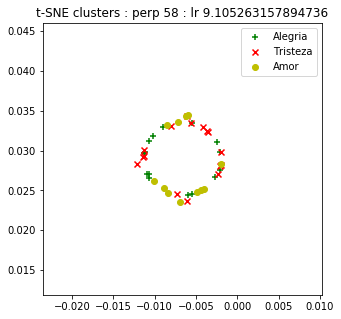

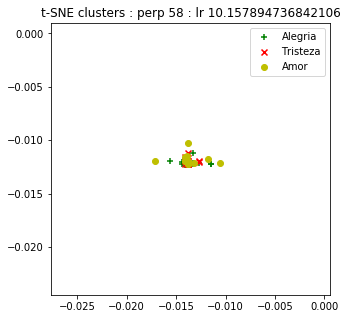

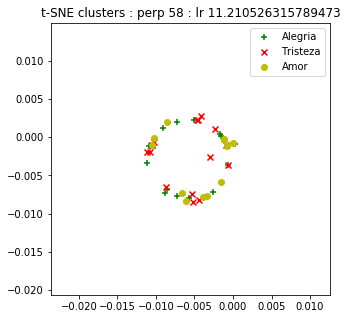

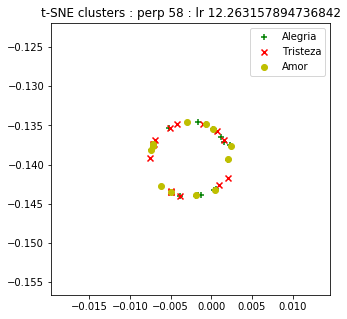

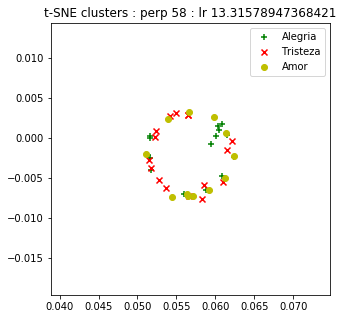

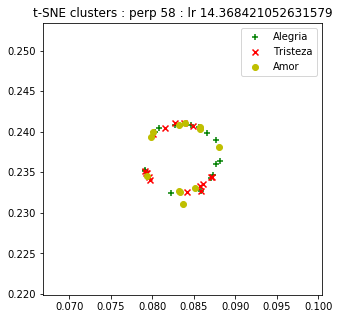

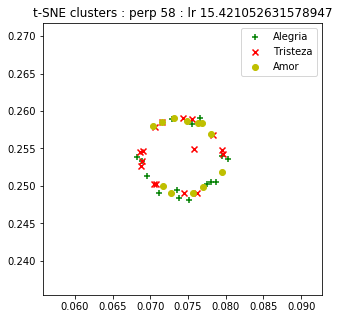

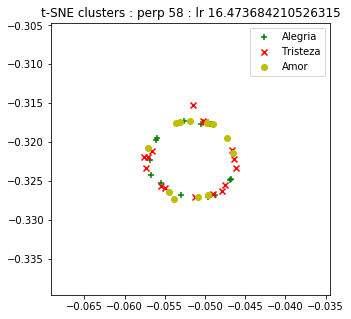

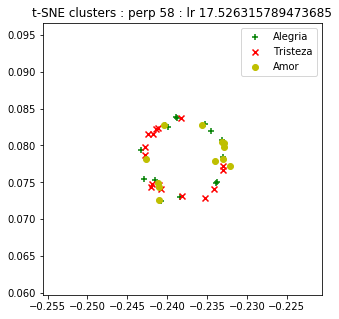

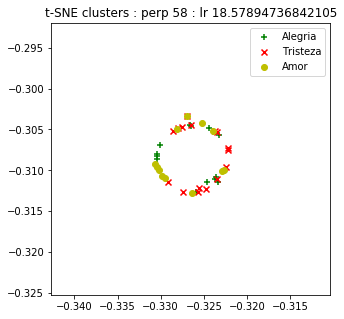

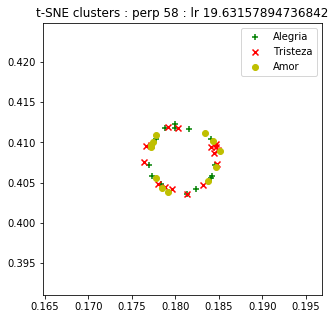

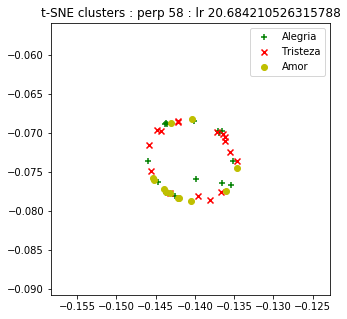

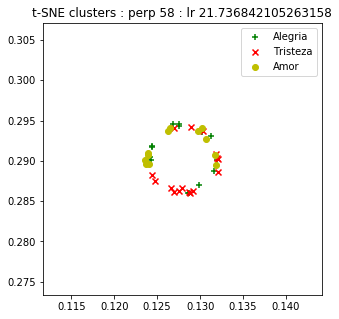

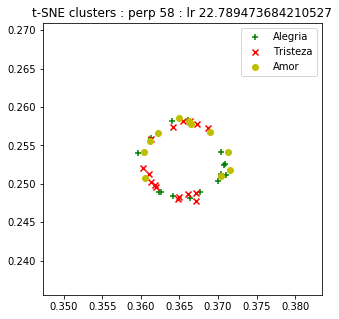

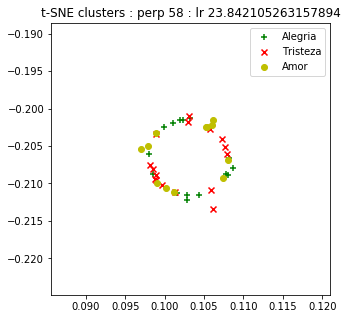

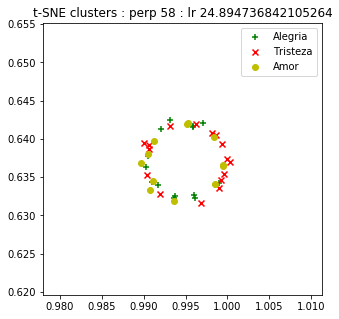

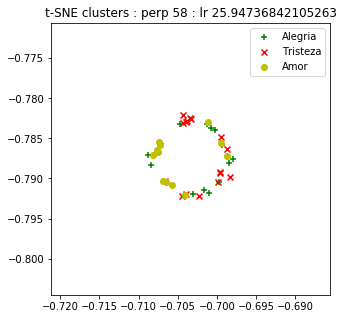

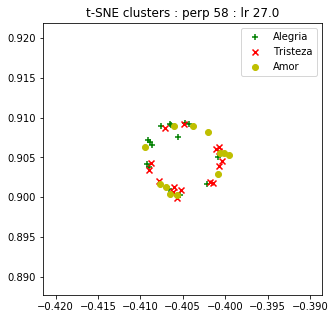

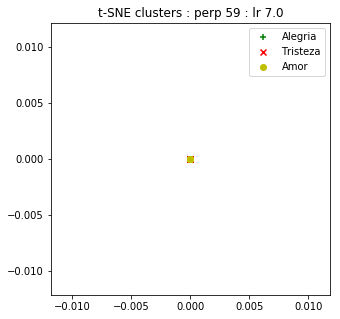

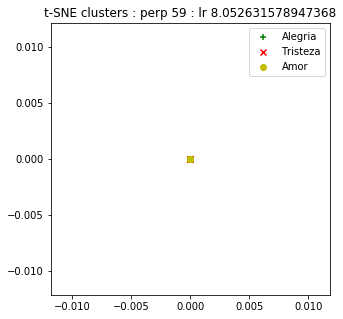

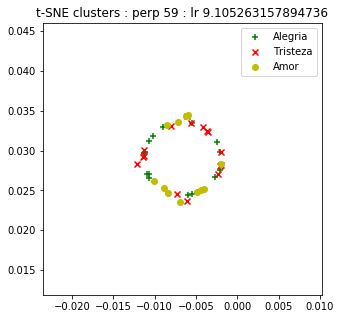

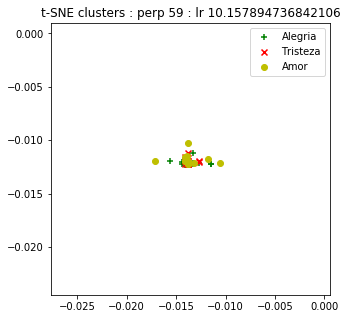

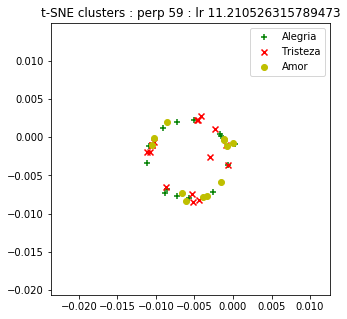

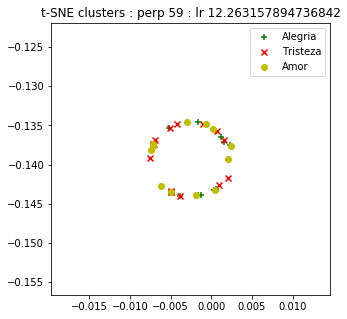

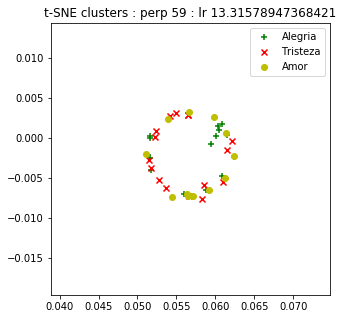

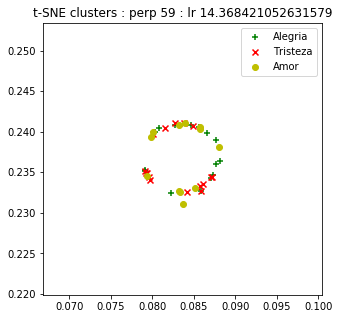

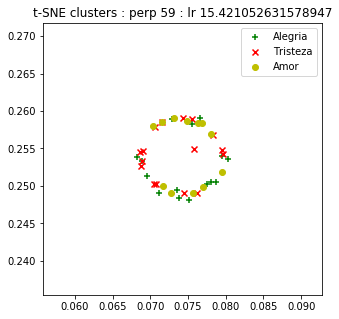

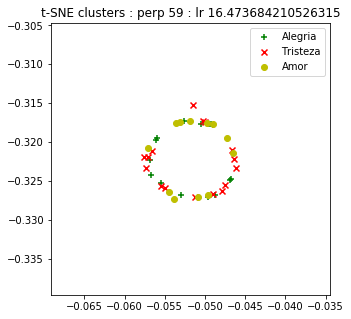

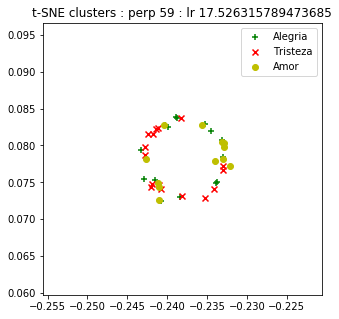

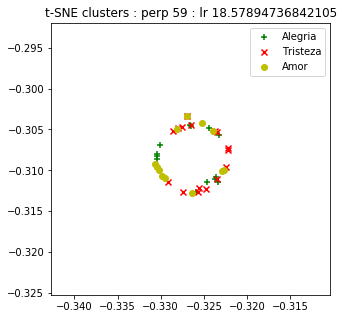

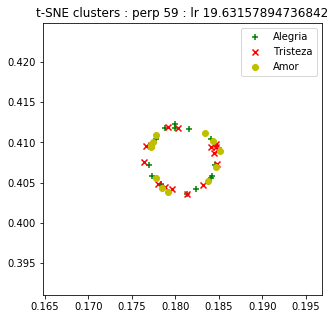

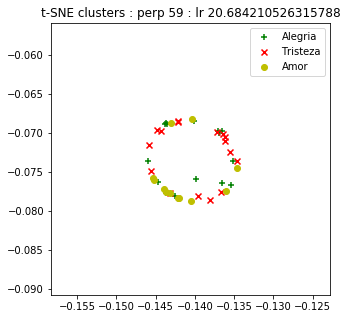

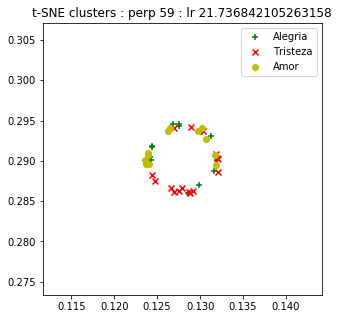

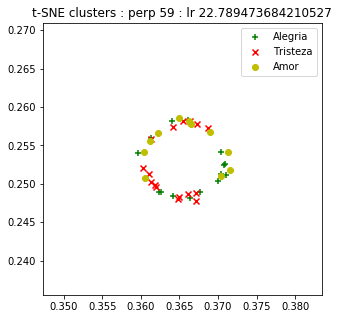

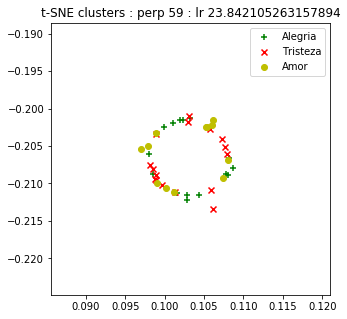

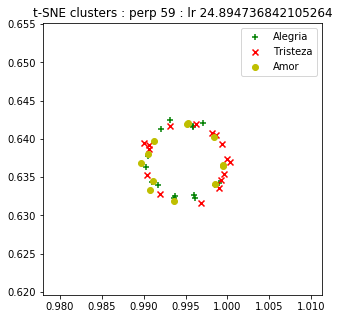

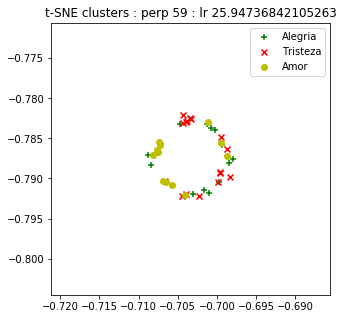

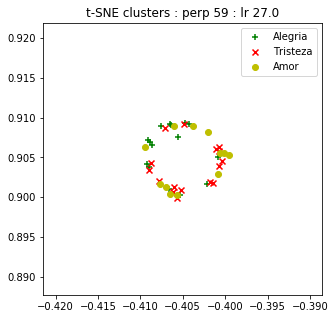

In [216]:
import time
for perp in range(35, 60):
    for lr in np.linspace(7, 27, 20):

        J = TSNE(n_components=2, perplexity=perp, learning_rate=lr, random_state=0).fit_transform(X)

        sc_alegria = []
        sc_tristeza = []
        sc_amor = []
        for jk, frase in enumerate(frases):
            if frase in frases_felicidade_parsed:
                # print('ALEGRIA', frase, J[jk])
                sc_alegria.append(J[jk])
            if frase in frases_tristeza_parsed:
                # print('TRISTEZA', frase, J[jk])
                sc_tristeza.append(J[jk])
            if frase in frases_amor_parsed:
                # print('AMOR', frase, J[jk])
                sc_amor.append(J[jk])

        sc_alegria = np.asarray(sc_alegria)
        sc_tristeza = np.asarray(sc_tristeza)
        sc_amor = np.asarray(sc_amor)

        fig = plt.figure(figsize = (5, 5))
        c1 = plt.scatter(sc_alegria[:, 0], sc_alegria[:, 1], c='g', marker='+')
        c2 = plt.scatter(sc_tristeza[:, 0], sc_tristeza[:, 1], c='r', marker='x')
        c3 = plt.scatter(sc_amor[:, 0], sc_amor[:, 1], c='y', marker='o')
        plt.title(f't-SNE clusters : perp {perp} : lr {lr}')
        plt.legend([c1, c2, c3], ['Alegria', 'Tristeza', 'Amor'])
        # plt.show()
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(.4)

Acurácia: 96.0%


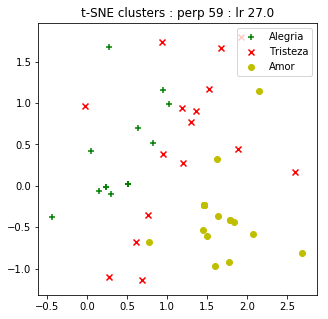

In [272]:
J = TSNE(n_components=2, perplexity=35, learning_rate=15, random_state=0).fit_transform(X)
sc_alegria, alegria_label = [], []
sc_tristeza, tristeza_label = [], []
sc_amor, amor_label = [], []
for jk, frase in enumerate(frases):
    if frase in frases_felicidade_parsed:
        sc_alegria.append(J[jk])
        alegria_label.append('ALEGRIA')
    if frase in frases_tristeza_parsed:
        sc_tristeza.append( J[jk])
        tristeza_label.append('TRISTEZA')
    if frase in frases_amor_parsed:
        sc_amor.append(J[jk])
        amor_label.append('AMOR')
sc_alegria = np.asarray(sc_alegria)
sc_tristeza = np.asarray(sc_tristeza)
sc_amor = np.asarray(sc_amor)
alegria_label = np.asarray(alegria_label)
tristeza_label = np.asarray(tristeza_label)
amor_label = np.asarray(amor_label)

labels = np.append(np.append(alegria_label, tristeza_label), amor_label)

md = SVC(kernel='rbf', gamma=5, random_state=0)
md.fit(J, labels)
print(f'Acurácia: {np.round(md.score(J, labels), 2) * 100}%')

fig = plt.figure(figsize = (5, 5))
c1 = plt.scatter(sc_alegria[:, 0], sc_alegria[:, 1], c='g', marker='+')
c2 = plt.scatter(sc_tristeza[:, 0], sc_tristeza[:, 1], c='r', marker='x')
c3 = plt.scatter(sc_amor[:, 0], sc_amor[:, 1], c='y', marker='o')
plt.title(f't-SNE clusters : perp {perp} : lr {lr}')
plt.legend([c1, c2, c3], ['Alegria', 'Tristeza', 'Amor'])
plt.show()